## TODO:
+ Add transform to vid image? Yes, need to resize to 256
+ Standardize number of frame. OR find a way to group dataset by similar frames.


In [1]:
!pip install torch-summary
 
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from glob import glob
from tqdm import tqdm

import torchvision
from torchvision import models
from torchsummary import summary
import time

import os
import pandas as pd
import math

from segmentation import segment_rm_bg


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /Users/elliotmoose/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/elliotmoose/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:28<00:00, 8.65MB/s]


In [4]:
l = pd.read_csv("./dataset/train_labels.csv",names = ["file_name", "label"])
l["signer"] = l.apply(lambda r: int(r.file_name.split("_")[0][6:]), axis =1)
t = l[l.signer == "signer0"]["label"].to_numpy()
# np.unique(t).shape
l

,file_name,label,signer
0,signer0_sample1,41,0
1,signer0_sample2,104,0
2,signer0_sample3,205,0
3,signer0_sample4,26,0
4,signer0_sample5,191,0
...,...,...,...
28137,signer42_sample668,82,42
28138,signer42_sample669,164,42
28139,signer42_sample670,215,42
28140,signer42_sample671,123,42


## Dataset Class


In [14]:
class AUTSLDataset(Dataset):
    '''
    Dataset for the AUTSL data
    '''
    
    def __init__(self, data_type, max_frame_no ,frame_interval = 1, file_percentage = 1.0, data_path ="./dataset/", device='cpu', remove_background=True):
        self.data_type = data_type
        self.frame_interval = frame_interval
        self.data_path = {"train": data_path + "train/",
                          "val": data_path + "val/"
                         }        
        self.data_length = {"train":  int(len(glob(f"{self.data_path['train']}*_color.mp4"))*file_percentage),
                            "val": int(len(glob(f"{self.data_path['val']}*_color.mp4"))*file_percentage)
                           }
        # self.data_length = {"train":  len(os.listdir(self.data_path["train"]))}
        self.label_path = {"train": data_path + "train_labels.csv",
                           "val": data_path + "val_labels.csv"
                          }
        self.labels = pd.read_csv(self.label_path[self.data_type],names = ["file_name", "label"])
#         self.max = 156
        self.file_ls = glob(f"{self.data_path[self.data_type]}*_color.mp4")[:self.data_length[self.data_type]]
        self.max_frame_no = max_frame_no
        self.device = device
        self.remove_background = remove_background

#         self.max = self.get_max()
        
    def Describe(self):
        msg = "AUTSL Dataset\n"
        print(msg)
    
#     def CreateLabel(self):
#         label_df = pd.read_csv(self.label_path[self.data_type],names = ["file_name", "label"])
#         label_df["signer"] = label_df.apply(lambda r: int(r.file_name.split("_")[0][6:]), axis =1)
#         return label_df   
        
    def GetLabel(self, file_name):
        return self.labels[self.labels.file_name ==file_name]["label"].values[0]
    
    def GetVideoArray(self, file_name):

        cap = cv2.VideoCapture(self.data_path[self.data_type] + file_name)   # capturing the video from the given path
        video_arr = []
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % self.frame_interval == 0):
                # Converting to tensor
                frame =  torchvision.transforms.functional.to_tensor(frame).float().to(self.device)
                frame = frame.unsqueeze(0)
                frame =  F.interpolate(frame, (256,256), mode='bilinear')
                frame = frame.squeeze(0)
                video_arr.append(frame)
        cap.release()

    
        if len(video_arr)<self.max_frame_no:
            empty_frame = torch.zeros((3,256,256)).to(self.device)
            padding  = [empty_frame]*(self.max_frame_no-len(video_arr))
            video_arr+=padding

        return torch.stack(video_arr) 
        
    def __len__(self):
        return self.data_length[self.data_type]
    
    def __getitem__(self, index):
        '''
        Return 4D array consists of all the frame of the video image AND the label
        '''
        file_name = os.path.basename(self.file_ls[index])
        # print(file_name)
        video_arr = self.GetVideoArray(file_name)

        if self.remove_background:

            if self.deeplabmodel == None:
                self.deeplabmodel = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True).to(self.device).eval()
            video_arr = segment_rm_bg(video_arr, self.deeplabmodel, self.device)
        
        label = self.GetLabel(file_name[:-10]) #slice to get just the name without file ext and file type
        return video_arr, label
        
    def get_max(self):
        max_length = 0
        for i in tqdm(range(len(self))):
            video, label = self[i]
            if video.shape[0]>max_length:
                max_length = video.shape[0]
        return max_length
    


Length of train dataset: 14071
Length of val dataset: 0
Time taken to load 1 datapoint = 0.4751659540000004
Sample training data:
input shape: torch.Size([78, 3, 256, 256])
output: 23


/home/victorpham1997/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


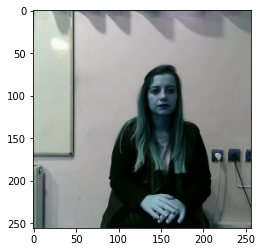

In [16]:
batch_size = 16

train_autsl = AUTSLDataset("train", int(156/2), frame_interval=2, file_percentage=0.5, device='cuda', remove_background=True)
# val_autsl = AUTSLDataset("val", int(114/2), frame_interval=2)
trainloader = DataLoader(train_autsl, batch_size=batch_size, shuffle=True)
# valloader = DataLoader(val_autsl, batch_size=batch_size, shuffle=True)

print(f"Length of train dataset: {len(train_autsl)}")
print(f"Length of val dataset: {len(val_autsl)}")
start = time.process_time()
video, label = train_autsl[1]
print(f"Time taken to load 1 datapoint = {time.process_time() - start}")
print(f"Sample training data:\ninput shape: {video.shape}\noutput: {label}")
plt.imshow(video[0].cpu().permute(1,2,0))



## Baseline model

In the next section, we will try to recreate the baseline model from the "AUTSL: A Large Scale Multi-modal Turkish Sign Language Dataset and Baseline Methods" paper.<br>
The following section from the model may be useful when recreating the baseline model:


### 4.2 Baseline Models
We construct five deep neural networks for the empirical evaluations. In all the models, we use
CNNs to extract spatial features from each frame. In our experiments, we investigate the contributions
of using a feature pooling module and temporal attention model as we described in Section 4.1. We
also compare the performances using simple unidirectional LSTM and bidirectional LSTMs. All our
networks, as illustrated in Fig. 5, are separately trained end-to-end.<br>
#### CNN + LSTM Model:
In our models, we conduct our experiments using only RGB and
RGB-D modalities, with minor modifications. In order to use the depth data, which is represented as
a single channel gray-scale image for each frame, with the pretrained VGG model, we repeat the same
depth data into three color channels as in [56]. Then, RGB and depth modalities are given as inputs to
the two parallel VGG models with exact same architectures and applying similar training regime as we
described in the previous section. CNN networks extract features and generate two feature matrices,
i.e. one for the RGB data and one for the depth data. Then, we apply global average pooling and
reduce the feature map dimensions to a vector of size 512 for each modality, separately. In the RGB
only model, we feed 512-dimensional feature vectors into the LSTM model. On the other hand, in the
RGB-D network, we concatenate two feature vectors with late fusion and obtain a 1024-dimensional
feature vector. LSTM model generates scores using the the last hidden state vector, i.e. h t , after
passing it to the Fully Connected (FC) layer. Since we have 226 signs, FC layer is set to have 226
neural units. The scores of the FC layers are fed to a softmax classifier. We refer to this model as CNN + LSTM from now on.<br>
#### CNN + FPM + LSTM Model: 
In the second model, our motivation is to represent the
generated features in multiple-scales, so that we can get more contextual clues for classification of
individual signs. We add an FPM module after the last CNN layer for that purpose. After that, we
apply global average pooling to the extracted features. In the RGB-D model, we again concatenate the
two feature vectors with a late fusion. Then, we send extracted features to LSTM. All the architectures,
i.e. CNN and LSTM, are the same with the previous model, except for the addition of the FPM module
in between these models. As we stated before, all the parameters of this network is trained end-to-end
from scratch. We refer to this model as CNN + FPM + LSTM.<br>
#### CNN + LSTM + Attention Model: 
Attention mechanisms have recently shown considerable
improvements to many computer vision tasks. Therefore, we also want to investigate the contribution
of attention to the classification performance with our dataset. The architecture is designed as follows:
First, we extract the features with CNN and then apply global average pooling as in CNN + LSTM
model. The only difference of this method from CNN + LSTM model is that we incorporate a temporal
attention mechanism to the features that are passed to the LSTM model. We produce a context vector,
c, using all the hidden states as we explained in detail in Section 4.1. We then send this context vector,
instead of the last hidden state, to the FC layer. Finally, we use a softmax classifier. This model is
referred to as CNN + LSTM + Attention.<br>
#### CNN + FPM + LSTM + Attention Model: 
In this model, we observe the contribution of
using both FPM and a temporal attention mechanism. At first, we extract features with CNN and pass
the resultant feature maps to FPM. Then, we use the attention-based LSTM. Here again, we send the
context vector to the FC layer and use softmax classifier. This model is referred to as CNN + FPM +
LSTM+ Attention.<br>
#### CNN + FPM + BLSTM + Attention Model: 
Finally, we want to investigate the classi-
fication performance using bidirectional LSTMs with AUTSL dataset. We configured the components
of the model as in the CNN + FPM + LSTM + Attention model, but we use attention based BLSTM
instead of LSTM this time.

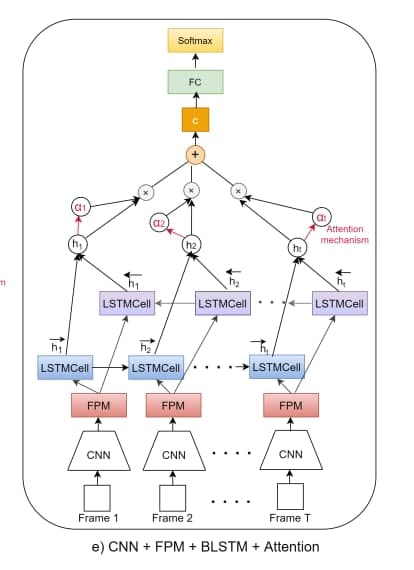


In [4]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.pretrained_vgg = models.vgg16(pretrained=True)
        self.pretrained_vgg = nn.Sequential(*list(self.pretrained_vgg.features.children())[:-5])

        # Freeze parameter
        for param in self.pretrained_vgg.parameters():
            param.requires_grad = False

        # Manually add in the layers that are going to be finetuned
        self.pretrained_vgg.add_module("conv5_2", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.pretrained_vgg.add_module("relu5_2", nn.ReLU(inplace=True))
        self.pretrained_vgg.add_module("conv5_3", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.pretrained_vgg.add_module("relu5_3", nn.ReLU(inplace=True))
        
    def forward(self, x):
        '''
        Input shape = (batchsize, seq, 3, h, w)
        '''
        output = self.pretrained_vgg(x)
        return output
        
        
class fpm(nn.Module):
    def __init__(self):
        super(fpm, self).__init__()
        self.pool1_0 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1,dilation=2)
        self.conv1_1 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=1)
        self.conv2_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=1)
        self.conv3_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=2,dilation=2)
        self.conv4_0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=4,dilation=4)
        
    def forward(self, x):
        '''
        Input shape = (batchsize, seq, 512, 16, 16)
        '''
        x_1 = self.pool1_0(x)
        x_1 = F.relu(self.conv1_1(x_1))
        x_2 = F.relu(self.conv2_0(x))
        x_3 = F.relu(self.conv3_0(x))
        x_4 = F.relu(self.conv4_0(x))
        
        out = torch.cat([x_1,x_2,x_3,x_4], dim=1)
        
        return out

    
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional = True):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first = True , bidirectional=self.bidirectional)
    
    def forward(self, inputs, hidden):
#         print(hidden[0].shape,hidden[1].shape)
        output, hidden_state = self.lstm(inputs, hidden)
#         print(output.shape, hidden[0].shape,hidden[1].shape)
        return output, hidden_state 
    
    def init_hidden(self, batch_size):
        return (torch.zeros(1 + int(self.bidirectional), batch_size, self.hidden_size), torch.zeros(1 + int(self.bidirectional), batch_size, self.hidden_size))
    
    
class attention(nn.Module):
    def __init__(self):
        super(attention, self).__init__()
        self.dropout_p = 0.25
        self.dropout1 = nn.Dropout(self.dropout_p)
        self.dropout2 = nn.Dropout(self.dropout_p)
        self.linear1 = nn.Linear(1024, 1024)
        self.linear2 = nn.Linear(1024, 1, bias=False)
        
        
    def forward(self, x):
        hidden = x
#         print(inputs.shape, hidden.shape)
        x = torch.tanh(self.linear1(x))
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        x = F.softmax(x, dim=len(x.shape)-1)
        
#         print(x.shape,hidden.shape)
#         print((x*hidden).shape)
        
        c = torch.sum(x*hidden, dim=1)
    
        return c
    
    

    
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.bidirectional = True
        self.lstm_hiddensize = 512
        self.dropout_p = 0.25
        
        self.cnn = cnn()
        self.fpm = fpm()
        self.lstm = lstm(512, self.lstm_hiddensize, self.bidirectional)
        self.attn = attention()
        self.dropout1 = nn.Dropout(self.dropout_p)
        self.fc = nn.Linear(1024,226)
        
        
    def forward(self,x):
        embedding_output = []
        for i in range(x.size(1)):
            x_i = self.cnn(x[:,i,:,:,:])
            x_i = self.fpm(x_i)
            x_i = x_i.mean([-2, -1]) #Global Average Pooling
            
            embedding_output.append(x_i)
        
        embedding_output = torch.stack(embedding_output, dim=1)
#         print(embedding_output.shape[0])
        
        h_0, h_1 = self.lstm.init_hidden(embedding_output.shape[0])
        h_0 = h_0.to("cuda")
        h_1 = h_1.to("cuda")
        
        output, (final_hidden_state, final_cell_state) = self.lstm(embedding_output, (h_0,h_1)) # final_hidden_state.size() = (1, batch_size, hidden_size) 
        c = self.attn(output)
#         print(c.shape)
        output = self.dropout1(self.fc(c))
        output = F.log_softmax(output, dim=len(output.shape)-1)
        
        return output
    
    

In [5]:
model = BaselineModel()
# x = torch.rand((5, 4, 3, 256, 256))
summary(model, (4, 3, 256, 256), device="cuda")

# Define Parameter here:
model_type = "baseline"
model_path = "./model/"
batch_size = 1
n_epochs = 5
lr = 1e-5
steps = 0 
print_every = 50
validate_every = 50
device = "cuda"

train_loss_ls = []
val_loss_ls = []


time_stamp = str(time.time()).split(".")[0]
current_model_path = model_path + f"{model_type}-{time_stamp}-{n_epochs}e-{batch_size}b/"
os.mkdir(current_model_path)


criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr )
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─cnn: 1-1                               [-1, 512, 16, 16]         --
|    └─Sequential: 2-1                   [-1, 512, 16, 16]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        (1,792)
|    |    └─ReLU: 3-2                    [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-3                  [-1, 64, 256, 256]        (36,928)
|    |    └─ReLU: 3-4                    [-1, 64, 256, 256]        --
|    |    └─MaxPool2d: 3-5               [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-6                  [-1, 128, 128, 128]       (73,856)
|    |    └─ReLU: 3-7                    [-1, 128, 128, 128]       --
|    |    └─Conv2d: 3-8                  [-1, 128, 128, 128]       (147,584)
|    |    └─ReLU: 3-9                    [-1, 128, 128, 128]       --
|    |    └─MaxPool2d: 3-10              [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-11                 [-1, 256, 64, 64]   

BaselineModel(
  (cnn): cnn(
    (pretrained_vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
  

In [12]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt


def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
#     confusion_matrix = torch.zeros(num_classes, num_classes)
    with tqdm(testloader, position=0, leave=False) as progress_bar:          
        for images, labels in progress_bar:
    #     for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            test_loss += criterion(output, labels).item()

            ps = torch.exp(output)
            predictions = ps.max(dim=1)[1]
            equality = (labels.data == predictions)
            accuracy += equality.type(torch.FloatTensor).mean()

    #         for label, prediction in zip(labels.view(-1), predictions.view(-1)):
    #             confusion_matrix[label.long(), prediction.long()] += 1

    return test_loss, accuracy


def test(model, testloader, device='cuda'):  
    model.to(device)
    accuracy = 0

    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
                    
            output = model(images)
            
            ps = torch.exp(output)
            predictions = ps.max(dim=1)[1]
            equality = (labels.data == predictions)
            accuracy += equality.type(torch.FloatTensor).mean()

            for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

#         recall = metrics.recall(confusion_matrix, num_classes)
#         precision = metrics.precision(confusion_matrix, num_classes)
#         f1 = metrics.f1(confusion_matrix, num_classes)
        print('Testing accuracy: {:.3f}'.format(accuracy/len(testloader)))
        print(f'Testing recall: {recall:.3f}')
        print(f'Testing precision: {precision:.3f}')
        print(f'Testing f1: {f1:.3f}')

    return accuracy, confusion_matrix


def train(model, model_name, batch_size, n_epochs, lr, train_loader, val_loader, saved_model_path, device = "cuda"):
#     input_sample, _ =  next(iter(train_loader))
#     print(summary(model, tuple(input_sample.shape[1:]), device=device))

    start_time = datetime.now()


    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr= lr)
#     if use_lr_scheduler:
#         scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)


    train_loss_ls = []
    val_loss_ls = []

    best_accuracy = 0
    best_recall = 0
    best_accuracy_weights = None
    best_recall_weights = None
    
    steps = 0
    
    
    running_loss = 0.0
    running_loss2 = 0.0
    for e in range(n_epochs):  # loop over the dataset multiple times

        # Training
        model.train()
        with tqdm(train_loader, position=0, leave=False) as progress_bar:          
            for images, labels in progress_bar:
                steps += 1
#                 images, labels = images.to(device), labels.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                running_loss2 += loss.item()
                
                if steps % validate_every == -1:
        
                    # Eval mode for predictions
                    model.eval()

                    # Turn off gradients for validation
                    with torch.no_grad():
                        test_loss, accuracy = validation(model, val_loader, criterion, device)
#                         recall = metrics.recall(confusion_matrix, num_classes)
#                         precision = metrics.precision(confusion_matrix, num_classes)
#                         f1 = metrics.f1(confusion_matrix, num_classes)

#                     filepath = saved_model_path + f"{model_name}-{start_time}-b{batch_size}-e{e}.pt"
#                     torch.save(model, filepath)

                    running_loss /= validate_every

                    time_elapsed = (datetime.now() - start_time)
                    tqdm.write(f'===Epoch: {e+1}===')
                    tqdm.write(f'== Loss: {running_loss:.3f} Time: {datetime.now()} Elapsed: {time_elapsed}')    
                    tqdm.write(f'== Val Loss: {test_loss/len(val_loader):.3f} Val Accuracy: {accuracy/len(val_loader):.3f}') 
#                     tqdm.write(f'== Val Recall: {recall:.3f} Val Precision: {precision:.3f} Val F1: {f1:.3f}')

#         if recall > best_recall:
#             best_recall_weights = model.state_dict()
#             best_recall = recall
#             tqdm.write(f'\n=== BEST RECALL!!! ===')
        
                    if accuracy > best_accuracy:
                        best_accuracy_weights = model.state_dict()
                        best_accuracy = accuracy
                        tqdm.write(f'\n=== BEST ACCURACY!!! ===')

                    train_loss_ls.append(running_loss) #/print_every
                    val_loss_ls.append(test_loss/len(val_loader))
                    running_loss = 0        

                    # Make sure training is back on
                    model.train()
                elif  steps % print_every == 0:
                    print("Epoch: {}/{} - ".format(e+1, n_epochs), "Training Loss: {:.3f} - ".format(running_loss2/print_every))
                    running_loss2 = 0
                    
        filepath = saved_model_path + f"{model_name}-{start_time}-b{batch_size}-e{e}.pt"
        torch.save(model, filepath)

    print("Finished training")
    
    plt.plot(train_loss_ls, label = "train_loss")
    plt.plot(val_loss_ls, label = "val_loss")
    plt.legend()
    plt.savefig(saved_model_path+'train_val_loss.png')
    plt.show()
    return model.state_dict(), best_accuracy_weights



  0%|          | 50/28142 [00:25<3:50:26,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.831 - 


  0%|          | 100/28142 [00:51<3:54:20,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.697 - 


  1%|          | 150/28142 [01:17<4:13:35,  1.84it/s]

Epoch: 1/5 -  Training Loss: 6.177 - 


  1%|          | 200/28142 [01:42<3:56:09,  1.97it/s]

Epoch: 1/5 -  Training Loss: 5.833 - 


  1%|          | 250/28142 [02:07<4:20:44,  1.78it/s]

Epoch: 1/5 -  Training Loss: 5.875 - 


  1%|          | 300/28142 [02:32<3:42:50,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.831 - 


  1%|          | 350/28142 [02:56<3:24:19,  2.27it/s]

Epoch: 1/5 -  Training Loss: 6.028 - 


  1%|▏         | 400/28142 [03:21<4:03:44,  1.90it/s]

Epoch: 1/5 -  Training Loss: 5.781 - 


  2%|▏         | 450/28142 [03:47<3:53:57,  1.97it/s]

Epoch: 1/5 -  Training Loss: 6.084 - 


  2%|▏         | 500/28142 [04:13<3:38:39,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.740 - 


  2%|▏         | 550/28142 [04:38<3:48:28,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.836 - 


  2%|▏         | 600/28142 [05:02<3:12:55,  2.38it/s]

Epoch: 1/5 -  Training Loss: 5.818 - 


  2%|▏         | 650/28142 [05:26<4:18:29,  1.77it/s]

Epoch: 1/5 -  Training Loss: 5.830 - 


  2%|▏         | 700/28142 [05:50<3:33:05,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.635 - 


  3%|▎         | 750/28142 [06:15<3:47:55,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.694 - 


  3%|▎         | 800/28142 [06:40<4:14:10,  1.79it/s]

Epoch: 1/5 -  Training Loss: 5.934 - 


  3%|▎         | 850/28142 [07:05<3:30:44,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.899 - 


  3%|▎         | 900/28142 [07:29<3:48:56,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.577 - 


  3%|▎         | 950/28142 [07:54<3:42:10,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.664 - 


  4%|▎         | 1000/28142 [08:18<4:08:32,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.648 - 


  4%|▎         | 1050/28142 [08:43<3:38:45,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.732 - 


  4%|▍         | 1100/28142 [09:07<3:29:43,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.850 - 


  4%|▍         | 1150/28142 [09:32<3:44:33,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.575 - 


  4%|▍         | 1200/28142 [09:56<3:39:46,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.447 - 


  4%|▍         | 1250/28142 [10:21<3:34:56,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.811 - 


  5%|▍         | 1300/28142 [10:45<2:54:33,  2.56it/s]

Epoch: 1/5 -  Training Loss: 5.857 - 


  5%|▍         | 1350/28142 [11:09<3:35:38,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.590 - 


  5%|▍         | 1400/28142 [11:33<3:31:11,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.725 - 


  5%|▌         | 1450/28142 [11:57<3:14:57,  2.28it/s]

Epoch: 1/5 -  Training Loss: 5.651 - 


  5%|▌         | 1500/28142 [12:21<3:55:50,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.574 - 


  6%|▌         | 1550/28142 [12:45<2:59:41,  2.47it/s]

Epoch: 1/5 -  Training Loss: 5.715 - 


  6%|▌         | 1600/28142 [13:10<4:02:51,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.706 - 


  6%|▌         | 1650/28142 [13:35<4:04:47,  1.80it/s]

Epoch: 1/5 -  Training Loss: 5.617 - 


  6%|▌         | 1700/28142 [14:00<3:31:53,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.738 - 


  6%|▌         | 1750/28142 [14:24<3:43:19,  1.97it/s]

Epoch: 1/5 -  Training Loss: 5.605 - 


  6%|▋         | 1800/28142 [14:49<3:25:25,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.576 - 


  7%|▋         | 1850/28142 [15:13<3:32:26,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.546 - 


  7%|▋         | 1900/28142 [15:38<3:24:38,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.649 - 


  7%|▋         | 1950/28142 [16:02<3:37:04,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.529 - 


  7%|▋         | 2000/28142 [16:27<4:00:32,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.893 - 


  7%|▋         | 2050/28142 [16:52<3:22:25,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.771 - 


  7%|▋         | 2100/28142 [17:17<3:32:42,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.601 - 


  8%|▊         | 2150/28142 [17:41<3:33:40,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.525 - 


  8%|▊         | 2200/28142 [18:05<3:33:09,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.657 - 


  8%|▊         | 2250/28142 [18:30<3:05:52,  2.32it/s]

Epoch: 1/5 -  Training Loss: 5.561 - 


  8%|▊         | 2300/28142 [18:55<3:37:40,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.536 - 


  8%|▊         | 2350/28142 [19:20<3:30:38,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.439 - 


  9%|▊         | 2400/28142 [19:44<3:24:31,  2.10it/s]

Epoch: 1/5 -  Training Loss: 5.744 - 


  9%|▊         | 2450/28142 [20:10<4:06:16,  1.74it/s]

Epoch: 1/5 -  Training Loss: 5.602 - 


  9%|▉         | 2500/28142 [20:35<3:19:11,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.540 - 


  9%|▉         | 2550/28142 [20:59<3:21:32,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.510 - 


  9%|▉         | 2600/28142 [21:23<3:25:17,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.712 - 


  9%|▉         | 2650/28142 [21:47<3:26:16,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.581 - 


 10%|▉         | 2700/28142 [22:11<3:06:06,  2.28it/s]

Epoch: 1/5 -  Training Loss: 5.656 - 


 10%|▉         | 2750/28142 [22:35<3:27:08,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.620 - 


 10%|▉         | 2800/28142 [22:59<3:19:02,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.647 - 


 10%|█         | 2850/28142 [23:22<3:21:50,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.447 - 


 10%|█         | 2900/28142 [23:45<3:29:29,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.498 - 


 10%|█         | 2950/28142 [24:09<3:12:28,  2.18it/s]

Epoch: 1/5 -  Training Loss: 5.598 - 


 11%|█         | 3000/28142 [24:35<3:31:25,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.649 - 


 11%|█         | 3050/28142 [24:59<3:13:46,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.443 - 


 11%|█         | 3100/28142 [25:23<3:08:35,  2.21it/s]

Epoch: 1/5 -  Training Loss: 5.666 - 


 11%|█         | 3150/28142 [25:47<4:11:07,  1.66it/s]

Epoch: 1/5 -  Training Loss: 5.512 - 


 11%|█▏        | 3200/28142 [26:11<3:15:14,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.705 - 


 12%|█▏        | 3250/28142 [26:37<3:18:58,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.489 - 


 12%|█▏        | 3300/28142 [27:01<3:14:11,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.584 - 


 12%|█▏        | 3350/28142 [27:26<3:10:03,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.548 - 


 12%|█▏        | 3400/28142 [27:50<3:18:50,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.497 - 


 12%|█▏        | 3450/28142 [28:14<3:23:31,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.557 - 


 12%|█▏        | 3500/28142 [28:39<3:09:51,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.541 - 


 13%|█▎        | 3550/28142 [29:03<3:22:14,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.489 - 


 13%|█▎        | 3600/28142 [29:27<3:28:47,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.534 - 


 13%|█▎        | 3650/28142 [29:51<3:10:19,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.483 - 


 13%|█▎        | 3700/28142 [30:15<3:10:31,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.451 - 


 13%|█▎        | 3750/28142 [30:40<3:42:54,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.527 - 


 14%|█▎        | 3800/28142 [31:03<3:04:56,  2.19it/s]

Epoch: 1/5 -  Training Loss: 5.682 - 


 14%|█▎        | 3850/28142 [31:28<2:58:17,  2.27it/s]

Epoch: 1/5 -  Training Loss: 5.524 - 


 14%|█▍        | 3900/28142 [31:53<3:33:36,  1.89it/s]

Epoch: 1/5 -  Training Loss: 5.462 - 


 14%|█▍        | 3950/28142 [32:18<3:38:22,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.653 - 


 14%|█▍        | 4000/28142 [32:44<2:53:34,  2.32it/s]

Epoch: 1/5 -  Training Loss: 5.508 - 


 14%|█▍        | 4050/28142 [33:07<3:14:12,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.588 - 


 15%|█▍        | 4100/28142 [33:32<3:15:05,  2.05it/s]

Epoch: 1/5 -  Training Loss: 5.502 - 


 15%|█▍        | 4150/28142 [33:57<3:14:06,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.635 - 


 15%|█▍        | 4200/28142 [34:23<3:29:39,  1.90it/s]

Epoch: 1/5 -  Training Loss: 5.536 - 


 15%|█▌        | 4250/28142 [34:47<3:01:35,  2.19it/s]

Epoch: 1/5 -  Training Loss: 5.553 - 


 15%|█▌        | 4300/28142 [35:11<3:10:12,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.459 - 


 15%|█▌        | 4350/28142 [35:36<3:04:04,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.578 - 


 16%|█▌        | 4400/28142 [35:59<3:10:04,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.420 - 


 16%|█▌        | 4450/28142 [36:23<2:50:11,  2.32it/s]

Epoch: 1/5 -  Training Loss: 5.519 - 


 16%|█▌        | 4500/28142 [36:48<2:57:57,  2.21it/s]

Epoch: 1/5 -  Training Loss: 5.559 - 


 16%|█▌        | 4550/28142 [37:12<3:02:21,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.514 - 


 16%|█▋        | 4600/28142 [37:36<3:22:00,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.517 - 


 17%|█▋        | 4650/28142 [38:00<2:53:05,  2.26it/s]

Epoch: 1/5 -  Training Loss: 5.519 - 


 17%|█▋        | 4700/28142 [38:24<2:53:24,  2.25it/s]

Epoch: 1/5 -  Training Loss: 5.481 - 


 17%|█▋        | 4750/28142 [38:48<2:58:19,  2.19it/s]

Epoch: 1/5 -  Training Loss: 5.494 - 


 17%|█▋        | 4800/28142 [39:13<3:15:02,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.673 - 


 17%|█▋        | 4850/28142 [39:38<2:47:08,  2.32it/s]

Epoch: 1/5 -  Training Loss: 5.496 - 


 17%|█▋        | 4900/28142 [40:03<3:22:09,  1.92it/s]

Epoch: 1/5 -  Training Loss: 5.566 - 


 18%|█▊        | 4950/28142 [40:28<3:23:10,  1.90it/s]

Epoch: 1/5 -  Training Loss: 5.584 - 


 18%|█▊        | 5000/28142 [40:52<3:10:42,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.446 - 


 18%|█▊        | 5050/28142 [41:18<3:24:49,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.458 - 


 18%|█▊        | 5100/28142 [41:43<3:18:36,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.517 - 


 18%|█▊        | 5151/28142 [42:07<2:24:44,  2.65it/s]

Epoch: 1/5 -  Training Loss: 5.391 - 


 18%|█▊        | 5200/28142 [42:31<3:10:40,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.467 - 


 19%|█▊        | 5250/28142 [42:57<2:59:33,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.539 - 


 19%|█▉        | 5300/28142 [43:22<3:26:15,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.451 - 


 19%|█▉        | 5350/28142 [43:48<3:23:38,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.610 - 


 19%|█▉        | 5400/28142 [44:13<3:00:11,  2.10it/s]

Epoch: 1/5 -  Training Loss: 5.585 - 


 19%|█▉        | 5450/28142 [44:38<3:07:29,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.509 - 


 20%|█▉        | 5500/28142 [45:03<3:08:30,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.617 - 


 20%|█▉        | 5550/28142 [45:27<2:42:07,  2.32it/s]

Epoch: 1/5 -  Training Loss: 5.448 - 


 20%|█▉        | 5600/28142 [45:52<2:56:31,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.464 - 


 20%|██        | 5650/28142 [46:16<2:54:49,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.544 - 


 20%|██        | 5700/28142 [46:40<2:59:02,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.489 - 


 20%|██        | 5750/28142 [47:05<2:53:25,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.465 - 


 21%|██        | 5800/28142 [47:29<3:03:20,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.594 - 


 21%|██        | 5850/28142 [47:54<2:59:41,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.428 - 


 21%|██        | 5900/28142 [48:19<2:40:33,  2.31it/s]

Epoch: 1/5 -  Training Loss: 5.438 - 


 21%|██        | 5950/28142 [48:44<2:52:29,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.416 - 


 21%|██▏       | 6000/28142 [49:08<3:05:27,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.508 - 


 21%|██▏       | 6050/28142 [49:33<2:48:43,  2.18it/s]

Epoch: 1/5 -  Training Loss: 5.601 - 


 22%|██▏       | 6100/28142 [49:58<2:42:52,  2.26it/s]

Epoch: 1/5 -  Training Loss: 5.544 - 


 22%|██▏       | 6150/28142 [50:22<3:04:40,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.608 - 


 22%|██▏       | 6200/28142 [50:45<2:51:02,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.541 - 


 22%|██▏       | 6250/28142 [51:08<2:56:15,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.520 - 


 22%|██▏       | 6300/28142 [51:33<2:32:45,  2.38it/s]

Epoch: 1/5 -  Training Loss: 5.427 - 


 23%|██▎       | 6350/28142 [51:57<3:06:21,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.457 - 


 23%|██▎       | 6400/28142 [52:22<3:13:04,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.484 - 


 23%|██▎       | 6450/28142 [52:47<2:55:17,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.465 - 


 23%|██▎       | 6500/28142 [53:12<2:44:48,  2.19it/s]

Epoch: 1/5 -  Training Loss: 5.515 - 


 23%|██▎       | 6550/28142 [53:38<3:15:43,  1.84it/s]

Epoch: 1/5 -  Training Loss: 5.538 - 


 23%|██▎       | 6600/28142 [54:02<3:00:06,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.447 - 


 24%|██▎       | 6650/28142 [54:27<3:16:00,  1.83it/s]

Epoch: 1/5 -  Training Loss: 5.509 - 


 24%|██▍       | 6700/28142 [54:53<2:57:42,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.484 - 


 24%|██▍       | 6750/28142 [55:17<2:36:12,  2.28it/s]

Epoch: 1/5 -  Training Loss: 5.466 - 


 24%|██▍       | 6800/28142 [55:42<2:50:57,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.465 - 


 24%|██▍       | 6850/28142 [56:07<2:42:07,  2.19it/s]

Epoch: 1/5 -  Training Loss: 5.434 - 


 25%|██▍       | 6900/28142 [56:31<2:42:58,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.471 - 


 25%|██▍       | 6950/28142 [56:56<3:01:32,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.585 - 


 25%|██▍       | 7000/28142 [57:22<2:54:10,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.321 - 


 25%|██▌       | 7050/28142 [57:46<3:02:49,  1.92it/s]

Epoch: 1/5 -  Training Loss: 5.487 - 


 25%|██▌       | 7100/28142 [58:10<2:28:52,  2.36it/s]

Epoch: 1/5 -  Training Loss: 5.587 - 


 25%|██▌       | 7150/28142 [58:34<2:40:56,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.593 - 


 26%|██▌       | 7200/28142 [58:59<2:48:22,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.518 - 


 26%|██▌       | 7250/28142 [59:23<2:44:17,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.532 - 


 26%|██▌       | 7300/28142 [59:48<2:42:20,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.501 - 


 26%|██▌       | 7350/28142 [1:00:15<3:15:00,  1.78it/s]

Epoch: 1/5 -  Training Loss: 5.454 - 


 26%|██▋       | 7400/28142 [1:00:41<2:57:41,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.472 - 


 26%|██▋       | 7450/28142 [1:01:05<2:57:15,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.516 - 


 27%|██▋       | 7500/28142 [1:01:30<2:55:18,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.460 - 


 27%|██▋       | 7550/28142 [1:01:55<2:30:48,  2.28it/s]

Epoch: 1/5 -  Training Loss: 5.591 - 


 27%|██▋       | 7600/28142 [1:02:19<2:50:52,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.476 - 


 27%|██▋       | 7650/28142 [1:02:43<2:44:01,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.531 - 


 27%|██▋       | 7700/28142 [1:03:07<2:51:20,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.449 - 


 28%|██▊       | 7750/28142 [1:03:33<2:46:14,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.508 - 


 28%|██▊       | 7800/28142 [1:03:57<2:53:10,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.576 - 


 28%|██▊       | 7850/28142 [1:04:23<2:42:44,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.433 - 


 28%|██▊       | 7900/28142 [1:04:48<2:41:01,  2.10it/s]

Epoch: 1/5 -  Training Loss: 5.400 - 


 28%|██▊       | 7950/28142 [1:05:12<2:39:14,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.485 - 


 28%|██▊       | 8000/28142 [1:05:36<2:45:06,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.494 - 


 29%|██▊       | 8050/28142 [1:06:00<2:51:00,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.479 - 


 29%|██▉       | 8100/28142 [1:06:25<3:04:27,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.624 - 


 29%|██▉       | 8150/28142 [1:06:49<2:51:18,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.566 - 


 29%|██▉       | 8200/28142 [1:07:14<2:33:43,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.460 - 


 29%|██▉       | 8250/28142 [1:07:39<3:00:53,  1.83it/s]

Epoch: 1/5 -  Training Loss: 5.459 - 


 29%|██▉       | 8300/28142 [1:08:04<2:54:59,  1.89it/s]

Epoch: 1/5 -  Training Loss: 5.470 - 


 30%|██▉       | 8350/28142 [1:08:30<2:47:48,  1.97it/s]

Epoch: 1/5 -  Training Loss: 5.621 - 


 30%|██▉       | 8400/28142 [1:08:53<2:15:17,  2.43it/s]

Epoch: 1/5 -  Training Loss: 5.515 - 


 30%|███       | 8450/28142 [1:09:18<2:52:56,  1.90it/s]

Epoch: 1/5 -  Training Loss: 5.466 - 


 30%|███       | 8500/28142 [1:09:42<2:44:28,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.481 - 


 30%|███       | 8550/28142 [1:10:06<2:33:13,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.434 - 


 31%|███       | 8600/28142 [1:10:31<2:46:34,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.558 - 


 31%|███       | 8650/28142 [1:10:55<2:18:23,  2.35it/s]

Epoch: 1/5 -  Training Loss: 5.419 - 


 31%|███       | 8700/28142 [1:11:20<2:30:56,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.414 - 


 31%|███       | 8750/28142 [1:11:44<2:31:48,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.580 - 


 31%|███▏      | 8800/28142 [1:12:10<2:35:53,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.503 - 


 31%|███▏      | 8850/28142 [1:12:34<2:33:54,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.461 - 


 32%|███▏      | 8900/28142 [1:12:59<2:41:28,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.521 - 


 32%|███▏      | 8950/28142 [1:13:23<2:29:42,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.545 - 


 32%|███▏      | 9000/28142 [1:13:47<2:26:19,  2.18it/s]

Epoch: 1/5 -  Training Loss: 5.538 - 


 32%|███▏      | 9050/28142 [1:14:11<2:26:50,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.472 - 


 32%|███▏      | 9100/28142 [1:14:35<2:34:45,  2.05it/s]

Epoch: 1/5 -  Training Loss: 5.518 - 


 33%|███▎      | 9150/28142 [1:15:00<2:29:24,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.435 - 


 33%|███▎      | 9200/28142 [1:15:25<2:28:21,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.468 - 


 33%|███▎      | 9250/28142 [1:15:52<2:44:55,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.514 - 


 33%|███▎      | 9300/28142 [1:16:18<2:57:19,  1.77it/s]

Epoch: 1/5 -  Training Loss: 5.464 - 


 33%|███▎      | 9350/28142 [1:16:43<2:33:27,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.388 - 


 33%|███▎      | 9400/28142 [1:17:08<2:23:42,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.575 - 


 34%|███▎      | 9450/28142 [1:17:34<2:37:39,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.464 - 


 34%|███▍      | 9500/28142 [1:17:58<2:34:47,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.414 - 


 34%|███▍      | 9550/28142 [1:18:22<2:26:12,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.428 - 


 34%|███▍      | 9600/28142 [1:18:45<2:13:24,  2.32it/s]

Epoch: 1/5 -  Training Loss: 5.546 - 


 34%|███▍      | 9650/28142 [1:19:10<2:22:48,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.492 - 


 34%|███▍      | 9700/28142 [1:19:35<2:28:43,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.490 - 


 35%|███▍      | 9750/28142 [1:19:59<2:24:26,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.665 - 


 35%|███▍      | 9800/28142 [1:20:25<2:26:34,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.495 - 


 35%|███▌      | 9850/28142 [1:20:49<2:24:53,  2.10it/s]

Epoch: 1/5 -  Training Loss: 5.471 - 


 35%|███▌      | 9900/28142 [1:21:12<2:18:35,  2.19it/s]

Epoch: 1/5 -  Training Loss: 5.486 - 


 35%|███▌      | 9950/28142 [1:21:35<2:10:37,  2.32it/s]

Epoch: 1/5 -  Training Loss: 5.435 - 


 36%|███▌      | 10000/28142 [1:22:00<2:30:18,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.546 - 


 36%|███▌      | 10050/28142 [1:22:25<2:34:57,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.563 - 


 36%|███▌      | 10100/28142 [1:22:50<2:21:46,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.461 - 


 36%|███▌      | 10150/28142 [1:23:13<2:39:22,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.441 - 


 36%|███▌      | 10200/28142 [1:23:38<2:37:18,  1.90it/s]

Epoch: 1/5 -  Training Loss: 5.493 - 


 36%|███▋      | 10250/28142 [1:24:02<2:45:51,  1.80it/s]

Epoch: 1/5 -  Training Loss: 5.486 - 


 37%|███▋      | 10300/28142 [1:24:28<2:26:22,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.476 - 


 37%|███▋      | 10350/28142 [1:24:53<2:25:23,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.504 - 


 37%|███▋      | 10400/28142 [1:25:16<2:15:14,  2.19it/s]

Epoch: 1/5 -  Training Loss: 5.507 - 


 37%|███▋      | 10450/28142 [1:25:40<2:19:27,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.471 - 


 37%|███▋      | 10500/28142 [1:26:03<2:37:15,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.445 - 


 37%|███▋      | 10550/28142 [1:26:29<2:28:03,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.507 - 


 38%|███▊      | 10600/28142 [1:26:53<2:18:03,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.475 - 


 38%|███▊      | 10650/28142 [1:27:18<2:25:43,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.414 - 


 38%|███▊      | 10700/28142 [1:27:42<2:28:28,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.491 - 


 38%|███▊      | 10750/28142 [1:28:06<2:21:54,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.594 - 


 38%|███▊      | 10800/28142 [1:28:31<2:38:13,  1.83it/s]

Epoch: 1/5 -  Training Loss: 5.458 - 


 39%|███▊      | 10850/28142 [1:28:56<2:35:43,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.393 - 


 39%|███▊      | 10900/28142 [1:29:20<2:15:56,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.525 - 


 39%|███▉      | 10950/28142 [1:29:45<2:13:23,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.502 - 


 39%|███▉      | 11000/28142 [1:30:09<2:14:34,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.374 - 


 39%|███▉      | 11050/28142 [1:30:34<2:11:30,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.525 - 


 39%|███▉      | 11100/28142 [1:30:59<2:24:18,  1.97it/s]

Epoch: 1/5 -  Training Loss: 5.464 - 


 40%|███▉      | 11150/28142 [1:31:25<2:14:21,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.421 - 


 40%|███▉      | 11200/28142 [1:31:50<2:12:43,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.557 - 


 40%|███▉      | 11250/28142 [1:32:15<2:22:22,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.552 - 


 40%|████      | 11300/28142 [1:32:40<2:17:20,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.466 - 


 40%|████      | 11350/28142 [1:33:05<1:58:47,  2.36it/s]

Epoch: 1/5 -  Training Loss: 5.524 - 


 41%|████      | 11400/28142 [1:33:30<2:22:42,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.592 - 


 41%|████      | 11450/28142 [1:33:55<2:20:07,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.410 - 


 41%|████      | 11500/28142 [1:34:21<2:19:04,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.420 - 


 41%|████      | 11550/28142 [1:34:46<2:22:54,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.427 - 


 41%|████      | 11600/28142 [1:35:10<2:25:01,  1.90it/s]

Epoch: 1/5 -  Training Loss: 5.444 - 


 41%|████▏     | 11650/28142 [1:35:35<2:13:34,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.397 - 


 42%|████▏     | 11700/28142 [1:36:00<2:07:50,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.515 - 


 42%|████▏     | 11750/28142 [1:36:25<2:24:39,  1.89it/s]

Epoch: 1/5 -  Training Loss: 5.528 - 


 42%|████▏     | 11800/28142 [1:36:49<2:13:59,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.413 - 


 42%|████▏     | 11850/28142 [1:37:14<2:06:59,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.448 - 


 42%|████▏     | 11900/28142 [1:37:40<2:13:16,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.467 - 


 42%|████▏     | 11950/28142 [1:38:05<2:01:09,  2.23it/s]

Epoch: 1/5 -  Training Loss: 5.495 - 


 43%|████▎     | 12000/28142 [1:38:31<2:11:33,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.452 - 


 43%|████▎     | 12050/28142 [1:38:55<2:11:38,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.427 - 


 43%|████▎     | 12100/28142 [1:39:20<2:03:04,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.506 - 


 43%|████▎     | 12150/28142 [1:39:46<2:05:13,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.532 - 


 43%|████▎     | 12200/28142 [1:40:10<1:56:02,  2.29it/s]

Epoch: 1/5 -  Training Loss: 5.505 - 


 44%|████▎     | 12250/28142 [1:40:35<2:27:53,  1.79it/s]

Epoch: 1/5 -  Training Loss: 5.441 - 


 44%|████▎     | 12300/28142 [1:40:59<2:02:29,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.548 - 


 44%|████▍     | 12350/28142 [1:41:23<2:04:53,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.490 - 


 44%|████▍     | 12400/28142 [1:41:49<2:22:09,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.496 - 


 44%|████▍     | 12450/28142 [1:42:14<2:16:09,  1.92it/s]

Epoch: 1/5 -  Training Loss: 5.473 - 


 44%|████▍     | 12500/28142 [1:42:39<2:01:02,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.496 - 


 45%|████▍     | 12550/28142 [1:43:04<2:01:28,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.500 - 


 45%|████▍     | 12600/28142 [1:43:29<2:12:00,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.465 - 


 45%|████▍     | 12650/28142 [1:43:54<2:11:26,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.517 - 


 45%|████▌     | 12700/28142 [1:44:19<1:51:25,  2.31it/s]

Epoch: 1/5 -  Training Loss: 5.437 - 


 45%|████▌     | 12750/28142 [1:44:43<2:03:25,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.388 - 


 45%|████▌     | 12800/28142 [1:45:08<1:52:31,  2.27it/s]

Epoch: 1/5 -  Training Loss: 5.558 - 


 46%|████▌     | 12850/28142 [1:45:33<1:58:45,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.504 - 


 46%|████▌     | 12900/28142 [1:45:57<2:06:57,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.507 - 


 46%|████▌     | 12950/28142 [1:46:23<2:27:28,  1.72it/s]

Epoch: 1/5 -  Training Loss: 5.462 - 


 46%|████▌     | 13000/28142 [1:46:48<2:10:11,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.465 - 


 46%|████▋     | 13050/28142 [1:47:14<2:08:31,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.436 - 


 47%|████▋     | 13100/28142 [1:47:39<2:15:57,  1.84it/s]

Epoch: 1/5 -  Training Loss: 5.489 - 


 47%|████▋     | 13150/28142 [1:48:03<2:05:38,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.312 - 


 47%|████▋     | 13200/28142 [1:48:28<2:01:41,  2.05it/s]

Epoch: 1/5 -  Training Loss: 5.427 - 


 47%|████▋     | 13250/28142 [1:48:53<2:17:14,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.530 - 


 47%|████▋     | 13300/28142 [1:49:17<1:58:39,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.526 - 


 47%|████▋     | 13350/28142 [1:49:42<2:03:51,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.519 - 


 48%|████▊     | 13400/28142 [1:50:08<2:14:33,  1.83it/s]

Epoch: 1/5 -  Training Loss: 5.482 - 


 48%|████▊     | 13450/28142 [1:50:33<1:55:24,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.405 - 


 48%|████▊     | 13500/28142 [1:50:58<1:55:32,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.515 - 


 48%|████▊     | 13550/28142 [1:51:23<1:50:15,  2.21it/s]

Epoch: 1/5 -  Training Loss: 5.490 - 


 48%|████▊     | 13600/28142 [1:51:47<1:59:32,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.391 - 


 49%|████▊     | 13650/28142 [1:52:11<2:09:05,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.591 - 


 49%|████▊     | 13700/28142 [1:52:36<2:04:08,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.494 - 


 49%|████▉     | 13750/28142 [1:53:01<1:53:38,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.476 - 


 49%|████▉     | 13800/28142 [1:53:25<1:57:15,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.516 - 


 49%|████▉     | 13850/28142 [1:53:50<1:47:04,  2.22it/s]

Epoch: 1/5 -  Training Loss: 5.615 - 


 49%|████▉     | 13900/28142 [1:54:14<1:51:18,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.484 - 


 50%|████▉     | 13950/28142 [1:54:39<2:07:53,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.474 - 


 50%|████▉     | 14000/28142 [1:55:04<1:55:05,  2.05it/s]

Epoch: 1/5 -  Training Loss: 5.513 - 


 50%|████▉     | 14050/28142 [1:55:28<1:49:55,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.371 - 


 50%|█████     | 14100/28142 [1:55:53<2:06:39,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.493 - 


 50%|█████     | 14150/28142 [1:56:18<1:55:51,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.533 - 


 50%|█████     | 14200/28142 [1:56:43<1:57:05,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.503 - 


 51%|█████     | 14250/28142 [1:57:09<2:08:46,  1.80it/s]

Epoch: 1/5 -  Training Loss: 5.449 - 


 51%|█████     | 14300/28142 [1:57:35<2:05:37,  1.84it/s]

Epoch: 1/5 -  Training Loss: 5.398 - 


 51%|█████     | 14350/28142 [1:57:59<1:54:40,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.505 - 


 51%|█████     | 14400/28142 [1:58:24<1:39:57,  2.29it/s]

Epoch: 1/5 -  Training Loss: 5.598 - 


 51%|█████▏    | 14450/28142 [1:58:48<1:47:17,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.450 - 


 52%|█████▏    | 14500/28142 [1:59:13<1:48:54,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.408 - 


 52%|█████▏    | 14550/28142 [1:59:38<1:58:03,  1.92it/s]

Epoch: 1/5 -  Training Loss: 5.529 - 


 52%|█████▏    | 14600/28142 [2:00:03<1:52:38,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.471 - 


 52%|█████▏    | 14650/28142 [2:00:27<1:49:07,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.560 - 


 52%|█████▏    | 14700/28142 [2:00:53<1:55:32,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.480 - 


 52%|█████▏    | 14750/28142 [2:01:18<1:47:28,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.565 - 


 53%|█████▎    | 14800/28142 [2:01:44<1:49:25,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.489 - 


 53%|█████▎    | 14850/28142 [2:02:09<1:53:46,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.535 - 


 53%|█████▎    | 14900/28142 [2:02:33<1:46:15,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.480 - 


 53%|█████▎    | 14950/28142 [2:02:59<2:03:02,  1.79it/s]

Epoch: 1/5 -  Training Loss: 5.476 - 


 53%|█████▎    | 15000/28142 [2:03:25<1:53:46,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.569 - 


 53%|█████▎    | 15050/28142 [2:03:48<1:36:55,  2.25it/s]

Epoch: 1/5 -  Training Loss: 5.425 - 


 54%|█████▎    | 15100/28142 [2:04:12<1:29:07,  2.44it/s]

Epoch: 1/5 -  Training Loss: 5.474 - 


 54%|█████▍    | 15150/28142 [2:04:37<1:49:21,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.497 - 


 54%|█████▍    | 15200/28142 [2:05:02<1:48:05,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.455 - 


 54%|█████▍    | 15250/28142 [2:05:27<1:38:19,  2.19it/s]

Epoch: 1/5 -  Training Loss: 5.483 - 


 54%|█████▍    | 15300/28142 [2:05:53<1:46:35,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.402 - 


 55%|█████▍    | 15350/28142 [2:06:18<1:48:26,  1.97it/s]

Epoch: 1/5 -  Training Loss: 5.493 - 


 55%|█████▍    | 15400/28142 [2:06:43<1:53:26,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.501 - 


 55%|█████▍    | 15450/28142 [2:07:08<1:45:37,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.467 - 


 55%|█████▌    | 15500/28142 [2:07:31<1:43:42,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.517 - 


 55%|█████▌    | 15550/28142 [2:07:56<1:36:39,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.464 - 


 55%|█████▌    | 15600/28142 [2:08:21<1:47:49,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.375 - 


 56%|█████▌    | 15650/28142 [2:08:46<1:54:46,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.416 - 


 56%|█████▌    | 15700/28142 [2:09:13<1:52:09,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.526 - 


 56%|█████▌    | 15750/28142 [2:09:37<1:36:14,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.478 - 


 56%|█████▌    | 15800/28142 [2:10:01<1:34:37,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.514 - 


 56%|█████▋    | 15850/28142 [2:10:26<1:36:22,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.477 - 


 56%|█████▋    | 15900/28142 [2:10:52<1:43:01,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.485 - 


 57%|█████▋    | 15950/28142 [2:11:16<1:28:18,  2.30it/s]

Epoch: 1/5 -  Training Loss: 5.493 - 


 57%|█████▋    | 16000/28142 [2:11:41<1:31:57,  2.20it/s]

Epoch: 1/5 -  Training Loss: 5.519 - 


 57%|█████▋    | 16050/28142 [2:12:06<1:38:43,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.393 - 


 57%|█████▋    | 16100/28142 [2:12:32<1:38:04,  2.05it/s]

Epoch: 1/5 -  Training Loss: 5.470 - 


 57%|█████▋    | 16150/28142 [2:12:57<1:38:57,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.584 - 


 58%|█████▊    | 16200/28142 [2:13:22<1:47:35,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.508 - 


 58%|█████▊    | 16250/28142 [2:13:47<1:38:11,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.549 - 


 58%|█████▊    | 16300/28142 [2:14:12<1:39:27,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.455 - 


 58%|█████▊    | 16350/28142 [2:14:37<1:31:25,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.431 - 


 58%|█████▊    | 16400/28142 [2:15:02<1:33:14,  2.10it/s]

Epoch: 1/5 -  Training Loss: 5.467 - 


 58%|█████▊    | 16450/28142 [2:15:27<1:26:58,  2.24it/s]

Epoch: 1/5 -  Training Loss: 5.467 - 


 59%|█████▊    | 16500/28142 [2:15:52<1:39:58,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.491 - 


 59%|█████▉    | 16550/28142 [2:16:17<1:40:43,  1.92it/s]

Epoch: 1/5 -  Training Loss: 5.437 - 


 59%|█████▉    | 16600/28142 [2:16:43<1:41:45,  1.89it/s]

Epoch: 1/5 -  Training Loss: 5.375 - 


 59%|█████▉    | 16650/28142 [2:17:09<1:38:17,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.478 - 


 59%|█████▉    | 16700/28142 [2:17:33<1:19:44,  2.39it/s]

Epoch: 1/5 -  Training Loss: 5.484 - 


 60%|█████▉    | 16750/28142 [2:17:58<1:41:52,  1.86it/s]

Epoch: 1/5 -  Training Loss: 5.551 - 


 60%|█████▉    | 16800/28142 [2:18:23<1:32:02,  2.05it/s]

Epoch: 1/5 -  Training Loss: 5.408 - 


 60%|█████▉    | 16850/28142 [2:18:49<1:43:11,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.480 - 


 60%|██████    | 16900/28142 [2:19:15<1:43:44,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.498 - 


 60%|██████    | 16950/28142 [2:19:41<1:35:06,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.415 - 


 60%|██████    | 17000/28142 [2:20:05<1:31:02,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.532 - 


 61%|██████    | 17050/28142 [2:20:31<1:37:28,  1.90it/s]

Epoch: 1/5 -  Training Loss: 5.501 - 


 61%|██████    | 17100/28142 [2:20:56<1:41:30,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.444 - 


 61%|██████    | 17150/28142 [2:21:21<1:40:47,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.530 - 


 61%|██████    | 17200/28142 [2:21:45<1:24:38,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.428 - 


 61%|██████▏   | 17250/28142 [2:22:10<1:17:47,  2.33it/s]

Epoch: 1/5 -  Training Loss: 5.482 - 


 61%|██████▏   | 17300/28142 [2:22:35<1:34:28,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.427 - 


 62%|██████▏   | 17350/28142 [2:23:00<1:25:59,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.499 - 


 62%|██████▏   | 17400/28142 [2:23:25<1:26:59,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.534 - 


 62%|██████▏   | 17450/28142 [2:23:50<1:31:50,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.482 - 


 62%|██████▏   | 17500/28142 [2:24:15<1:30:09,  1.97it/s]

Epoch: 1/5 -  Training Loss: 5.506 - 


 62%|██████▏   | 17550/28142 [2:24:40<1:37:09,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.435 - 


 63%|██████▎   | 17600/28142 [2:25:06<1:21:49,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.404 - 


 63%|██████▎   | 17650/28142 [2:25:32<1:31:38,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.504 - 


 63%|██████▎   | 17700/28142 [2:25:57<1:28:46,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.454 - 


 63%|██████▎   | 17750/28142 [2:26:23<1:29:41,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.441 - 


 63%|██████▎   | 17800/28142 [2:26:46<1:16:18,  2.26it/s]

Epoch: 1/5 -  Training Loss: 5.471 - 


 63%|██████▎   | 17850/28142 [2:27:11<1:29:42,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.411 - 


 64%|██████▎   | 17900/28142 [2:27:36<1:26:20,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.535 - 


 64%|██████▍   | 17950/28142 [2:28:02<1:21:41,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.412 - 


 64%|██████▍   | 18000/28142 [2:28:27<1:25:32,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.433 - 


 64%|██████▍   | 18050/28142 [2:28:53<1:37:11,  1.73it/s]

Epoch: 1/5 -  Training Loss: 5.379 - 


 64%|██████▍   | 18100/28142 [2:29:18<1:32:10,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.401 - 


 64%|██████▍   | 18150/28142 [2:29:43<1:23:12,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.527 - 


 65%|██████▍   | 18200/28142 [2:30:08<1:22:41,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.502 - 


 65%|██████▍   | 18250/28142 [2:30:34<1:27:36,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.396 - 


 65%|██████▌   | 18300/28142 [2:30:59<1:32:50,  1.77it/s]

Epoch: 1/5 -  Training Loss: 5.518 - 


 65%|██████▌   | 18350/28142 [2:31:25<1:38:44,  1.65it/s]

Epoch: 1/5 -  Training Loss: 5.451 - 


 65%|██████▌   | 18400/28142 [2:31:50<1:18:53,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.587 - 


 66%|██████▌   | 18450/28142 [2:32:16<1:15:58,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.323 - 


 66%|██████▌   | 18500/28142 [2:32:42<1:26:20,  1.86it/s]

Epoch: 1/5 -  Training Loss: 5.440 - 


 66%|██████▌   | 18550/28142 [2:33:07<1:17:47,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.510 - 


 66%|██████▌   | 18600/28142 [2:33:33<1:16:30,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.464 - 


 66%|██████▋   | 18650/28142 [2:33:59<1:24:27,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.473 - 


 66%|██████▋   | 18700/28142 [2:34:24<1:26:52,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.472 - 


 67%|██████▋   | 18750/28142 [2:34:48<1:12:47,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.447 - 


 67%|██████▋   | 18800/28142 [2:35:14<1:16:13,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.448 - 


 67%|██████▋   | 18850/28142 [2:35:39<1:05:49,  2.35it/s]

Epoch: 1/5 -  Training Loss: 5.456 - 


 67%|██████▋   | 18900/28142 [2:36:04<1:17:00,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.418 - 


 67%|██████▋   | 18950/28142 [2:36:28<1:17:23,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.478 - 


 68%|██████▊   | 19000/28142 [2:36:52<1:08:26,  2.23it/s]

Epoch: 1/5 -  Training Loss: 5.529 - 


 68%|██████▊   | 19050/28142 [2:37:18<1:10:05,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.408 - 


 68%|██████▊   | 19100/28142 [2:37:43<1:21:45,  1.84it/s]

Epoch: 1/5 -  Training Loss: 5.426 - 


 68%|██████▊   | 19150/28142 [2:38:08<1:17:23,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.411 - 


 68%|██████▊   | 19200/28142 [2:38:34<1:09:32,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.451 - 


 68%|██████▊   | 19250/28142 [2:38:59<1:24:39,  1.75it/s]

Epoch: 1/5 -  Training Loss: 5.465 - 


 69%|██████▊   | 19300/28142 [2:39:23<1:10:46,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.466 - 


 69%|██████▉   | 19350/28142 [2:39:49<1:13:56,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.520 - 


 69%|██████▉   | 19400/28142 [2:40:15<1:15:40,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.458 - 


 69%|██████▉   | 19450/28142 [2:40:39<1:15:08,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.477 - 


 69%|██████▉   | 19500/28142 [2:41:04<1:23:32,  1.72it/s]

Epoch: 1/5 -  Training Loss: 5.521 - 


 69%|██████▉   | 19550/28142 [2:41:29<1:06:40,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.435 - 


 70%|██████▉   | 19600/28142 [2:41:55<1:12:21,  1.97it/s]

Epoch: 1/5 -  Training Loss: 5.448 - 


 70%|██████▉   | 19650/28142 [2:42:19<1:09:52,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.423 - 


 70%|███████   | 19700/28142 [2:42:45<1:13:28,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.439 - 


 70%|███████   | 19750/28142 [2:43:09<1:02:11,  2.25it/s]

Epoch: 1/5 -  Training Loss: 5.495 - 


 70%|███████   | 19800/28142 [2:43:35<1:19:07,  1.76it/s]

Epoch: 1/5 -  Training Loss: 5.386 - 


 71%|███████   | 19850/28142 [2:44:00<1:13:46,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.479 - 


 71%|███████   | 19900/28142 [2:44:26<1:12:43,  1.89it/s]

Epoch: 1/5 -  Training Loss: 5.465 - 


 71%|███████   | 19950/28142 [2:44:52<1:09:17,  1.97it/s]

Epoch: 1/5 -  Training Loss: 5.449 - 


 71%|███████   | 20000/28142 [2:45:17<1:09:35,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.400 - 


 71%|███████   | 20050/28142 [2:45:42<1:04:54,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.480 - 


 71%|███████▏  | 20100/28142 [2:46:07<1:06:45,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.370 - 


 72%|███████▏  | 20150/28142 [2:46:32<1:11:31,  1.86it/s]

Epoch: 1/5 -  Training Loss: 5.447 - 


 72%|███████▏  | 20200/28142 [2:46:56<1:06:03,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.505 - 


 72%|███████▏  | 20250/28142 [2:47:21<1:07:00,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.405 - 


 72%|███████▏  | 20300/28142 [2:47:45<1:00:42,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.451 - 


 72%|███████▏  | 20350/28142 [2:48:10<1:04:21,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.459 - 


 72%|███████▏  | 20400/28142 [2:48:36<1:11:22,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.511 - 


 73%|███████▎  | 20450/28142 [2:49:01<1:10:44,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.461 - 


 73%|███████▎  | 20500/28142 [2:49:27<1:01:38,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.388 - 


 73%|███████▎  | 20550/28142 [2:49:51<1:03:06,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.375 - 


 73%|███████▎  | 20600/28142 [2:50:18<1:04:38,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.437 - 


 73%|███████▎  | 20650/28142 [2:50:43<1:01:44,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.425 - 


 74%|███████▎  | 20700/28142 [2:51:07<59:28,  2.09it/s]  

Epoch: 1/5 -  Training Loss: 5.505 - 


 74%|███████▎  | 20750/28142 [2:51:32<1:02:59,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.427 - 


 74%|███████▍  | 20800/28142 [2:51:57<1:04:59,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.495 - 


 74%|███████▍  | 20850/28142 [2:52:23<1:04:56,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.330 - 


 74%|███████▍  | 20900/28142 [2:52:48<1:08:31,  1.76it/s]

Epoch: 1/5 -  Training Loss: 5.578 - 


 74%|███████▍  | 20950/28142 [2:53:14<57:39,  2.08it/s]  

Epoch: 1/5 -  Training Loss: 5.488 - 


 75%|███████▍  | 21000/28142 [2:53:39<56:55,  2.09it/s]  

Epoch: 1/5 -  Training Loss: 5.355 - 


 75%|███████▍  | 21050/28142 [2:54:04<59:17,  1.99it/s]  

Epoch: 1/5 -  Training Loss: 5.430 - 


 75%|███████▍  | 21100/28142 [2:54:28<52:17,  2.24it/s]  

Epoch: 1/5 -  Training Loss: 5.360 - 


 75%|███████▌  | 21150/28142 [2:54:53<54:30,  2.14it/s]  

Epoch: 1/5 -  Training Loss: 5.428 - 


 75%|███████▌  | 21200/28142 [2:55:17<55:16,  2.09it/s]  

Epoch: 1/5 -  Training Loss: 5.542 - 


 76%|███████▌  | 21250/28142 [2:55:43<1:01:44,  1.86it/s]

Epoch: 1/5 -  Training Loss: 5.365 - 


 76%|███████▌  | 21300/28142 [2:56:08<51:09,  2.23it/s]  

Epoch: 1/5 -  Training Loss: 5.468 - 


 76%|███████▌  | 21350/28142 [2:56:33<57:21,  1.97it/s]  

Epoch: 1/5 -  Training Loss: 5.467 - 


 76%|███████▌  | 21400/28142 [2:56:58<1:06:40,  1.69it/s]

Epoch: 1/5 -  Training Loss: 5.414 - 


 76%|███████▌  | 21450/28142 [2:57:23<52:49,  2.11it/s]  

Epoch: 1/5 -  Training Loss: 5.440 - 


 76%|███████▋  | 21500/28142 [2:57:49<58:49,  1.88it/s]  

Epoch: 1/5 -  Training Loss: 5.419 - 


 77%|███████▋  | 21550/28142 [2:58:15<57:13,  1.92it/s]  

Epoch: 1/5 -  Training Loss: 5.377 - 


 77%|███████▋  | 21600/28142 [2:58:41<56:04,  1.94it/s]  

Epoch: 1/5 -  Training Loss: 5.380 - 


 77%|███████▋  | 21650/28142 [2:59:07<59:03,  1.83it/s]  

Epoch: 1/5 -  Training Loss: 5.424 - 


 77%|███████▋  | 21700/28142 [2:59:31<56:58,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.463 - 


 77%|███████▋  | 21750/28142 [2:59:56<52:58,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.401 - 


 77%|███████▋  | 21800/28142 [3:00:21<1:02:13,  1.70it/s]

Epoch: 1/5 -  Training Loss: 5.395 - 


 78%|███████▊  | 21850/28142 [3:00:45<49:27,  2.12it/s]  

Epoch: 1/5 -  Training Loss: 5.444 - 


 78%|███████▊  | 21900/28142 [3:01:12<56:22,  1.85it/s]  

Epoch: 1/5 -  Training Loss: 5.418 - 


 78%|███████▊  | 21950/28142 [3:01:37<54:11,  1.90it/s]  

Epoch: 1/5 -  Training Loss: 5.377 - 


 78%|███████▊  | 22000/28142 [3:02:03<54:58,  1.86it/s]  

Epoch: 1/5 -  Training Loss: 5.360 - 


 78%|███████▊  | 22050/28142 [3:02:29<51:23,  1.98it/s]  

Epoch: 1/5 -  Training Loss: 5.411 - 


 79%|███████▊  | 22100/28142 [3:02:54<53:16,  1.89it/s]

Epoch: 1/5 -  Training Loss: 5.427 - 


 79%|███████▊  | 22150/28142 [3:03:18<44:44,  2.23it/s]

Epoch: 1/5 -  Training Loss: 5.361 - 


 79%|███████▉  | 22200/28142 [3:03:44<51:57,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.373 - 


 79%|███████▉  | 22250/28142 [3:04:09<49:18,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.444 - 


 79%|███████▉  | 22300/28142 [3:04:34<48:07,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.393 - 


 79%|███████▉  | 22350/28142 [3:04:58<49:22,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.347 - 


 80%|███████▉  | 22400/28142 [3:05:24<48:23,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.369 - 


 80%|███████▉  | 22450/28142 [3:05:49<46:11,  2.05it/s]

Epoch: 1/5 -  Training Loss: 5.289 - 


 80%|███████▉  | 22500/28142 [3:06:15<43:29,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.430 - 


 80%|████████  | 22550/28142 [3:06:40<46:26,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.294 - 


 80%|████████  | 22600/28142 [3:07:06<40:47,  2.26it/s]

Epoch: 1/5 -  Training Loss: 5.346 - 


 80%|████████  | 22650/28142 [3:07:31<45:37,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.355 - 


 81%|████████  | 22700/28142 [3:07:56<42:44,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.299 - 


 81%|████████  | 22750/28142 [3:08:23<51:40,  1.74it/s]

Epoch: 1/5 -  Training Loss: 5.425 - 


 81%|████████  | 22800/28142 [3:08:49<48:24,  1.84it/s]

Epoch: 1/5 -  Training Loss: 5.302 - 


 81%|████████  | 22850/28142 [3:09:14<43:56,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.422 - 


 81%|████████▏ | 22900/28142 [3:09:40<41:19,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.394 - 


 82%|████████▏ | 22950/28142 [3:10:07<44:09,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.408 - 


 82%|████████▏ | 23000/28142 [3:10:33<40:56,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.415 - 


 82%|████████▏ | 23050/28142 [3:10:59<41:44,  2.03it/s]

Epoch: 1/5 -  Training Loss: 5.339 - 


 82%|████████▏ | 23100/28142 [3:11:26<48:09,  1.75it/s]

Epoch: 1/5 -  Training Loss: 5.287 - 


 82%|████████▏ | 23150/28142 [3:11:51<47:34,  1.75it/s]

Epoch: 1/5 -  Training Loss: 5.295 - 


 82%|████████▏ | 23200/28142 [3:12:16<37:30,  2.20it/s]

Epoch: 1/5 -  Training Loss: 5.351 - 


 83%|████████▎ | 23250/28142 [3:12:42<43:30,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.347 - 


 83%|████████▎ | 23300/28142 [3:13:06<38:15,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.267 - 


 83%|████████▎ | 23350/28142 [3:13:32<39:04,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.309 - 


 83%|████████▎ | 23400/28142 [3:13:57<41:01,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.286 - 


 83%|████████▎ | 23450/28142 [3:14:24<49:16,  1.59it/s]

Epoch: 1/5 -  Training Loss: 5.362 - 


 84%|████████▎ | 23500/28142 [3:14:50<36:22,  2.13it/s]

Epoch: 1/5 -  Training Loss: 5.312 - 


 84%|████████▎ | 23550/28142 [3:15:14<32:39,  2.34it/s]

Epoch: 1/5 -  Training Loss: 5.262 - 


 84%|████████▍ | 23600/28142 [3:15:40<34:46,  2.18it/s]

Epoch: 1/5 -  Training Loss: 5.284 - 


 84%|████████▍ | 23650/28142 [3:16:06<32:51,  2.28it/s]

Epoch: 1/5 -  Training Loss: 5.292 - 


 84%|████████▍ | 23700/28142 [3:16:32<38:08,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.319 - 


 84%|████████▍ | 23750/28142 [3:16:58<39:47,  1.84it/s]

Epoch: 1/5 -  Training Loss: 5.226 - 


 85%|████████▍ | 23800/28142 [3:17:24<36:22,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.263 - 


 85%|████████▍ | 23850/28142 [3:17:49<35:29,  2.02it/s]

Epoch: 1/5 -  Training Loss: 5.278 - 


 85%|████████▍ | 23900/28142 [3:18:14<40:46,  1.73it/s]

Epoch: 1/5 -  Training Loss: 5.255 - 


 85%|████████▌ | 23950/28142 [3:18:39<35:12,  1.98it/s]

Epoch: 1/5 -  Training Loss: 5.339 - 


 85%|████████▌ | 24000/28142 [3:19:04<33:33,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.353 - 


 85%|████████▌ | 24050/28142 [3:19:30<34:50,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.224 - 


 86%|████████▌ | 24100/28142 [3:19:54<34:55,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.363 - 


 86%|████████▌ | 24150/28142 [3:20:19<37:09,  1.79it/s]

Epoch: 1/5 -  Training Loss: 5.310 - 


 86%|████████▌ | 24200/28142 [3:20:43<30:33,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.165 - 


 86%|████████▌ | 24250/28142 [3:21:09<33:38,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.322 - 


 86%|████████▋ | 24300/28142 [3:21:35<35:08,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.170 - 


 87%|████████▋ | 24350/28142 [3:22:01<32:36,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.268 - 


 87%|████████▋ | 24400/28142 [3:22:26<30:12,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.173 - 


 87%|████████▋ | 24450/28142 [3:22:52<34:27,  1.79it/s]

Epoch: 1/5 -  Training Loss: 5.080 - 


 87%|████████▋ | 24500/28142 [3:23:17<30:54,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.208 - 


 87%|████████▋ | 24550/28142 [3:23:42<33:04,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.141 - 


 87%|████████▋ | 24600/28142 [3:24:07<33:16,  1.77it/s]

Epoch: 1/5 -  Training Loss: 5.204 - 


 88%|████████▊ | 24650/28142 [3:24:33<31:08,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.264 - 


 88%|████████▊ | 24700/28142 [3:24:57<28:52,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.179 - 


 88%|████████▊ | 24750/28142 [3:25:22<27:45,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.240 - 


 88%|████████▊ | 24800/28142 [3:25:48<29:14,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.111 - 


 88%|████████▊ | 24850/28142 [3:26:14<27:58,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.315 - 


 88%|████████▊ | 24900/28142 [3:26:39<26:27,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.246 - 


 89%|████████▊ | 24950/28142 [3:27:05<25:36,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.241 - 


 89%|████████▉ | 25000/28142 [3:27:30<26:06,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.298 - 


 89%|████████▉ | 25050/28142 [3:27:54<25:55,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.186 - 


 89%|████████▉ | 25100/28142 [3:28:20<27:05,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.184 - 


 89%|████████▉ | 25150/28142 [3:28:47<25:59,  1.92it/s]

Epoch: 1/5 -  Training Loss: 5.199 - 


 90%|████████▉ | 25200/28142 [3:29:13<26:05,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.309 - 


 90%|████████▉ | 25250/28142 [3:29:38<21:38,  2.23it/s]

Epoch: 1/5 -  Training Loss: 5.135 - 


 90%|████████▉ | 25300/28142 [3:30:02<23:03,  2.05it/s]

Epoch: 1/5 -  Training Loss: 5.220 - 


 90%|█████████ | 25350/28142 [3:30:28<23:20,  1.99it/s]

Epoch: 1/5 -  Training Loss: 5.224 - 


 90%|█████████ | 25400/28142 [3:30:53<21:34,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.271 - 


 90%|█████████ | 25450/28142 [3:31:18<20:26,  2.20it/s]

Epoch: 1/5 -  Training Loss: 5.342 - 


 91%|█████████ | 25500/28142 [3:31:43<22:34,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.210 - 


 91%|█████████ | 25550/28142 [3:32:08<25:52,  1.67it/s]

Epoch: 1/5 -  Training Loss: 5.187 - 


 91%|█████████ | 25600/28142 [3:32:33<20:47,  2.04it/s]

Epoch: 1/5 -  Training Loss: 5.115 - 


 91%|█████████ | 25650/28142 [3:32:58<21:19,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.146 - 


 91%|█████████▏| 25700/28142 [3:33:22<18:57,  2.15it/s]

Epoch: 1/5 -  Training Loss: 5.181 - 


 92%|█████████▏| 25750/28142 [3:33:48<19:04,  2.09it/s]

Epoch: 1/5 -  Training Loss: 5.260 - 


 92%|█████████▏| 25800/28142 [3:34:13<19:31,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.217 - 


 92%|█████████▏| 25850/28142 [3:34:37<18:07,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.155 - 


 92%|█████████▏| 25900/28142 [3:35:03<20:48,  1.80it/s]

Epoch: 1/5 -  Training Loss: 5.206 - 


 92%|█████████▏| 25950/28142 [3:35:28<19:07,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.094 - 


 92%|█████████▏| 26000/28142 [3:35:54<16:39,  2.14it/s]

Epoch: 1/5 -  Training Loss: 5.123 - 


 93%|█████████▎| 26050/28142 [3:36:20<20:54,  1.67it/s]

Epoch: 1/5 -  Training Loss: 5.125 - 


 93%|█████████▎| 26100/28142 [3:36:46<16:33,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.191 - 


 93%|█████████▎| 26150/28142 [3:37:11<18:21,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.223 - 


 93%|█████████▎| 26200/28142 [3:37:36<16:34,  1.95it/s]

Epoch: 1/5 -  Training Loss: 5.112 - 


 93%|█████████▎| 26250/28142 [3:38:03<16:30,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.217 - 


 93%|█████████▎| 26300/28142 [3:38:28<15:20,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.149 - 


 94%|█████████▎| 26350/28142 [3:38:54<15:53,  1.88it/s]

Epoch: 1/5 -  Training Loss: 4.992 - 


 94%|█████████▍| 26400/28142 [3:39:19<14:00,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.188 - 


 94%|█████████▍| 26450/28142 [3:39:45<14:58,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.170 - 


 94%|█████████▍| 26500/28142 [3:40:10<15:04,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.199 - 


 94%|█████████▍| 26550/28142 [3:40:35<13:44,  1.93it/s]

Epoch: 1/5 -  Training Loss: 5.151 - 


 95%|█████████▍| 26600/28142 [3:41:01<13:40,  1.88it/s]

Epoch: 1/5 -  Training Loss: 5.127 - 


 95%|█████████▍| 26650/28142 [3:41:26<13:38,  1.82it/s]

Epoch: 1/5 -  Training Loss: 5.230 - 


 95%|█████████▍| 26700/28142 [3:41:52<11:57,  2.01it/s]

Epoch: 1/5 -  Training Loss: 5.162 - 


 95%|█████████▌| 26750/28142 [3:42:17<13:56,  1.66it/s]

Epoch: 1/5 -  Training Loss: 5.125 - 


 95%|█████████▌| 26800/28142 [3:42:43<12:51,  1.74it/s]

Epoch: 1/5 -  Training Loss: 5.138 - 


 95%|█████████▌| 26850/28142 [3:43:08<09:57,  2.16it/s]

Epoch: 1/5 -  Training Loss: 5.184 - 


 96%|█████████▌| 26900/28142 [3:43:33<11:17,  1.83it/s]

Epoch: 1/5 -  Training Loss: 5.213 - 


 96%|█████████▌| 26950/28142 [3:43:59<11:30,  1.73it/s]

Epoch: 1/5 -  Training Loss: 5.045 - 


 96%|█████████▌| 27000/28142 [3:44:24<08:57,  2.12it/s]

Epoch: 1/5 -  Training Loss: 5.276 - 


 96%|█████████▌| 27050/28142 [3:44:49<09:13,  1.97it/s]

Epoch: 1/5 -  Training Loss: 4.966 - 


 96%|█████████▋| 27100/28142 [3:45:15<07:41,  2.26it/s]

Epoch: 1/5 -  Training Loss: 5.044 - 


 96%|█████████▋| 27150/28142 [3:45:40<08:30,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.050 - 


 97%|█████████▋| 27200/28142 [3:46:05<08:01,  1.96it/s]

Epoch: 1/5 -  Training Loss: 5.187 - 


 97%|█████████▋| 27250/28142 [3:46:31<07:11,  2.07it/s]

Epoch: 1/5 -  Training Loss: 5.265 - 


 97%|█████████▋| 27300/28142 [3:46:55<07:19,  1.91it/s]

Epoch: 1/5 -  Training Loss: 5.119 - 


 97%|█████████▋| 27350/28142 [3:47:20<07:25,  1.78it/s]

Epoch: 1/5 -  Training Loss: 5.031 - 


 97%|█████████▋| 27400/28142 [3:47:46<06:30,  1.90it/s]

Epoch: 1/5 -  Training Loss: 5.138 - 


 98%|█████████▊| 27450/28142 [3:48:11<05:36,  2.06it/s]

Epoch: 1/5 -  Training Loss: 5.041 - 


 98%|█████████▊| 27500/28142 [3:48:36<06:22,  1.68it/s]

Epoch: 1/5 -  Training Loss: 5.195 - 


 98%|█████████▊| 27550/28142 [3:49:02<04:45,  2.08it/s]

Epoch: 1/5 -  Training Loss: 5.037 - 


 98%|█████████▊| 27600/28142 [3:49:28<04:30,  2.00it/s]

Epoch: 1/5 -  Training Loss: 5.134 - 


 98%|█████████▊| 27650/28142 [3:49:54<04:28,  1.83it/s]

Epoch: 1/5 -  Training Loss: 5.099 - 


 98%|█████████▊| 27700/28142 [3:50:19<03:29,  2.11it/s]

Epoch: 1/5 -  Training Loss: 5.091 - 


 99%|█████████▊| 27750/28142 [3:50:45<03:00,  2.17it/s]

Epoch: 1/5 -  Training Loss: 5.064 - 


 99%|█████████▉| 27800/28142 [3:51:11<02:56,  1.94it/s]

Epoch: 1/5 -  Training Loss: 5.079 - 


 99%|█████████▉| 27850/28142 [3:51:36<02:37,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.131 - 


 99%|█████████▉| 27900/28142 [3:52:01<02:06,  1.92it/s]

Epoch: 1/5 -  Training Loss: 5.178 - 


 99%|█████████▉| 27950/28142 [3:52:26<01:42,  1.87it/s]

Epoch: 1/5 -  Training Loss: 5.246 - 


 99%|█████████▉| 28000/28142 [3:52:51<01:16,  1.85it/s]

Epoch: 1/5 -  Training Loss: 5.110 - 


100%|█████████▉| 28050/28142 [3:53:17<00:50,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.047 - 


100%|█████████▉| 28100/28142 [3:53:44<00:23,  1.81it/s]

Epoch: 1/5 -  Training Loss: 5.041 - 


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BaselineModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type cnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type fpm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-pac

Epoch: 2/5 -  Training Loss: 5.098 - 


  0%|          | 58/28142 [00:30<3:58:51,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.978 - 


  0%|          | 108/28142 [00:56<4:20:43,  1.79it/s]

Epoch: 2/5 -  Training Loss: 4.929 - 


  1%|          | 158/28142 [01:20<3:36:22,  2.16it/s]

Epoch: 2/5 -  Training Loss: 5.168 - 


  1%|          | 208/28142 [01:47<4:35:03,  1.69it/s]

Epoch: 2/5 -  Training Loss: 5.118 - 


  1%|          | 258/28142 [02:12<4:31:05,  1.71it/s]

Epoch: 2/5 -  Training Loss: 5.065 - 


  1%|          | 308/28142 [02:38<4:22:53,  1.76it/s]

Epoch: 2/5 -  Training Loss: 5.089 - 


  1%|▏         | 358/28142 [03:05<3:55:47,  1.96it/s]

Epoch: 2/5 -  Training Loss: 5.122 - 


  1%|▏         | 408/28142 [03:30<4:02:19,  1.91it/s]

Epoch: 2/5 -  Training Loss: 5.057 - 


  2%|▏         | 458/28142 [03:56<3:46:30,  2.04it/s]

Epoch: 2/5 -  Training Loss: 5.081 - 


  2%|▏         | 508/28142 [04:23<4:32:58,  1.69it/s]

Epoch: 2/5 -  Training Loss: 5.068 - 


  2%|▏         | 558/28142 [04:49<3:54:18,  1.96it/s]

Epoch: 2/5 -  Training Loss: 5.237 - 


  2%|▏         | 608/28142 [05:14<4:04:06,  1.88it/s]

Epoch: 2/5 -  Training Loss: 5.065 - 


  2%|▏         | 658/28142 [05:39<3:38:00,  2.10it/s]

Epoch: 2/5 -  Training Loss: 5.208 - 


  3%|▎         | 708/28142 [06:04<3:58:37,  1.92it/s]

Epoch: 2/5 -  Training Loss: 5.100 - 


  3%|▎         | 758/28142 [06:30<3:40:53,  2.07it/s]

Epoch: 2/5 -  Training Loss: 5.084 - 


  3%|▎         | 808/28142 [06:55<3:54:05,  1.95it/s]

Epoch: 2/5 -  Training Loss: 5.071 - 


  3%|▎         | 858/28142 [07:20<3:52:49,  1.95it/s]

Epoch: 2/5 -  Training Loss: 5.076 - 


  3%|▎         | 908/28142 [07:47<3:52:12,  1.95it/s]

Epoch: 2/5 -  Training Loss: 5.217 - 


  3%|▎         | 958/28142 [08:14<3:54:46,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.998 - 


  4%|▎         | 1008/28142 [08:40<3:40:43,  2.05it/s]

Epoch: 2/5 -  Training Loss: 5.032 - 


  4%|▍         | 1058/28142 [09:05<4:14:53,  1.77it/s]

Epoch: 2/5 -  Training Loss: 5.033 - 


  4%|▍         | 1108/28142 [09:31<4:06:38,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.866 - 


  4%|▍         | 1158/28142 [09:56<3:30:50,  2.13it/s]

Epoch: 2/5 -  Training Loss: 5.232 - 


  4%|▍         | 1208/28142 [10:21<3:33:34,  2.10it/s]

Epoch: 2/5 -  Training Loss: 5.161 - 


  4%|▍         | 1258/28142 [10:46<3:38:27,  2.05it/s]

Epoch: 2/5 -  Training Loss: 4.971 - 


  5%|▍         | 1308/28142 [11:12<3:47:26,  1.97it/s]

Epoch: 2/5 -  Training Loss: 5.034 - 


  5%|▍         | 1358/28142 [11:37<3:31:35,  2.11it/s]

Epoch: 2/5 -  Training Loss: 5.087 - 


  5%|▌         | 1408/28142 [12:02<3:45:37,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.854 - 


  5%|▌         | 1458/28142 [12:28<3:31:28,  2.10it/s]

Epoch: 2/5 -  Training Loss: 5.167 - 


  5%|▌         | 1508/28142 [12:53<3:30:52,  2.10it/s]

Epoch: 2/5 -  Training Loss: 4.990 - 


  6%|▌         | 1558/28142 [13:18<3:46:08,  1.96it/s]

Epoch: 2/5 -  Training Loss: 5.154 - 


  6%|▌         | 1608/28142 [13:45<4:06:10,  1.80it/s]

Epoch: 2/5 -  Training Loss: 5.086 - 


  6%|▌         | 1658/28142 [14:12<4:15:11,  1.73it/s]

Epoch: 2/5 -  Training Loss: 5.064 - 


  6%|▌         | 1708/28142 [14:37<3:50:21,  1.91it/s]

Epoch: 2/5 -  Training Loss: 5.085 - 


  6%|▌         | 1758/28142 [15:02<3:16:16,  2.24it/s]

Epoch: 2/5 -  Training Loss: 5.046 - 


  6%|▋         | 1808/28142 [15:29<3:20:17,  2.19it/s]

Epoch: 2/5 -  Training Loss: 5.076 - 


  7%|▋         | 1858/28142 [15:53<3:42:09,  1.97it/s]

Epoch: 2/5 -  Training Loss: 5.019 - 


  7%|▋         | 1908/28142 [16:19<3:52:36,  1.88it/s]

Epoch: 2/5 -  Training Loss: 5.077 - 


  7%|▋         | 1958/28142 [16:45<3:35:17,  2.03it/s]

Epoch: 2/5 -  Training Loss: 4.889 - 


  7%|▋         | 2008/28142 [17:12<3:48:19,  1.91it/s]

Epoch: 2/5 -  Training Loss: 5.091 - 


  7%|▋         | 2058/28142 [17:37<3:49:39,  1.89it/s]

Epoch: 2/5 -  Training Loss: 5.070 - 


  7%|▋         | 2108/28142 [18:04<3:41:36,  1.96it/s]

Epoch: 2/5 -  Training Loss: 5.250 - 


  8%|▊         | 2158/28142 [18:30<3:51:21,  1.87it/s]

Epoch: 2/5 -  Training Loss: 5.071 - 


  8%|▊         | 2208/28142 [18:55<3:54:01,  1.85it/s]

Epoch: 2/5 -  Training Loss: 5.081 - 


  8%|▊         | 2258/28142 [19:21<3:29:59,  2.05it/s]

Epoch: 2/5 -  Training Loss: 5.073 - 


  8%|▊         | 2308/28142 [19:46<3:22:11,  2.13it/s]

Epoch: 2/5 -  Training Loss: 5.178 - 


  8%|▊         | 2358/28142 [20:12<3:49:37,  1.87it/s]

Epoch: 2/5 -  Training Loss: 5.221 - 


  9%|▊         | 2408/28142 [20:37<3:34:53,  2.00it/s]

Epoch: 2/5 -  Training Loss: 5.082 - 


  9%|▊         | 2458/28142 [21:03<3:27:55,  2.06it/s]

Epoch: 2/5 -  Training Loss: 5.105 - 


  9%|▉         | 2508/28142 [21:28<3:08:00,  2.27it/s]

Epoch: 2/5 -  Training Loss: 4.982 - 


  9%|▉         | 2558/28142 [21:53<3:15:10,  2.18it/s]

Epoch: 2/5 -  Training Loss: 5.094 - 


  9%|▉         | 2608/28142 [22:20<4:22:02,  1.62it/s]

Epoch: 2/5 -  Training Loss: 4.945 - 


  9%|▉         | 2658/28142 [22:46<3:38:38,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.883 - 


 10%|▉         | 2708/28142 [23:11<3:35:16,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.970 - 


 10%|▉         | 2758/28142 [23:37<3:34:18,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.987 - 


 10%|▉         | 2808/28142 [24:02<3:44:32,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.889 - 


 10%|█         | 2858/28142 [24:29<3:28:14,  2.02it/s]

Epoch: 2/5 -  Training Loss: 5.037 - 


 10%|█         | 2908/28142 [24:54<3:36:34,  1.94it/s]

Epoch: 2/5 -  Training Loss: 5.132 - 


 11%|█         | 2958/28142 [25:20<3:27:49,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.999 - 


 11%|█         | 3008/28142 [25:46<3:34:37,  1.95it/s]

Epoch: 2/5 -  Training Loss: 5.195 - 


 11%|█         | 3058/28142 [26:10<3:28:42,  2.00it/s]

Epoch: 2/5 -  Training Loss: 5.031 - 


 11%|█         | 3108/28142 [26:38<3:32:06,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.895 - 


 11%|█         | 3158/28142 [27:03<3:31:26,  1.97it/s]

Epoch: 2/5 -  Training Loss: 5.044 - 


 11%|█▏        | 3208/28142 [27:30<3:35:49,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.954 - 


 12%|█▏        | 3258/28142 [27:54<3:30:26,  1.97it/s]

Epoch: 2/5 -  Training Loss: 5.052 - 


 12%|█▏        | 3308/28142 [28:20<3:39:50,  1.88it/s]

Epoch: 2/5 -  Training Loss: 5.044 - 


 12%|█▏        | 3358/28142 [28:46<4:09:29,  1.66it/s]

Epoch: 2/5 -  Training Loss: 4.986 - 


 12%|█▏        | 3408/28142 [29:13<3:20:09,  2.06it/s]

Epoch: 2/5 -  Training Loss: 5.056 - 


 12%|█▏        | 3458/28142 [29:39<3:21:44,  2.04it/s]

Epoch: 2/5 -  Training Loss: 4.925 - 


 12%|█▏        | 3508/28142 [30:04<3:48:09,  1.80it/s]

Epoch: 2/5 -  Training Loss: 5.022 - 


 13%|█▎        | 3558/28142 [30:30<3:47:04,  1.80it/s]

Epoch: 2/5 -  Training Loss: 5.145 - 


 13%|█▎        | 3608/28142 [30:55<3:38:53,  1.87it/s]

Epoch: 2/5 -  Training Loss: 5.008 - 


 13%|█▎        | 3658/28142 [31:22<3:33:30,  1.91it/s]

Epoch: 2/5 -  Training Loss: 5.044 - 


 13%|█▎        | 3708/28142 [31:49<3:17:49,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.951 - 


 13%|█▎        | 3758/28142 [32:15<3:11:53,  2.12it/s]

Epoch: 2/5 -  Training Loss: 5.101 - 


 14%|█▎        | 3808/28142 [32:39<3:15:41,  2.07it/s]

Epoch: 2/5 -  Training Loss: 5.179 - 


 14%|█▎        | 3858/28142 [33:05<3:30:12,  1.93it/s]

Epoch: 2/5 -  Training Loss: 5.081 - 


 14%|█▍        | 3908/28142 [33:31<3:34:12,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.959 - 


 14%|█▍        | 3958/28142 [33:56<3:26:38,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.832 - 


 14%|█▍        | 4008/28142 [34:23<3:31:43,  1.90it/s]

Epoch: 2/5 -  Training Loss: 5.089 - 


 14%|█▍        | 4058/28142 [34:48<3:31:26,  1.90it/s]

Epoch: 2/5 -  Training Loss: 5.067 - 


 15%|█▍        | 4108/28142 [35:13<3:25:40,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.987 - 


 15%|█▍        | 4158/28142 [35:39<3:07:54,  2.13it/s]

Epoch: 2/5 -  Training Loss: 5.035 - 


 15%|█▍        | 4208/28142 [36:04<3:40:54,  1.81it/s]

Epoch: 2/5 -  Training Loss: 4.957 - 


 15%|█▌        | 4258/28142 [36:30<3:26:24,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.930 - 


 15%|█▌        | 4308/28142 [36:56<3:03:08,  2.17it/s]

Epoch: 2/5 -  Training Loss: 4.814 - 


 15%|█▌        | 4358/28142 [37:21<3:33:45,  1.85it/s]

Epoch: 2/5 -  Training Loss: 5.010 - 


 16%|█▌        | 4408/28142 [37:47<3:20:11,  1.98it/s]

Epoch: 2/5 -  Training Loss: 5.082 - 


 16%|█▌        | 4458/28142 [38:12<3:40:53,  1.79it/s]

Epoch: 2/5 -  Training Loss: 4.793 - 


 16%|█▌        | 4508/28142 [38:38<3:31:17,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.873 - 


 16%|█▌        | 4558/28142 [39:03<3:16:28,  2.00it/s]

Epoch: 2/5 -  Training Loss: 5.056 - 


 16%|█▋        | 4608/28142 [39:30<3:38:04,  1.80it/s]

Epoch: 2/5 -  Training Loss: 4.955 - 


 17%|█▋        | 4658/28142 [39:56<3:07:56,  2.08it/s]

Epoch: 2/5 -  Training Loss: 4.829 - 


 17%|█▋        | 4708/28142 [40:22<3:21:00,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.964 - 


 17%|█▋        | 4758/28142 [40:49<3:34:30,  1.82it/s]

Epoch: 2/5 -  Training Loss: 5.025 - 


 17%|█▋        | 4808/28142 [41:14<3:11:20,  2.03it/s]

Epoch: 2/5 -  Training Loss: 4.983 - 


 17%|█▋        | 4858/28142 [41:40<3:09:53,  2.04it/s]

Epoch: 2/5 -  Training Loss: 5.063 - 


 17%|█▋        | 4908/28142 [42:05<3:18:24,  1.95it/s]

Epoch: 2/5 -  Training Loss: 5.154 - 


 18%|█▊        | 4958/28142 [42:30<3:33:39,  1.81it/s]

Epoch: 2/5 -  Training Loss: 5.026 - 


 18%|█▊        | 5008/28142 [42:56<3:27:28,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.841 - 


 18%|█▊        | 5058/28142 [43:21<3:37:11,  1.77it/s]

Epoch: 2/5 -  Training Loss: 5.016 - 


 18%|█▊        | 5108/28142 [43:47<3:25:45,  1.87it/s]

Epoch: 2/5 -  Training Loss: 5.068 - 


 18%|█▊        | 5158/28142 [44:12<3:32:34,  1.80it/s]

Epoch: 2/5 -  Training Loss: 4.836 - 


 19%|█▊        | 5208/28142 [44:38<3:16:13,  1.95it/s]

Epoch: 2/5 -  Training Loss: 5.060 - 


 19%|█▊        | 5258/28142 [45:04<3:12:09,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.843 - 


 19%|█▉        | 5308/28142 [45:29<3:20:16,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.954 - 


 19%|█▉        | 5358/28142 [45:56<3:39:23,  1.73it/s]

Epoch: 2/5 -  Training Loss: 5.007 - 


 19%|█▉        | 5408/28142 [46:21<3:17:08,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.971 - 


 19%|█▉        | 5458/28142 [46:46<3:09:27,  2.00it/s]

Epoch: 2/5 -  Training Loss: 4.916 - 


 20%|█▉        | 5508/28142 [47:12<3:12:49,  1.96it/s]

Epoch: 2/5 -  Training Loss: 5.048 - 


 20%|█▉        | 5558/28142 [47:37<3:11:59,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.856 - 


 20%|█▉        | 5608/28142 [48:02<3:14:11,  1.93it/s]

Epoch: 2/5 -  Training Loss: 5.028 - 


 20%|██        | 5658/28142 [48:28<3:17:37,  1.90it/s]

Epoch: 2/5 -  Training Loss: 5.026 - 


 20%|██        | 5708/28142 [48:54<3:27:39,  1.80it/s]

Epoch: 2/5 -  Training Loss: 4.867 - 


 20%|██        | 5758/28142 [49:22<3:32:22,  1.76it/s]

Epoch: 2/5 -  Training Loss: 5.003 - 


 21%|██        | 5808/28142 [49:49<3:40:29,  1.69it/s]

Epoch: 2/5 -  Training Loss: 4.854 - 


 21%|██        | 5858/28142 [50:15<3:29:46,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.876 - 


 21%|██        | 5908/28142 [50:40<2:52:56,  2.14it/s]

Epoch: 2/5 -  Training Loss: 4.998 - 


 21%|██        | 5958/28142 [51:06<3:11:10,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.929 - 


 21%|██▏       | 6008/28142 [51:32<3:14:21,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.938 - 


 22%|██▏       | 6058/28142 [51:58<3:00:17,  2.04it/s]

Epoch: 2/5 -  Training Loss: 4.957 - 


 22%|██▏       | 6108/28142 [52:24<2:47:05,  2.20it/s]

Epoch: 2/5 -  Training Loss: 4.862 - 


 22%|██▏       | 6158/28142 [52:51<3:11:25,  1.91it/s]

Epoch: 2/5 -  Training Loss: 5.065 - 


 22%|██▏       | 6208/28142 [53:16<3:25:25,  1.78it/s]

Epoch: 2/5 -  Training Loss: 5.009 - 


 22%|██▏       | 6258/28142 [53:43<3:18:55,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.801 - 


 22%|██▏       | 6308/28142 [54:09<2:54:32,  2.08it/s]

Epoch: 2/5 -  Training Loss: 4.894 - 


 23%|██▎       | 6358/28142 [54:36<2:53:35,  2.09it/s]

Epoch: 2/5 -  Training Loss: 5.103 - 


 23%|██▎       | 6408/28142 [55:01<2:56:06,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.860 - 


 23%|██▎       | 6458/28142 [55:27<3:04:34,  1.96it/s]

Epoch: 2/5 -  Training Loss: 5.172 - 


 23%|██▎       | 6508/28142 [55:54<3:06:36,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.949 - 


 23%|██▎       | 6558/28142 [56:19<3:23:54,  1.76it/s]

Epoch: 2/5 -  Training Loss: 4.987 - 


 23%|██▎       | 6608/28142 [56:45<3:32:44,  1.69it/s]

Epoch: 2/5 -  Training Loss: 4.767 - 


 24%|██▎       | 6658/28142 [57:11<3:16:40,  1.82it/s]

Epoch: 2/5 -  Training Loss: 5.037 - 


 24%|██▍       | 6708/28142 [57:36<2:49:13,  2.11it/s]

Epoch: 2/5 -  Training Loss: 4.981 - 


 24%|██▍       | 6758/28142 [58:03<3:20:43,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.723 - 


 24%|██▍       | 6808/28142 [58:28<2:58:36,  1.99it/s]

Epoch: 2/5 -  Training Loss: 4.816 - 


 24%|██▍       | 6858/28142 [58:55<3:01:03,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.890 - 


 25%|██▍       | 6908/28142 [59:20<2:40:44,  2.20it/s]

Epoch: 2/5 -  Training Loss: 4.829 - 


 25%|██▍       | 6958/28142 [59:46<3:11:41,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.649 - 


 25%|██▍       | 7008/28142 [1:00:12<3:18:51,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.962 - 


 25%|██▌       | 7058/28142 [1:00:39<3:20:07,  1.76it/s]

Epoch: 2/5 -  Training Loss: 4.771 - 


 25%|██▌       | 7108/28142 [1:01:05<2:53:11,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.836 - 


 25%|██▌       | 7158/28142 [1:01:31<2:52:35,  2.03it/s]

Epoch: 2/5 -  Training Loss: 4.920 - 


 26%|██▌       | 7208/28142 [1:01:56<2:49:20,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.891 - 


 26%|██▌       | 7258/28142 [1:02:23<3:11:17,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.825 - 


 26%|██▌       | 7308/28142 [1:02:48<2:50:39,  2.03it/s]

Epoch: 2/5 -  Training Loss: 4.759 - 


 26%|██▌       | 7358/28142 [1:03:14<3:04:57,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.851 - 


 26%|██▋       | 7408/28142 [1:03:41<3:09:49,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.843 - 


 27%|██▋       | 7458/28142 [1:04:06<2:43:49,  2.10it/s]

Epoch: 2/5 -  Training Loss: 4.815 - 


 27%|██▋       | 7508/28142 [1:04:32<3:09:17,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.915 - 


 27%|██▋       | 7558/28142 [1:04:57<2:37:53,  2.17it/s]

Epoch: 2/5 -  Training Loss: 4.826 - 


 27%|██▋       | 7608/28142 [1:05:22<2:55:47,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.930 - 


 27%|██▋       | 7658/28142 [1:05:47<2:51:38,  1.99it/s]

Epoch: 2/5 -  Training Loss: 4.754 - 


 27%|██▋       | 7708/28142 [1:06:13<3:02:19,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.909 - 


 28%|██▊       | 7758/28142 [1:06:38<3:01:33,  1.87it/s]

Epoch: 2/5 -  Training Loss: 5.032 - 


 28%|██▊       | 7808/28142 [1:07:03<2:58:54,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.910 - 


 28%|██▊       | 7858/28142 [1:07:28<2:52:57,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.946 - 


 28%|██▊       | 7908/28142 [1:07:54<2:41:20,  2.09it/s]

Epoch: 2/5 -  Training Loss: 4.958 - 


 28%|██▊       | 7958/28142 [1:08:21<3:11:07,  1.76it/s]

Epoch: 2/5 -  Training Loss: 4.992 - 


 28%|██▊       | 8008/28142 [1:08:47<2:50:24,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.837 - 


 29%|██▊       | 8058/28142 [1:09:13<3:04:33,  1.81it/s]

Epoch: 2/5 -  Training Loss: 4.771 - 


 29%|██▉       | 8108/28142 [1:09:39<3:00:14,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.884 - 


 29%|██▉       | 8158/28142 [1:10:06<2:28:08,  2.25it/s]

Epoch: 2/5 -  Training Loss: 4.645 - 


 29%|██▉       | 8208/28142 [1:10:33<3:00:58,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.868 - 


 29%|██▉       | 8258/28142 [1:10:59<2:59:09,  1.85it/s]

Epoch: 2/5 -  Training Loss: 5.028 - 


 30%|██▉       | 8308/28142 [1:11:25<2:58:30,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.998 - 


 30%|██▉       | 8358/28142 [1:11:51<2:45:37,  1.99it/s]

Epoch: 2/5 -  Training Loss: 4.843 - 


 30%|██▉       | 8408/28142 [1:12:18<2:59:24,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.907 - 


 30%|███       | 8458/28142 [1:12:44<2:55:00,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.876 - 


 30%|███       | 8508/28142 [1:13:09<2:33:18,  2.13it/s]

Epoch: 2/5 -  Training Loss: 4.752 - 


 30%|███       | 8558/28142 [1:13:35<2:50:40,  1.91it/s]

Epoch: 2/5 -  Training Loss: 5.041 - 


 31%|███       | 8608/28142 [1:14:00<2:52:10,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.768 - 


 31%|███       | 8658/28142 [1:14:26<3:00:10,  1.80it/s]

Epoch: 2/5 -  Training Loss: 4.851 - 


 31%|███       | 8708/28142 [1:14:52<2:34:54,  2.09it/s]

Epoch: 2/5 -  Training Loss: 4.813 - 


 31%|███       | 8758/28142 [1:15:18<2:46:02,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.671 - 


 31%|███▏      | 8808/28142 [1:15:44<2:46:57,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.897 - 


 31%|███▏      | 8858/28142 [1:16:09<2:37:20,  2.04it/s]

Epoch: 2/5 -  Training Loss: 4.924 - 


 32%|███▏      | 8908/28142 [1:16:36<2:46:11,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.676 - 


 32%|███▏      | 8958/28142 [1:17:01<2:43:29,  1.96it/s]

Epoch: 2/5 -  Training Loss: 5.040 - 


 32%|███▏      | 9008/28142 [1:17:28<2:46:06,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.789 - 


 32%|███▏      | 9058/28142 [1:17:53<2:30:03,  2.12it/s]

Epoch: 2/5 -  Training Loss: 4.988 - 


 32%|███▏      | 9108/28142 [1:18:19<2:46:56,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.971 - 


 33%|███▎      | 9158/28142 [1:18:44<2:49:02,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.884 - 


 33%|███▎      | 9208/28142 [1:19:12<2:59:43,  1.76it/s]

Epoch: 2/5 -  Training Loss: 4.939 - 


 33%|███▎      | 9258/28142 [1:19:38<2:40:16,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.902 - 


 33%|███▎      | 9308/28142 [1:20:03<2:31:38,  2.07it/s]

Epoch: 2/5 -  Training Loss: 4.812 - 


 33%|███▎      | 9358/28142 [1:20:30<2:38:47,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.787 - 


 33%|███▎      | 9408/28142 [1:20:56<2:43:49,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.894 - 


 34%|███▎      | 9458/28142 [1:21:22<2:44:07,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.819 - 


 34%|███▍      | 9508/28142 [1:21:48<2:46:40,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.966 - 


 34%|███▍      | 9558/28142 [1:22:14<2:29:39,  2.07it/s]

Epoch: 2/5 -  Training Loss: 4.882 - 


 34%|███▍      | 9608/28142 [1:22:41<2:18:59,  2.22it/s]

Epoch: 2/5 -  Training Loss: 4.896 - 


 34%|███▍      | 9658/28142 [1:23:07<2:50:05,  1.81it/s]

Epoch: 2/5 -  Training Loss: 4.767 - 


 34%|███▍      | 9708/28142 [1:23:32<2:50:47,  1.80it/s]

Epoch: 2/5 -  Training Loss: 4.890 - 


 35%|███▍      | 9758/28142 [1:23:58<2:29:23,  2.05it/s]

Epoch: 2/5 -  Training Loss: 4.705 - 


 35%|███▍      | 9808/28142 [1:24:24<2:27:48,  2.07it/s]

Epoch: 2/5 -  Training Loss: 4.870 - 


 35%|███▌      | 9858/28142 [1:24:50<2:54:18,  1.75it/s]

Epoch: 2/5 -  Training Loss: 4.793 - 


 35%|███▌      | 9908/28142 [1:25:16<2:31:57,  2.00it/s]

Epoch: 2/5 -  Training Loss: 4.723 - 


 35%|███▌      | 9958/28142 [1:25:42<2:34:24,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.974 - 


 36%|███▌      | 10008/28142 [1:26:07<2:22:02,  2.13it/s]

Epoch: 2/5 -  Training Loss: 4.614 - 


 36%|███▌      | 10058/28142 [1:26:33<2:18:24,  2.18it/s]

Epoch: 2/5 -  Training Loss: 4.857 - 


 36%|███▌      | 10108/28142 [1:27:00<2:42:12,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.777 - 


 36%|███▌      | 10158/28142 [1:27:27<2:38:31,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.704 - 


 36%|███▋      | 10208/28142 [1:27:53<2:48:09,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.981 - 


 36%|███▋      | 10258/28142 [1:28:19<2:24:25,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.926 - 


 37%|███▋      | 10308/28142 [1:28:45<2:33:44,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.785 - 


 37%|███▋      | 10358/28142 [1:29:11<2:46:52,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.694 - 


 37%|███▋      | 10408/28142 [1:29:37<2:34:07,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.736 - 


 37%|███▋      | 10458/28142 [1:30:02<2:34:39,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.642 - 


 37%|███▋      | 10508/28142 [1:30:28<2:16:25,  2.15it/s]

Epoch: 2/5 -  Training Loss: 4.984 - 


 38%|███▊      | 10558/28142 [1:30:53<2:35:05,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.961 - 


 38%|███▊      | 10608/28142 [1:31:19<2:44:58,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.776 - 


 38%|███▊      | 10658/28142 [1:31:45<2:35:51,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.777 - 


 38%|███▊      | 10708/28142 [1:32:11<2:39:13,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.818 - 


 38%|███▊      | 10758/28142 [1:32:36<2:34:35,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.961 - 


 38%|███▊      | 10808/28142 [1:33:00<2:34:30,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.946 - 


 39%|███▊      | 10858/28142 [1:33:27<2:21:36,  2.03it/s]

Epoch: 2/5 -  Training Loss: 4.789 - 


 39%|███▉      | 10908/28142 [1:33:53<2:26:21,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.856 - 


 39%|███▉      | 10958/28142 [1:34:19<2:30:23,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.721 - 


 39%|███▉      | 11008/28142 [1:34:44<2:31:42,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.858 - 


 39%|███▉      | 11058/28142 [1:35:10<2:17:43,  2.07it/s]

Epoch: 2/5 -  Training Loss: 4.775 - 


 39%|███▉      | 11108/28142 [1:35:37<2:31:07,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.549 - 


 40%|███▉      | 11158/28142 [1:36:02<2:45:38,  1.71it/s]

Epoch: 2/5 -  Training Loss: 4.845 - 


 40%|███▉      | 11208/28142 [1:36:29<2:21:16,  2.00it/s]

Epoch: 2/5 -  Training Loss: 4.886 - 


 40%|████      | 11258/28142 [1:36:54<2:25:28,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.631 - 


 40%|████      | 11308/28142 [1:37:21<2:38:17,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.695 - 


 40%|████      | 11358/28142 [1:37:47<2:23:02,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.565 - 


 41%|████      | 11408/28142 [1:38:14<2:31:22,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.606 - 


 41%|████      | 11458/28142 [1:38:39<2:25:29,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.949 - 


 41%|████      | 11508/28142 [1:39:05<2:21:54,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.890 - 


 41%|████      | 11558/28142 [1:39:30<2:07:38,  2.17it/s]

Epoch: 2/5 -  Training Loss: 4.779 - 


 41%|████      | 11608/28142 [1:39:56<2:16:45,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.870 - 


 41%|████▏     | 11658/28142 [1:40:22<2:15:51,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.692 - 


 42%|████▏     | 11708/28142 [1:40:50<2:48:09,  1.63it/s]

Epoch: 2/5 -  Training Loss: 4.575 - 


 42%|████▏     | 11758/28142 [1:41:17<2:32:20,  1.79it/s]

Epoch: 2/5 -  Training Loss: 4.482 - 


 42%|████▏     | 11808/28142 [1:41:42<2:18:30,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.740 - 


 42%|████▏     | 11858/28142 [1:42:08<2:12:48,  2.04it/s]

Epoch: 2/5 -  Training Loss: 4.847 - 


 42%|████▏     | 11908/28142 [1:42:34<2:10:36,  2.07it/s]

Epoch: 2/5 -  Training Loss: 4.633 - 


 42%|████▏     | 11958/28142 [1:43:00<2:22:22,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.753 - 


 43%|████▎     | 12008/28142 [1:43:26<1:59:16,  2.25it/s]

Epoch: 2/5 -  Training Loss: 4.589 - 


 43%|████▎     | 12058/28142 [1:43:52<2:10:07,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.698 - 


 43%|████▎     | 12108/28142 [1:44:18<2:06:40,  2.11it/s]

Epoch: 2/5 -  Training Loss: 4.650 - 


 43%|████▎     | 12158/28142 [1:44:44<2:08:08,  2.08it/s]

Epoch: 2/5 -  Training Loss: 4.680 - 


 43%|████▎     | 12208/28142 [1:45:11<2:09:24,  2.05it/s]

Epoch: 2/5 -  Training Loss: 4.822 - 


 44%|████▎     | 12258/28142 [1:45:36<2:15:04,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.965 - 


 44%|████▎     | 12308/28142 [1:46:03<2:15:11,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.834 - 


 44%|████▍     | 12358/28142 [1:46:28<2:18:02,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.883 - 


 44%|████▍     | 12408/28142 [1:46:54<2:26:15,  1.79it/s]

Epoch: 2/5 -  Training Loss: 4.771 - 


 44%|████▍     | 12458/28142 [1:47:20<2:43:50,  1.60it/s]

Epoch: 2/5 -  Training Loss: 4.550 - 


 44%|████▍     | 12508/28142 [1:47:47<2:12:39,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.549 - 


 45%|████▍     | 12558/28142 [1:48:13<2:34:44,  1.68it/s]

Epoch: 2/5 -  Training Loss: 4.766 - 


 45%|████▍     | 12608/28142 [1:48:39<2:02:29,  2.11it/s]

Epoch: 2/5 -  Training Loss: 4.727 - 


 45%|████▍     | 12658/28142 [1:49:04<2:16:06,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.736 - 


 45%|████▌     | 12708/28142 [1:49:29<2:26:58,  1.75it/s]

Epoch: 2/5 -  Training Loss: 4.799 - 


 45%|████▌     | 12758/28142 [1:49:55<2:13:00,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.893 - 


 46%|████▌     | 12808/28142 [1:50:21<2:17:00,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.731 - 


 46%|████▌     | 12858/28142 [1:50:47<2:26:28,  1.74it/s]

Epoch: 2/5 -  Training Loss: 4.929 - 


 46%|████▌     | 12908/28142 [1:51:12<2:12:47,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.598 - 


 46%|████▌     | 12958/28142 [1:51:38<2:13:42,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.881 - 


 46%|████▌     | 13008/28142 [1:52:03<2:00:48,  2.09it/s]

Epoch: 2/5 -  Training Loss: 4.856 - 


 46%|████▋     | 13058/28142 [1:52:30<2:15:15,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.670 - 


 47%|████▋     | 13108/28142 [1:52:56<2:02:56,  2.04it/s]

Epoch: 2/5 -  Training Loss: 4.835 - 


 47%|████▋     | 13158/28142 [1:53:23<2:15:25,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.843 - 


 47%|████▋     | 13208/28142 [1:53:49<2:12:31,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.950 - 


 47%|████▋     | 13258/28142 [1:54:15<2:33:17,  1.62it/s]

Epoch: 2/5 -  Training Loss: 4.812 - 


 47%|████▋     | 13308/28142 [1:54:41<2:31:42,  1.63it/s]

Epoch: 2/5 -  Training Loss: 4.743 - 


 47%|████▋     | 13358/28142 [1:55:08<2:12:15,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.694 - 


 48%|████▊     | 13408/28142 [1:55:35<2:17:11,  1.79it/s]

Epoch: 2/5 -  Training Loss: 4.604 - 


 48%|████▊     | 13458/28142 [1:56:02<2:11:21,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.568 - 


 48%|████▊     | 13508/28142 [1:56:29<2:13:24,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.733 - 


 48%|████▊     | 13558/28142 [1:56:54<2:03:58,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.605 - 


 48%|████▊     | 13608/28142 [1:57:20<2:08:20,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.784 - 


 49%|████▊     | 13658/28142 [1:57:45<1:59:50,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.673 - 


 49%|████▊     | 13708/28142 [1:58:11<2:16:53,  1.76it/s]

Epoch: 2/5 -  Training Loss: 4.626 - 


 49%|████▉     | 13758/28142 [1:58:38<2:10:32,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.715 - 


 49%|████▉     | 13808/28142 [1:59:02<2:12:31,  1.80it/s]

Epoch: 2/5 -  Training Loss: 4.614 - 


 49%|████▉     | 13858/28142 [1:59:29<2:02:45,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.766 - 


 49%|████▉     | 13908/28142 [1:59:55<1:48:00,  2.20it/s]

Epoch: 2/5 -  Training Loss: 4.742 - 


 50%|████▉     | 13958/28142 [2:00:22<2:24:18,  1.64it/s]

Epoch: 2/5 -  Training Loss: 4.811 - 


 50%|████▉     | 14008/28142 [2:00:48<2:09:29,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.623 - 


 50%|████▉     | 14058/28142 [2:01:14<2:05:15,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.680 - 


 50%|█████     | 14108/28142 [2:01:41<2:06:38,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.627 - 


 50%|█████     | 14158/28142 [2:02:07<1:51:13,  2.10it/s]

Epoch: 2/5 -  Training Loss: 4.629 - 


 50%|█████     | 14208/28142 [2:02:33<2:04:30,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.552 - 


 51%|█████     | 14258/28142 [2:02:59<2:03:46,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.578 - 


 51%|█████     | 14308/28142 [2:03:26<2:01:45,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.617 - 


 51%|█████     | 14358/28142 [2:03:54<2:11:26,  1.75it/s]

Epoch: 2/5 -  Training Loss: 4.804 - 


 51%|█████     | 14408/28142 [2:04:19<1:59:43,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.548 - 


 51%|█████▏    | 14458/28142 [2:04:44<1:54:09,  2.00it/s]

Epoch: 2/5 -  Training Loss: 4.473 - 


 52%|█████▏    | 14508/28142 [2:05:11<2:03:25,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.799 - 


 52%|█████▏    | 14558/28142 [2:05:36<1:56:43,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.883 - 


 52%|█████▏    | 14608/28142 [2:06:03<1:50:01,  2.05it/s]

Epoch: 2/5 -  Training Loss: 4.777 - 


 52%|█████▏    | 14658/28142 [2:06:30<1:53:45,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.684 - 


 52%|█████▏    | 14708/28142 [2:06:56<1:59:36,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.589 - 


 52%|█████▏    | 14758/28142 [2:07:22<1:56:38,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.637 - 


 53%|█████▎    | 14808/28142 [2:07:49<1:52:04,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.657 - 


 53%|█████▎    | 14858/28142 [2:08:15<1:49:49,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.694 - 


 53%|█████▎    | 14908/28142 [2:08:43<2:00:36,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.553 - 


 53%|█████▎    | 14958/28142 [2:09:09<1:45:09,  2.09it/s]

Epoch: 2/5 -  Training Loss: 4.436 - 


 53%|█████▎    | 15008/28142 [2:09:35<1:52:55,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.673 - 


 54%|█████▎    | 15058/28142 [2:10:02<1:58:42,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.584 - 


 54%|█████▎    | 15108/28142 [2:10:30<1:49:51,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.583 - 


 54%|█████▍    | 15158/28142 [2:10:56<1:51:33,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.943 - 


 54%|█████▍    | 15208/28142 [2:11:23<2:02:07,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.610 - 


 54%|█████▍    | 15258/28142 [2:11:50<1:54:14,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.797 - 


 54%|█████▍    | 15308/28142 [2:12:17<1:53:36,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.497 - 


 55%|█████▍    | 15358/28142 [2:12:44<1:52:59,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.570 - 


 55%|█████▍    | 15408/28142 [2:13:10<1:54:44,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.692 - 


 55%|█████▍    | 15458/28142 [2:13:36<1:52:52,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.689 - 


 55%|█████▌    | 15508/28142 [2:14:02<1:55:42,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.833 - 


 55%|█████▌    | 15558/28142 [2:14:28<1:46:22,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.410 - 


 55%|█████▌    | 15608/28142 [2:14:54<1:58:37,  1.76it/s]

Epoch: 2/5 -  Training Loss: 4.697 - 


 56%|█████▌    | 15658/28142 [2:15:20<1:45:50,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.600 - 


 56%|█████▌    | 15708/28142 [2:15:46<1:38:18,  2.11it/s]

Epoch: 2/5 -  Training Loss: 4.637 - 


 56%|█████▌    | 15758/28142 [2:16:12<2:20:00,  1.47it/s]

Epoch: 2/5 -  Training Loss: 4.526 - 


 56%|█████▌    | 15808/28142 [2:16:37<1:43:23,  1.99it/s]

Epoch: 2/5 -  Training Loss: 4.420 - 


 56%|█████▋    | 15858/28142 [2:17:04<1:52:31,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.497 - 


 57%|█████▋    | 15908/28142 [2:17:30<1:52:16,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.720 - 


 57%|█████▋    | 15958/28142 [2:17:57<1:45:54,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.849 - 


 57%|█████▋    | 16008/28142 [2:18:22<1:41:38,  1.99it/s]

Epoch: 2/5 -  Training Loss: 4.784 - 


 57%|█████▋    | 16058/28142 [2:18:49<1:39:00,  2.03it/s]

Epoch: 2/5 -  Training Loss: 4.538 - 


 57%|█████▋    | 16108/28142 [2:19:16<1:42:24,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.543 - 


 57%|█████▋    | 16158/28142 [2:19:42<1:45:04,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.616 - 


 58%|█████▊    | 16208/28142 [2:20:08<1:32:33,  2.15it/s]

Epoch: 2/5 -  Training Loss: 4.494 - 


 58%|█████▊    | 16258/28142 [2:20:35<1:45:19,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.586 - 


 58%|█████▊    | 16308/28142 [2:21:01<1:37:59,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.325 - 


 58%|█████▊    | 16358/28142 [2:21:27<1:35:24,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.669 - 


 58%|█████▊    | 16408/28142 [2:21:53<1:39:04,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.731 - 


 58%|█████▊    | 16458/28142 [2:22:20<1:44:36,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.662 - 


 59%|█████▊    | 16508/28142 [2:22:45<1:40:51,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.633 - 


 59%|█████▉    | 16558/28142 [2:23:11<1:32:14,  2.09it/s]

Epoch: 2/5 -  Training Loss: 4.365 - 


 59%|█████▉    | 16608/28142 [2:23:38<1:38:43,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.443 - 


 59%|█████▉    | 16658/28142 [2:24:04<1:31:01,  2.10it/s]

Epoch: 2/5 -  Training Loss: 4.536 - 


 59%|█████▉    | 16708/28142 [2:24:30<1:33:32,  2.04it/s]

Epoch: 2/5 -  Training Loss: 4.651 - 


 60%|█████▉    | 16758/28142 [2:24:56<1:36:17,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.526 - 


 60%|█████▉    | 16808/28142 [2:25:22<1:37:38,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.379 - 


 60%|█████▉    | 16858/28142 [2:25:47<1:38:23,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.523 - 


 60%|██████    | 16908/28142 [2:26:14<1:42:21,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.708 - 


 60%|██████    | 16958/28142 [2:26:40<1:28:14,  2.11it/s]

Epoch: 2/5 -  Training Loss: 4.694 - 


 60%|██████    | 17008/28142 [2:27:06<1:36:47,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.764 - 


 61%|██████    | 17058/28142 [2:27:31<1:31:42,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.454 - 


 61%|██████    | 17108/28142 [2:27:57<1:45:32,  1.74it/s]

Epoch: 2/5 -  Training Loss: 4.553 - 


 61%|██████    | 17158/28142 [2:28:24<1:32:03,  1.99it/s]

Epoch: 2/5 -  Training Loss: 4.764 - 


 61%|██████    | 17208/28142 [2:28:50<1:33:48,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.446 - 


 61%|██████▏   | 17258/28142 [2:29:17<1:22:24,  2.20it/s]

Epoch: 2/5 -  Training Loss: 4.631 - 


 62%|██████▏   | 17308/28142 [2:29:43<1:38:21,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.517 - 


 62%|██████▏   | 17358/28142 [2:30:09<1:31:52,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.267 - 


 62%|██████▏   | 17408/28142 [2:30:35<1:33:07,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.503 - 


 62%|██████▏   | 17458/28142 [2:31:02<1:33:50,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.451 - 


 62%|██████▏   | 17508/28142 [2:31:28<1:24:37,  2.09it/s]

Epoch: 2/5 -  Training Loss: 4.327 - 


 62%|██████▏   | 17558/28142 [2:31:55<1:36:10,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.529 - 


 63%|██████▎   | 17608/28142 [2:32:20<1:28:44,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.541 - 


 63%|██████▎   | 17658/28142 [2:32:47<1:31:36,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.537 - 


 63%|██████▎   | 17708/28142 [2:33:14<1:33:12,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.393 - 


 63%|██████▎   | 17758/28142 [2:33:40<1:23:40,  2.07it/s]

Epoch: 2/5 -  Training Loss: 4.713 - 


 63%|██████▎   | 17808/28142 [2:34:05<1:24:38,  2.03it/s]

Epoch: 2/5 -  Training Loss: 4.889 - 


 63%|██████▎   | 17858/28142 [2:34:31<1:28:35,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.401 - 


 64%|██████▎   | 17908/28142 [2:34:56<1:38:35,  1.73it/s]

Epoch: 2/5 -  Training Loss: 4.470 - 


 64%|██████▍   | 17958/28142 [2:35:23<1:33:27,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.339 - 


 64%|██████▍   | 18008/28142 [2:35:49<1:28:19,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.475 - 


 64%|██████▍   | 18058/28142 [2:36:15<1:41:41,  1.65it/s]

Epoch: 2/5 -  Training Loss: 4.452 - 


 64%|██████▍   | 18108/28142 [2:36:43<1:50:01,  1.52it/s]

Epoch: 2/5 -  Training Loss: 4.799 - 


 65%|██████▍   | 18158/28142 [2:37:08<1:27:40,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.661 - 


 65%|██████▍   | 18208/28142 [2:37:35<1:27:39,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.390 - 


 65%|██████▍   | 18258/28142 [2:38:02<1:32:42,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.742 - 


 65%|██████▌   | 18308/28142 [2:38:28<1:31:13,  1.80it/s]

Epoch: 2/5 -  Training Loss: 4.380 - 


 65%|██████▌   | 18358/28142 [2:38:54<1:25:21,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.563 - 


 65%|██████▌   | 18408/28142 [2:39:20<1:25:25,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.640 - 


 66%|██████▌   | 18458/28142 [2:39:48<1:40:29,  1.61it/s]

Epoch: 2/5 -  Training Loss: 4.490 - 


 66%|██████▌   | 18508/28142 [2:40:14<1:28:35,  1.81it/s]

Epoch: 2/5 -  Training Loss: 4.206 - 


 66%|██████▌   | 18558/28142 [2:40:40<1:20:55,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.367 - 


 66%|██████▌   | 18608/28142 [2:41:07<1:18:55,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.745 - 


 66%|██████▋   | 18658/28142 [2:41:33<1:23:24,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.708 - 


 66%|██████▋   | 18708/28142 [2:41:59<1:34:33,  1.66it/s]

Epoch: 2/5 -  Training Loss: 4.406 - 


 67%|██████▋   | 18758/28142 [2:42:25<1:25:40,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.540 - 


 67%|██████▋   | 18808/28142 [2:42:51<1:14:26,  2.09it/s]

Epoch: 2/5 -  Training Loss: 4.739 - 


 67%|██████▋   | 18858/28142 [2:43:16<1:21:59,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.681 - 


 67%|██████▋   | 18908/28142 [2:43:43<1:18:45,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.639 - 


 67%|██████▋   | 18958/28142 [2:44:09<1:22:28,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.559 - 


 68%|██████▊   | 19008/28142 [2:44:35<1:25:39,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.722 - 


 68%|██████▊   | 19058/28142 [2:45:02<1:20:48,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.569 - 


 68%|██████▊   | 19108/28142 [2:45:28<1:15:04,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.642 - 


 68%|██████▊   | 19158/28142 [2:45:55<1:24:05,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.341 - 


 68%|██████▊   | 19208/28142 [2:46:21<1:11:17,  2.09it/s]

Epoch: 2/5 -  Training Loss: 4.552 - 


 68%|██████▊   | 19258/28142 [2:46:47<1:18:14,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.556 - 


 69%|██████▊   | 19308/28142 [2:47:15<1:12:16,  2.04it/s]

Epoch: 2/5 -  Training Loss: 4.537 - 


 69%|██████▉   | 19358/28142 [2:47:42<1:18:40,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.425 - 


 69%|██████▉   | 19408/28142 [2:48:07<1:16:56,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.588 - 


 69%|██████▉   | 19458/28142 [2:48:34<1:19:09,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.382 - 


 69%|██████▉   | 19508/28142 [2:49:01<1:14:38,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.504 - 


 69%|██████▉   | 19558/28142 [2:49:27<1:12:42,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.486 - 


 70%|██████▉   | 19608/28142 [2:49:53<1:07:15,  2.11it/s]

Epoch: 2/5 -  Training Loss: 4.485 - 


 70%|██████▉   | 19658/28142 [2:50:21<1:08:46,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.676 - 


 70%|███████   | 19708/28142 [2:50:47<1:17:45,  1.81it/s]

Epoch: 2/5 -  Training Loss: 4.528 - 


 70%|███████   | 19758/28142 [2:51:14<1:12:13,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.366 - 


 70%|███████   | 19808/28142 [2:51:41<1:16:51,  1.81it/s]

Epoch: 2/5 -  Training Loss: 4.647 - 


 71%|███████   | 19858/28142 [2:52:06<1:11:05,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.581 - 


 71%|███████   | 19908/28142 [2:52:34<1:21:31,  1.68it/s]

Epoch: 2/5 -  Training Loss: 4.440 - 


 71%|███████   | 19958/28142 [2:53:01<1:13:25,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.284 - 


 71%|███████   | 20008/28142 [2:53:28<1:11:06,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.538 - 


 71%|███████▏  | 20058/28142 [2:53:54<1:12:20,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.418 - 


 71%|███████▏  | 20108/28142 [2:54:21<1:07:47,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.406 - 


 72%|███████▏  | 20158/28142 [2:54:47<1:05:56,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.235 - 


 72%|███████▏  | 20208/28142 [2:55:14<1:08:20,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.290 - 


 72%|███████▏  | 20258/28142 [2:55:40<1:06:28,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.417 - 


 72%|███████▏  | 20308/28142 [2:56:05<56:22,  2.32it/s]  

Epoch: 2/5 -  Training Loss: 4.460 - 


 72%|███████▏  | 20358/28142 [2:56:33<1:03:47,  2.03it/s]

Epoch: 2/5 -  Training Loss: 4.445 - 


 73%|███████▎  | 20408/28142 [2:56:59<1:13:45,  1.75it/s]

Epoch: 2/5 -  Training Loss: 4.346 - 


 73%|███████▎  | 20458/28142 [2:57:25<1:14:14,  1.73it/s]

Epoch: 2/5 -  Training Loss: 4.451 - 


 73%|███████▎  | 20508/28142 [2:57:51<1:05:40,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.320 - 


 73%|███████▎  | 20558/28142 [2:58:17<1:05:29,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.213 - 


 73%|███████▎  | 20608/28142 [2:58:44<1:06:09,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.706 - 


 73%|███████▎  | 20658/28142 [2:59:10<59:40,  2.09it/s]  

Epoch: 2/5 -  Training Loss: 4.628 - 


 74%|███████▎  | 20708/28142 [2:59:36<1:00:09,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.202 - 


 74%|███████▍  | 20758/28142 [3:00:02<1:04:33,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.383 - 


 74%|███████▍  | 20808/28142 [3:00:30<1:01:24,  1.99it/s]

Epoch: 2/5 -  Training Loss: 4.429 - 


 74%|███████▍  | 20858/28142 [3:00:56<1:02:08,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.394 - 


 74%|███████▍  | 20908/28142 [3:01:22<1:02:33,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.532 - 


 74%|███████▍  | 20958/28142 [3:01:49<57:20,  2.09it/s]  

Epoch: 2/5 -  Training Loss: 4.393 - 


 75%|███████▍  | 21008/28142 [3:02:15<58:29,  2.03it/s]  

Epoch: 2/5 -  Training Loss: 4.681 - 


 75%|███████▍  | 21058/28142 [3:02:43<1:11:04,  1.66it/s]

Epoch: 2/5 -  Training Loss: 4.549 - 


 75%|███████▌  | 21108/28142 [3:03:09<59:16,  1.98it/s]  

Epoch: 2/5 -  Training Loss: 4.508 - 


 75%|███████▌  | 21158/28142 [3:03:36<1:05:52,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.421 - 


 75%|███████▌  | 21208/28142 [3:04:03<59:35,  1.94it/s]  

Epoch: 2/5 -  Training Loss: 4.338 - 


 76%|███████▌  | 21258/28142 [3:04:29<59:39,  1.92it/s]  

Epoch: 2/5 -  Training Loss: 4.562 - 


 76%|███████▌  | 21308/28142 [3:04:56<1:03:56,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.517 - 


 76%|███████▌  | 21358/28142 [3:05:22<56:44,  1.99it/s]  

Epoch: 2/5 -  Training Loss: 4.500 - 


 76%|███████▌  | 21408/28142 [3:05:49<58:33,  1.92it/s]  

Epoch: 2/5 -  Training Loss: 4.574 - 


 76%|███████▌  | 21458/28142 [3:06:17<1:07:34,  1.65it/s]

Epoch: 2/5 -  Training Loss: 4.506 - 


 76%|███████▋  | 21508/28142 [3:06:44<57:09,  1.93it/s]  

Epoch: 2/5 -  Training Loss: 4.193 - 


 77%|███████▋  | 21558/28142 [3:07:09<52:55,  2.07it/s]  

Epoch: 2/5 -  Training Loss: 4.152 - 


 77%|███████▋  | 21608/28142 [3:07:36<54:51,  1.99it/s]  

Epoch: 2/5 -  Training Loss: 4.454 - 


 77%|███████▋  | 21658/28142 [3:08:04<1:05:08,  1.66it/s]

Epoch: 2/5 -  Training Loss: 4.643 - 


 77%|███████▋  | 21708/28142 [3:08:30<53:00,  2.02it/s]  

Epoch: 2/5 -  Training Loss: 4.280 - 


 77%|███████▋  | 21758/28142 [3:08:57<55:51,  1.90it/s]  

Epoch: 2/5 -  Training Loss: 4.552 - 


 77%|███████▋  | 21808/28142 [3:09:23<1:04:43,  1.63it/s]

Epoch: 2/5 -  Training Loss: 4.460 - 


 78%|███████▊  | 21858/28142 [3:09:50<58:02,  1.80it/s]  

Epoch: 2/5 -  Training Loss: 4.406 - 


 78%|███████▊  | 21908/28142 [3:10:16<57:03,  1.82it/s]  

Epoch: 2/5 -  Training Loss: 4.262 - 


 78%|███████▊  | 21958/28142 [3:10:42<54:42,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.539 - 


 78%|███████▊  | 22008/28142 [3:11:09<59:50,  1.71it/s]  

Epoch: 2/5 -  Training Loss: 4.243 - 


 78%|███████▊  | 22058/28142 [3:11:34<54:51,  1.85it/s]  

Epoch: 2/5 -  Training Loss: 4.293 - 


 79%|███████▊  | 22108/28142 [3:12:01<51:32,  1.95it/s]  

Epoch: 2/5 -  Training Loss: 4.403 - 


 79%|███████▊  | 22158/28142 [3:12:28<53:37,  1.86it/s]  

Epoch: 2/5 -  Training Loss: 4.112 - 


 79%|███████▉  | 22208/28142 [3:12:54<53:59,  1.83it/s]

Epoch: 2/5 -  Training Loss: 4.614 - 


 79%|███████▉  | 22258/28142 [3:13:21<48:50,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.323 - 


 79%|███████▉  | 22308/28142 [3:13:47<48:05,  2.02it/s]  

Epoch: 2/5 -  Training Loss: 4.518 - 


 79%|███████▉  | 22358/28142 [3:14:14<52:39,  1.83it/s]  

Epoch: 2/5 -  Training Loss: 4.360 - 


 80%|███████▉  | 22408/28142 [3:14:39<49:17,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.515 - 


 80%|███████▉  | 22458/28142 [3:15:06<50:07,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.177 - 


 80%|███████▉  | 22508/28142 [3:15:33<55:42,  1.69it/s]

Epoch: 2/5 -  Training Loss: 4.322 - 


 80%|████████  | 22558/28142 [3:15:59<46:02,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.020 - 


 80%|████████  | 22608/28142 [3:16:27<49:50,  1.85it/s]  

Epoch: 2/5 -  Training Loss: 4.502 - 


 81%|████████  | 22658/28142 [3:16:52<47:56,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.370 - 


 81%|████████  | 22708/28142 [3:17:19<46:31,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.494 - 


 81%|████████  | 22758/28142 [3:17:44<46:05,  1.95it/s]

Epoch: 2/5 -  Training Loss: 4.417 - 


 81%|████████  | 22808/28142 [3:18:11<45:16,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.493 - 


 81%|████████  | 22858/28142 [3:18:37<47:17,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.427 - 


 81%|████████▏ | 22908/28142 [3:19:03<46:28,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.343 - 


 82%|████████▏ | 22958/28142 [3:19:30<43:48,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.012 - 


 82%|████████▏ | 23008/28142 [3:19:56<44:29,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.252 - 


 82%|████████▏ | 23058/28142 [3:20:24<41:59,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.413 - 


 82%|████████▏ | 23108/28142 [3:20:51<40:02,  2.10it/s]

Epoch: 2/5 -  Training Loss: 4.262 - 


 82%|████████▏ | 23158/28142 [3:21:18<40:24,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.463 - 


 82%|████████▏ | 23208/28142 [3:21:45<46:18,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.256 - 


 83%|████████▎ | 23258/28142 [3:22:12<51:58,  1.57it/s]

Epoch: 2/5 -  Training Loss: 4.399 - 


 83%|████████▎ | 23308/28142 [3:22:39<39:52,  2.02it/s]

Epoch: 2/5 -  Training Loss: 4.425 - 


 83%|████████▎ | 23358/28142 [3:23:05<38:44,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.256 - 


 83%|████████▎ | 23408/28142 [3:23:31<39:46,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.514 - 


 83%|████████▎ | 23458/28142 [3:23:59<43:35,  1.79it/s]

Epoch: 2/5 -  Training Loss: 4.147 - 


 84%|████████▎ | 23508/28142 [3:24:26<47:58,  1.61it/s]

Epoch: 2/5 -  Training Loss: 4.079 - 


 84%|████████▎ | 23558/28142 [3:24:53<44:30,  1.72it/s]

Epoch: 2/5 -  Training Loss: 4.181 - 


 84%|████████▍ | 23608/28142 [3:25:19<42:47,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.239 - 


 84%|████████▍ | 23658/28142 [3:25:45<39:13,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.085 - 


 84%|████████▍ | 23708/28142 [3:26:11<38:32,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.284 - 


 84%|████████▍ | 23758/28142 [3:26:39<37:55,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.282 - 


 85%|████████▍ | 23808/28142 [3:27:07<33:59,  2.12it/s]

Epoch: 2/5 -  Training Loss: 4.270 - 


 85%|████████▍ | 23858/28142 [3:27:33<41:21,  1.73it/s]

Epoch: 2/5 -  Training Loss: 4.306 - 


 85%|████████▍ | 23908/28142 [3:28:00<42:07,  1.68it/s]

Epoch: 2/5 -  Training Loss: 4.222 - 


 85%|████████▌ | 23958/28142 [3:28:27<38:13,  1.82it/s]

Epoch: 2/5 -  Training Loss: 4.305 - 


 85%|████████▌ | 24008/28142 [3:28:54<43:09,  1.60it/s]

Epoch: 2/5 -  Training Loss: 4.305 - 


 85%|████████▌ | 24058/28142 [3:29:20<33:50,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.327 - 


 86%|████████▌ | 24108/28142 [3:29:47<34:04,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.145 - 


 86%|████████▌ | 24158/28142 [3:30:14<39:56,  1.66it/s]

Epoch: 2/5 -  Training Loss: 4.044 - 


 86%|████████▌ | 24208/28142 [3:30:40<33:31,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.369 - 


 86%|████████▌ | 24258/28142 [3:31:06<34:10,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.001 - 


 86%|████████▋ | 24308/28142 [3:31:33<30:03,  2.13it/s]

Epoch: 2/5 -  Training Loss: 4.003 - 


 87%|████████▋ | 24358/28142 [3:31:59<34:53,  1.81it/s]

Epoch: 2/5 -  Training Loss: 4.476 - 


 87%|████████▋ | 24408/28142 [3:32:27<31:49,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.253 - 


 87%|████████▋ | 24458/28142 [3:32:54<34:35,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.537 - 


 87%|████████▋ | 24508/28142 [3:33:22<32:47,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.163 - 


 87%|████████▋ | 24558/28142 [3:33:49<34:23,  1.74it/s]

Epoch: 2/5 -  Training Loss: 4.276 - 


 87%|████████▋ | 24608/28142 [3:34:15<33:50,  1.74it/s]

Epoch: 2/5 -  Training Loss: 4.447 - 


 88%|████████▊ | 24658/28142 [3:34:42<38:08,  1.52it/s]

Epoch: 2/5 -  Training Loss: 4.159 - 


 88%|████████▊ | 24708/28142 [3:35:10<31:55,  1.79it/s]

Epoch: 2/5 -  Training Loss: 4.397 - 


 88%|████████▊ | 24758/28142 [3:35:37<32:43,  1.72it/s]

Epoch: 2/5 -  Training Loss: 4.603 - 


 88%|████████▊ | 24808/28142 [3:36:03<31:56,  1.74it/s]

Epoch: 2/5 -  Training Loss: 4.160 - 


 88%|████████▊ | 24858/28142 [3:36:31<31:15,  1.75it/s]

Epoch: 2/5 -  Training Loss: 4.171 - 


 89%|████████▊ | 24908/28142 [3:36:57<26:53,  2.00it/s]

Epoch: 2/5 -  Training Loss: 4.085 - 


 89%|████████▊ | 24958/28142 [3:37:23<26:32,  2.00it/s]

Epoch: 2/5 -  Training Loss: 4.008 - 


 89%|████████▉ | 25008/28142 [3:37:51<31:03,  1.68it/s]

Epoch: 2/5 -  Training Loss: 4.072 - 


 89%|████████▉ | 25058/28142 [3:38:19<30:23,  1.69it/s]

Epoch: 2/5 -  Training Loss: 4.282 - 


 89%|████████▉ | 25108/28142 [3:38:46<27:30,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.576 - 


 89%|████████▉ | 25158/28142 [3:39:13<29:49,  1.67it/s]

Epoch: 2/5 -  Training Loss: 4.041 - 


 90%|████████▉ | 25208/28142 [3:39:40<26:28,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.081 - 


 90%|████████▉ | 25258/28142 [3:40:07<25:57,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.123 - 


 90%|████████▉ | 25308/28142 [3:40:34<21:39,  2.18it/s]

Epoch: 2/5 -  Training Loss: 4.199 - 


 90%|█████████ | 25358/28142 [3:41:02<27:45,  1.67it/s]

Epoch: 2/5 -  Training Loss: 4.391 - 


 90%|█████████ | 25408/28142 [3:41:29<23:02,  1.98it/s]

Epoch: 2/5 -  Training Loss: 4.203 - 


 90%|█████████ | 25458/28142 [3:41:56<22:43,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.168 - 


 91%|█████████ | 25508/28142 [3:42:23<23:15,  1.89it/s]

Epoch: 2/5 -  Training Loss: 4.382 - 


 91%|█████████ | 25558/28142 [3:42:49<20:09,  2.14it/s]

Epoch: 2/5 -  Training Loss: 4.429 - 


 91%|█████████ | 25608/28142 [3:43:15<20:59,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.477 - 


 91%|█████████ | 25658/28142 [3:43:42<21:17,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.279 - 


 91%|█████████▏| 25708/28142 [3:44:08<20:52,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.472 - 


 92%|█████████▏| 25758/28142 [3:44:35<19:06,  2.08it/s]

Epoch: 2/5 -  Training Loss: 4.435 - 


 92%|█████████▏| 25808/28142 [3:45:02<20:24,  1.91it/s]

Epoch: 2/5 -  Training Loss: 4.132 - 


 92%|█████████▏| 25858/28142 [3:45:29<20:29,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.166 - 


 92%|█████████▏| 25908/28142 [3:45:56<20:01,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.578 - 


 92%|█████████▏| 25958/28142 [3:46:23<18:45,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.339 - 


 92%|█████████▏| 26008/28142 [3:46:50<20:32,  1.73it/s]

Epoch: 2/5 -  Training Loss: 4.034 - 


 93%|█████████▎| 26058/28142 [3:47:17<21:05,  1.65it/s]

Epoch: 2/5 -  Training Loss: 4.378 - 


 93%|█████████▎| 26108/28142 [3:47:43<18:07,  1.87it/s]

Epoch: 2/5 -  Training Loss: 4.336 - 


 93%|█████████▎| 26158/28142 [3:48:10<17:46,  1.86it/s]

Epoch: 2/5 -  Training Loss: 4.051 - 


 93%|█████████▎| 26208/28142 [3:48:37<16:19,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.378 - 


 93%|█████████▎| 26258/28142 [3:49:02<17:05,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.150 - 


 93%|█████████▎| 26308/28142 [3:49:28<15:12,  2.01it/s]

Epoch: 2/5 -  Training Loss: 4.325 - 


 94%|█████████▎| 26358/28142 [3:49:56<15:26,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.435 - 


 94%|█████████▍| 26408/28142 [3:50:23<16:12,  1.78it/s]

Epoch: 2/5 -  Training Loss: 4.048 - 


 94%|█████████▍| 26458/28142 [3:50:50<15:14,  1.84it/s]

Epoch: 2/5 -  Training Loss: 4.065 - 


 94%|█████████▍| 26508/28142 [3:51:16<15:42,  1.73it/s]

Epoch: 2/5 -  Training Loss: 3.988 - 


 94%|█████████▍| 26558/28142 [3:51:42<13:44,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.517 - 


 95%|█████████▍| 26608/28142 [3:52:09<13:09,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.493 - 


 95%|█████████▍| 26658/28142 [3:52:36<14:11,  1.74it/s]

Epoch: 2/5 -  Training Loss: 4.105 - 


 95%|█████████▍| 26708/28142 [3:53:02<12:25,  1.92it/s]

Epoch: 2/5 -  Training Loss: 4.129 - 


 95%|█████████▌| 26758/28142 [3:53:29<13:07,  1.76it/s]

Epoch: 2/5 -  Training Loss: 4.323 - 


 95%|█████████▌| 26808/28142 [3:53:56<11:29,  1.94it/s]

Epoch: 2/5 -  Training Loss: 4.439 - 


 95%|█████████▌| 26858/28142 [3:54:23<12:38,  1.69it/s]

Epoch: 2/5 -  Training Loss: 4.234 - 


 96%|█████████▌| 26908/28142 [3:54:51<12:20,  1.67it/s]

Epoch: 2/5 -  Training Loss: 4.249 - 


 96%|█████████▌| 26958/28142 [3:55:18<10:40,  1.85it/s]

Epoch: 2/5 -  Training Loss: 4.017 - 


 96%|█████████▌| 27008/28142 [3:55:45<09:37,  1.96it/s]

Epoch: 2/5 -  Training Loss: 4.281 - 


 96%|█████████▌| 27058/28142 [3:56:13<11:07,  1.62it/s]

Epoch: 2/5 -  Training Loss: 4.332 - 


 96%|█████████▋| 27108/28142 [3:56:39<08:37,  2.00it/s]

Epoch: 2/5 -  Training Loss: 4.224 - 


 97%|█████████▋| 27158/28142 [3:57:06<09:08,  1.79it/s]

Epoch: 2/5 -  Training Loss: 4.104 - 


 97%|█████████▋| 27208/28142 [3:57:33<08:11,  1.90it/s]

Epoch: 2/5 -  Training Loss: 4.232 - 


 97%|█████████▋| 27258/28142 [3:58:00<08:46,  1.68it/s]

Epoch: 2/5 -  Training Loss: 4.440 - 


 97%|█████████▋| 27308/28142 [3:58:28<07:52,  1.77it/s]

Epoch: 2/5 -  Training Loss: 4.346 - 


 97%|█████████▋| 27358/28142 [3:58:54<06:45,  1.93it/s]

Epoch: 2/5 -  Training Loss: 4.098 - 


 97%|█████████▋| 27408/28142 [3:59:21<06:29,  1.88it/s]

Epoch: 2/5 -  Training Loss: 4.281 - 


 98%|█████████▊| 27458/28142 [3:59:47<05:34,  2.04it/s]

Epoch: 2/5 -  Training Loss: 4.225 - 


 98%|█████████▊| 27508/28142 [4:00:13<05:22,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.210 - 


 98%|█████████▊| 27558/28142 [4:00:39<04:53,  1.99it/s]

Epoch: 2/5 -  Training Loss: 4.184 - 


 98%|█████████▊| 27608/28142 [4:01:07<05:27,  1.63it/s]

Epoch: 2/5 -  Training Loss: 4.172 - 


 98%|█████████▊| 27658/28142 [4:01:33<04:25,  1.82it/s]

Epoch: 2/5 -  Training Loss: 3.914 - 


 98%|█████████▊| 27708/28142 [4:02:01<04:08,  1.75it/s]

Epoch: 2/5 -  Training Loss: 4.041 - 


 99%|█████████▊| 27758/28142 [4:02:28<03:26,  1.86it/s]

Epoch: 2/5 -  Training Loss: 3.930 - 


 99%|█████████▉| 27808/28142 [4:02:54<03:09,  1.76it/s]

Epoch: 2/5 -  Training Loss: 4.456 - 


 99%|█████████▉| 27858/28142 [4:03:21<02:18,  2.06it/s]

Epoch: 2/5 -  Training Loss: 4.170 - 


 99%|█████████▉| 27908/28142 [4:03:47<01:58,  1.97it/s]

Epoch: 2/5 -  Training Loss: 4.286 - 


 99%|█████████▉| 27958/28142 [4:04:15<01:55,  1.59it/s]

Epoch: 2/5 -  Training Loss: 4.122 - 


100%|█████████▉| 28008/28142 [4:04:42<01:18,  1.70it/s]

Epoch: 2/5 -  Training Loss: 4.012 - 


100%|█████████▉| 28058/28142 [4:05:07<00:38,  2.17it/s]

Epoch: 2/5 -  Training Loss: 4.110 - 


100%|█████████▉| 28108/28142 [4:05:33<00:16,  2.01it/s]

Epoch: 2/5 -  Training Loss: 3.951 - 


  0%|          | 16/28142 [00:08<3:51:53,  2.02it/s]   

Epoch: 3/5 -  Training Loss: 4.263 - 


  0%|          | 66/28142 [00:35<3:52:10,  2.02it/s]

Epoch: 3/5 -  Training Loss: 4.201 - 


  0%|          | 116/28142 [01:01<3:54:38,  1.99it/s]

Epoch: 3/5 -  Training Loss: 4.485 - 


  1%|          | 166/28142 [01:28<4:12:36,  1.85it/s]

Epoch: 3/5 -  Training Loss: 4.455 - 


  1%|          | 216/28142 [01:56<4:26:44,  1.74it/s]

Epoch: 3/5 -  Training Loss: 4.086 - 


  1%|          | 266/28142 [02:22<4:52:57,  1.59it/s]

Epoch: 3/5 -  Training Loss: 4.000 - 


  1%|          | 316/28142 [02:49<4:10:55,  1.85it/s]

Epoch: 3/5 -  Training Loss: 4.610 - 


  1%|▏         | 366/28142 [03:15<3:58:34,  1.94it/s]

Epoch: 3/5 -  Training Loss: 4.543 - 


  1%|▏         | 416/28142 [03:41<4:15:00,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.474 - 


  2%|▏         | 466/28142 [04:09<3:59:48,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.813 - 


  2%|▏         | 516/28142 [04:36<4:19:06,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.927 - 


  2%|▏         | 566/28142 [05:02<3:54:54,  1.96it/s]

Epoch: 3/5 -  Training Loss: 4.194 - 


  2%|▏         | 616/28142 [05:27<3:40:59,  2.08it/s]

Epoch: 3/5 -  Training Loss: 4.138 - 


  2%|▏         | 666/28142 [05:55<4:04:15,  1.87it/s]

Epoch: 3/5 -  Training Loss: 4.221 - 


  3%|▎         | 716/28142 [06:24<4:32:34,  1.68it/s]

Epoch: 3/5 -  Training Loss: 4.398 - 


  3%|▎         | 766/28142 [06:53<6:14:32,  1.22it/s]

Epoch: 3/5 -  Training Loss: 4.351 - 


  3%|▎         | 816/28142 [07:26<4:05:53,  1.85it/s]

Epoch: 3/5 -  Training Loss: 4.093 - 


  3%|▎         | 866/28142 [07:52<4:37:29,  1.64it/s]

Epoch: 3/5 -  Training Loss: 4.247 - 


  3%|▎         | 916/28142 [08:19<4:04:51,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.694 - 


  3%|▎         | 966/28142 [08:47<4:01:58,  1.87it/s]

Epoch: 3/5 -  Training Loss: 4.300 - 


  4%|▎         | 1016/28142 [09:13<4:04:58,  1.85it/s]

Epoch: 3/5 -  Training Loss: 4.255 - 


  4%|▍         | 1066/28142 [09:40<4:10:28,  1.80it/s]

Epoch: 3/5 -  Training Loss: 4.391 - 


  4%|▍         | 1116/28142 [10:06<3:51:28,  1.95it/s]

Epoch: 3/5 -  Training Loss: 4.572 - 


  4%|▍         | 1166/28142 [10:34<3:57:40,  1.89it/s]

Epoch: 3/5 -  Training Loss: 4.160 - 


  4%|▍         | 1216/28142 [11:01<4:00:53,  1.86it/s]

Epoch: 3/5 -  Training Loss: 4.076 - 


  4%|▍         | 1266/28142 [11:28<4:03:12,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.985 - 


  5%|▍         | 1316/28142 [11:56<3:42:19,  2.01it/s]

Epoch: 3/5 -  Training Loss: 4.006 - 


  5%|▍         | 1366/28142 [12:22<4:22:48,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.930 - 


  5%|▌         | 1416/28142 [12:49<3:51:14,  1.93it/s]

Epoch: 3/5 -  Training Loss: 4.088 - 


  5%|▌         | 1466/28142 [13:16<3:54:21,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.931 - 


  5%|▌         | 1516/28142 [13:43<4:24:33,  1.68it/s]

Epoch: 3/5 -  Training Loss: 4.006 - 


  6%|▌         | 1566/28142 [14:10<4:02:44,  1.82it/s]

Epoch: 3/5 -  Training Loss: 4.265 - 


  6%|▌         | 1616/28142 [14:37<3:47:13,  1.95it/s]

Epoch: 3/5 -  Training Loss: 4.245 - 


  6%|▌         | 1666/28142 [15:04<3:57:14,  1.86it/s]

Epoch: 3/5 -  Training Loss: 4.061 - 


  6%|▌         | 1716/28142 [15:31<3:48:56,  1.92it/s]

Epoch: 3/5 -  Training Loss: 4.208 - 


  6%|▋         | 1766/28142 [15:57<3:59:43,  1.83it/s]

Epoch: 3/5 -  Training Loss: 4.097 - 


  6%|▋         | 1816/28142 [16:23<3:47:19,  1.93it/s]

Epoch: 3/5 -  Training Loss: 4.213 - 


  7%|▋         | 1866/28142 [16:49<3:52:38,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.877 - 


  7%|▋         | 1916/28142 [17:15<3:57:05,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.910 - 


  7%|▋         | 1966/28142 [17:42<3:47:24,  1.92it/s]

Epoch: 3/5 -  Training Loss: 4.439 - 


  7%|▋         | 2016/28142 [18:10<4:00:16,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.065 - 


  7%|▋         | 2066/28142 [18:36<3:42:13,  1.96it/s]

Epoch: 3/5 -  Training Loss: 3.979 - 


  8%|▊         | 2116/28142 [19:02<4:27:29,  1.62it/s]

Epoch: 3/5 -  Training Loss: 3.944 - 


  8%|▊         | 2166/28142 [19:28<3:44:53,  1.93it/s]

Epoch: 3/5 -  Training Loss: 4.251 - 


  8%|▊         | 2216/28142 [19:55<3:54:26,  1.84it/s]

Epoch: 3/5 -  Training Loss: 4.072 - 


  8%|▊         | 2266/28142 [20:24<4:14:58,  1.69it/s]

Epoch: 3/5 -  Training Loss: 4.113 - 


  8%|▊         | 2316/28142 [20:51<4:04:08,  1.76it/s]

Epoch: 3/5 -  Training Loss: 4.312 - 


  8%|▊         | 2366/28142 [21:18<3:48:51,  1.88it/s]

Epoch: 3/5 -  Training Loss: 4.021 - 


  9%|▊         | 2416/28142 [21:45<3:47:27,  1.89it/s]

Epoch: 3/5 -  Training Loss: 4.042 - 


  9%|▉         | 2466/28142 [22:11<3:53:52,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.973 - 


  9%|▉         | 2516/28142 [22:38<4:07:25,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.850 - 


  9%|▉         | 2566/28142 [23:05<3:30:41,  2.02it/s]

Epoch: 3/5 -  Training Loss: 4.311 - 


  9%|▉         | 2616/28142 [23:31<3:26:48,  2.06it/s]

Epoch: 3/5 -  Training Loss: 4.255 - 


  9%|▉         | 2666/28142 [23:58<3:39:49,  1.93it/s]

Epoch: 3/5 -  Training Loss: 4.315 - 


 10%|▉         | 2716/28142 [24:26<3:57:49,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.968 - 


 10%|▉         | 2766/28142 [24:52<3:43:20,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.957 - 


 10%|█         | 2816/28142 [25:19<3:40:30,  1.91it/s]

Epoch: 3/5 -  Training Loss: 4.212 - 


 10%|█         | 2866/28142 [25:45<3:38:17,  1.93it/s]

Epoch: 3/5 -  Training Loss: 4.078 - 


 10%|█         | 2916/28142 [26:13<3:40:21,  1.91it/s]

Epoch: 3/5 -  Training Loss: 4.149 - 


 11%|█         | 2966/28142 [26:40<4:11:06,  1.67it/s]

Epoch: 3/5 -  Training Loss: 4.059 - 


 11%|█         | 3016/28142 [27:08<3:59:14,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.777 - 


 11%|█         | 3066/28142 [27:35<4:27:55,  1.56it/s]

Epoch: 3/5 -  Training Loss: 4.234 - 


 11%|█         | 3116/28142 [28:01<3:27:31,  2.01it/s]

Epoch: 3/5 -  Training Loss: 4.435 - 


 11%|█▏        | 3166/28142 [28:29<4:11:24,  1.66it/s]

Epoch: 3/5 -  Training Loss: 4.420 - 


 11%|█▏        | 3216/28142 [28:56<3:30:17,  1.98it/s]

Epoch: 3/5 -  Training Loss: 4.012 - 


 12%|█▏        | 3266/28142 [29:24<3:59:32,  1.73it/s]

Epoch: 3/5 -  Training Loss: 4.160 - 


 12%|█▏        | 3316/28142 [29:50<3:31:48,  1.95it/s]

Epoch: 3/5 -  Training Loss: 3.908 - 


 12%|█▏        | 3366/28142 [30:17<3:50:30,  1.79it/s]

Epoch: 3/5 -  Training Loss: 4.013 - 


 12%|█▏        | 3416/28142 [30:43<3:35:32,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.926 - 


 12%|█▏        | 3466/28142 [31:10<3:27:52,  1.98it/s]

Epoch: 3/5 -  Training Loss: 4.276 - 


 12%|█▏        | 3516/28142 [31:37<3:41:16,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.883 - 


 13%|█▎        | 3566/28142 [32:04<3:33:18,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.991 - 


 13%|█▎        | 3616/28142 [32:33<3:47:18,  1.80it/s]

Epoch: 3/5 -  Training Loss: 4.007 - 


 13%|█▎        | 3666/28142 [32:59<3:36:02,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.831 - 


 13%|█▎        | 3716/28142 [33:26<3:41:23,  1.84it/s]

Epoch: 3/5 -  Training Loss: 4.058 - 


 13%|█▎        | 3766/28142 [33:53<4:30:48,  1.50it/s]

Epoch: 3/5 -  Training Loss: 4.254 - 


 14%|█▎        | 3816/28142 [34:21<4:11:37,  1.61it/s]

Epoch: 3/5 -  Training Loss: 4.181 - 


 14%|█▎        | 3866/28142 [34:48<3:59:34,  1.69it/s]

Epoch: 3/5 -  Training Loss: 4.146 - 


 14%|█▍        | 3916/28142 [35:16<3:29:44,  1.93it/s]

Epoch: 3/5 -  Training Loss: 4.016 - 


 14%|█▍        | 3966/28142 [35:43<3:41:23,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.828 - 


 14%|█▍        | 4016/28142 [36:11<4:05:36,  1.64it/s]

Epoch: 3/5 -  Training Loss: 4.110 - 


 14%|█▍        | 4066/28142 [36:38<3:14:33,  2.06it/s]

Epoch: 3/5 -  Training Loss: 3.918 - 


 15%|█▍        | 4116/28142 [37:05<3:30:55,  1.90it/s]

Epoch: 3/5 -  Training Loss: 4.078 - 


 15%|█▍        | 4166/28142 [37:32<4:14:08,  1.57it/s]

Epoch: 3/5 -  Training Loss: 4.359 - 


 15%|█▍        | 4216/28142 [37:59<3:51:30,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.791 - 


 15%|█▌        | 4266/28142 [38:26<3:51:46,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.894 - 


 15%|█▌        | 4316/28142 [38:52<3:23:49,  1.95it/s]

Epoch: 3/5 -  Training Loss: 4.155 - 


 16%|█▌        | 4366/28142 [39:19<3:19:20,  1.99it/s]

Epoch: 3/5 -  Training Loss: 3.881 - 


 16%|█▌        | 4416/28142 [39:46<3:34:18,  1.85it/s]

Epoch: 3/5 -  Training Loss: 4.309 - 


 16%|█▌        | 4466/28142 [40:14<3:18:19,  1.99it/s]

Epoch: 3/5 -  Training Loss: 3.988 - 


 16%|█▌        | 4516/28142 [40:41<3:29:41,  1.88it/s]

Epoch: 3/5 -  Training Loss: 4.202 - 


 16%|█▌        | 4566/28142 [41:09<3:56:21,  1.66it/s]

Epoch: 3/5 -  Training Loss: 4.433 - 


 16%|█▋        | 4616/28142 [41:36<3:29:56,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.771 - 


 17%|█▋        | 4666/28142 [42:05<3:36:08,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.671 - 


 17%|█▋        | 4716/28142 [42:33<3:30:30,  1.85it/s]

Epoch: 3/5 -  Training Loss: 4.019 - 


 17%|█▋        | 4766/28142 [42:59<3:37:40,  1.79it/s]

Epoch: 3/5 -  Training Loss: 4.254 - 


 17%|█▋        | 4816/28142 [43:26<3:26:04,  1.89it/s]

Epoch: 3/5 -  Training Loss: 4.018 - 


 17%|█▋        | 4866/28142 [43:53<3:49:54,  1.69it/s]

Epoch: 3/5 -  Training Loss: 4.259 - 


 17%|█▋        | 4916/28142 [44:20<3:34:16,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.016 - 


 18%|█▊        | 4966/28142 [44:46<3:35:00,  1.80it/s]

Epoch: 3/5 -  Training Loss: 4.210 - 


 18%|█▊        | 5016/28142 [45:14<3:33:49,  1.80it/s]

Epoch: 3/5 -  Training Loss: 4.166 - 


 18%|█▊        | 5066/28142 [45:42<3:22:00,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.962 - 


 18%|█▊        | 5116/28142 [46:09<3:04:15,  2.08it/s]

Epoch: 3/5 -  Training Loss: 4.178 - 


 18%|█▊        | 5166/28142 [46:36<3:36:24,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.717 - 


 19%|█▊        | 5216/28142 [47:03<3:46:41,  1.69it/s]

Epoch: 3/5 -  Training Loss: 4.131 - 


 19%|█▊        | 5266/28142 [47:31<3:23:51,  1.87it/s]

Epoch: 3/5 -  Training Loss: 4.354 - 


 19%|█▉        | 5316/28142 [47:58<3:18:36,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.793 - 


 19%|█▉        | 5366/28142 [48:27<3:35:19,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.933 - 


 19%|█▉        | 5416/28142 [48:54<3:28:23,  1.82it/s]

Epoch: 3/5 -  Training Loss: 4.053 - 


 19%|█▉        | 5466/28142 [49:21<3:20:26,  1.89it/s]

Epoch: 3/5 -  Training Loss: 4.000 - 


 20%|█▉        | 5516/28142 [49:49<3:10:53,  1.98it/s]

Epoch: 3/5 -  Training Loss: 3.801 - 


 20%|█▉        | 5566/28142 [50:15<2:52:53,  2.18it/s]

Epoch: 3/5 -  Training Loss: 4.166 - 


 20%|█▉        | 5616/28142 [50:43<3:10:07,  1.97it/s]

Epoch: 3/5 -  Training Loss: 4.146 - 


 20%|██        | 5666/28142 [51:10<3:33:03,  1.76it/s]

Epoch: 3/5 -  Training Loss: 4.228 - 


 20%|██        | 5716/28142 [51:38<3:53:31,  1.60it/s]

Epoch: 3/5 -  Training Loss: 3.789 - 


 20%|██        | 5766/28142 [52:05<3:25:59,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.117 - 


 21%|██        | 5816/28142 [52:33<3:36:05,  1.72it/s]

Epoch: 3/5 -  Training Loss: 4.255 - 


 21%|██        | 5866/28142 [52:59<2:42:13,  2.29it/s]

Epoch: 3/5 -  Training Loss: 4.001 - 


 21%|██        | 5916/28142 [53:26<3:11:31,  1.93it/s]

Epoch: 3/5 -  Training Loss: 3.785 - 


 21%|██        | 5966/28142 [53:51<3:11:06,  1.93it/s]

Epoch: 3/5 -  Training Loss: 4.384 - 


 21%|██▏       | 6016/28142 [54:18<3:06:54,  1.97it/s]

Epoch: 3/5 -  Training Loss: 4.232 - 


 22%|██▏       | 6066/28142 [54:45<3:06:14,  1.98it/s]

Epoch: 3/5 -  Training Loss: 3.686 - 


 22%|██▏       | 6116/28142 [55:12<3:29:46,  1.75it/s]

Epoch: 3/5 -  Training Loss: 4.025 - 


 22%|██▏       | 6166/28142 [55:39<3:12:42,  1.90it/s]

Epoch: 3/5 -  Training Loss: 4.363 - 


 22%|██▏       | 6216/28142 [56:06<3:02:44,  2.00it/s]

Epoch: 3/5 -  Training Loss: 4.283 - 


 22%|██▏       | 6266/28142 [56:33<3:15:38,  1.86it/s]

Epoch: 3/5 -  Training Loss: 4.069 - 


 22%|██▏       | 6316/28142 [57:00<3:13:06,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.738 - 


 23%|██▎       | 6366/28142 [57:27<3:24:30,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.745 - 


 23%|██▎       | 6416/28142 [57:54<3:30:19,  1.72it/s]

Epoch: 3/5 -  Training Loss: 4.019 - 


 23%|██▎       | 6466/28142 [58:21<4:12:24,  1.43it/s]

Epoch: 3/5 -  Training Loss: 3.822 - 


 23%|██▎       | 6516/28142 [58:48<3:29:57,  1.72it/s]

Epoch: 3/5 -  Training Loss: 4.491 - 


 23%|██▎       | 6566/28142 [59:16<3:19:50,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.834 - 


 24%|██▎       | 6616/28142 [59:43<3:07:32,  1.91it/s]

Epoch: 3/5 -  Training Loss: 4.273 - 


 24%|██▎       | 6666/28142 [1:00:10<3:09:34,  1.89it/s]

Epoch: 3/5 -  Training Loss: 4.240 - 


 24%|██▍       | 6716/28142 [1:00:37<3:15:18,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.926 - 


 24%|██▍       | 6766/28142 [1:01:05<3:02:26,  1.95it/s]

Epoch: 3/5 -  Training Loss: 4.017 - 


 24%|██▍       | 6816/28142 [1:01:32<3:23:02,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.690 - 


 24%|██▍       | 6866/28142 [1:02:00<3:11:41,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.762 - 


 25%|██▍       | 6916/28142 [1:02:28<3:15:01,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.205 - 


 25%|██▍       | 6966/28142 [1:02:54<3:17:52,  1.78it/s]

Epoch: 3/5 -  Training Loss: 4.403 - 


 25%|██▍       | 7016/28142 [1:03:23<3:04:47,  1.91it/s]

Epoch: 3/5 -  Training Loss: 4.040 - 


 25%|██▌       | 7066/28142 [1:03:49<3:03:44,  1.91it/s]

Epoch: 3/5 -  Training Loss: 4.198 - 


 25%|██▌       | 7116/28142 [1:04:17<3:04:07,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.856 - 


 25%|██▌       | 7166/28142 [1:04:45<2:53:13,  2.02it/s]

Epoch: 3/5 -  Training Loss: 4.314 - 


 26%|██▌       | 7216/28142 [1:05:12<3:10:39,  1.83it/s]

Epoch: 3/5 -  Training Loss: 4.336 - 


 26%|██▌       | 7266/28142 [1:05:40<2:57:43,  1.96it/s]

Epoch: 3/5 -  Training Loss: 3.897 - 


 26%|██▌       | 7316/28142 [1:06:06<2:34:46,  2.24it/s]

Epoch: 3/5 -  Training Loss: 4.217 - 


 26%|██▌       | 7366/28142 [1:06:35<3:17:45,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.879 - 


 26%|██▋       | 7416/28142 [1:07:01<3:17:54,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.797 - 


 27%|██▋       | 7466/28142 [1:07:29<3:04:30,  1.87it/s]

Epoch: 3/5 -  Training Loss: 4.254 - 


 27%|██▋       | 7516/28142 [1:07:56<3:03:22,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.475 - 


 27%|██▋       | 7566/28142 [1:08:23<3:03:19,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.413 - 


 27%|██▋       | 7616/28142 [1:08:51<3:09:46,  1.80it/s]

Epoch: 3/5 -  Training Loss: 4.264 - 


 27%|██▋       | 7666/28142 [1:09:18<3:01:40,  1.88it/s]

Epoch: 3/5 -  Training Loss: 4.117 - 


 27%|██▋       | 7716/28142 [1:09:46<3:23:24,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.948 - 


 28%|██▊       | 7766/28142 [1:10:13<3:13:36,  1.75it/s]

Epoch: 3/5 -  Training Loss: 4.248 - 


 28%|██▊       | 7816/28142 [1:10:42<3:13:25,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.731 - 


 28%|██▊       | 7866/28142 [1:11:09<3:26:05,  1.64it/s]

Epoch: 3/5 -  Training Loss: 3.584 - 


 28%|██▊       | 7916/28142 [1:11:35<3:03:27,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.574 - 


 28%|██▊       | 7966/28142 [1:12:03<2:52:16,  1.95it/s]

Epoch: 3/5 -  Training Loss: 3.741 - 


 28%|██▊       | 8016/28142 [1:12:31<2:27:30,  2.27it/s]

Epoch: 3/5 -  Training Loss: 3.629 - 


 29%|██▊       | 8066/28142 [1:12:58<3:01:04,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.479 - 


 29%|██▉       | 8116/28142 [1:13:24<2:47:53,  1.99it/s]

Epoch: 3/5 -  Training Loss: 3.961 - 


 29%|██▉       | 8166/28142 [1:13:53<3:01:03,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.978 - 


 29%|██▉       | 8216/28142 [1:14:20<3:09:49,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.733 - 


 29%|██▉       | 8266/28142 [1:14:47<2:36:03,  2.12it/s]

Epoch: 3/5 -  Training Loss: 3.988 - 


 30%|██▉       | 8316/28142 [1:15:15<2:50:59,  1.93it/s]

Epoch: 3/5 -  Training Loss: 3.501 - 


 30%|██▉       | 8366/28142 [1:15:41<3:13:07,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.677 - 


 30%|██▉       | 8416/28142 [1:16:09<3:14:48,  1.69it/s]

Epoch: 3/5 -  Training Loss: 3.834 - 


 30%|███       | 8466/28142 [1:16:37<2:53:35,  1.89it/s]

Epoch: 3/5 -  Training Loss: 4.219 - 


 30%|███       | 8516/28142 [1:17:04<2:47:04,  1.96it/s]

Epoch: 3/5 -  Training Loss: 3.822 - 


 30%|███       | 8566/28142 [1:17:31<2:54:05,  1.87it/s]

Epoch: 3/5 -  Training Loss: 4.067 - 


 31%|███       | 8616/28142 [1:17:58<2:58:32,  1.82it/s]

Epoch: 3/5 -  Training Loss: 4.004 - 


 31%|███       | 8666/28142 [1:18:25<2:59:10,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.670 - 


 31%|███       | 8716/28142 [1:18:53<3:10:55,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.857 - 


 31%|███       | 8766/28142 [1:19:20<3:17:32,  1.63it/s]

Epoch: 3/5 -  Training Loss: 4.073 - 


 31%|███▏      | 8816/28142 [1:19:48<2:59:15,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.759 - 


 32%|███▏      | 8866/28142 [1:20:15<2:41:25,  1.99it/s]

Epoch: 3/5 -  Training Loss: 4.170 - 


 32%|███▏      | 8916/28142 [1:20:43<2:49:05,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.936 - 


 32%|███▏      | 8966/28142 [1:21:11<3:02:51,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.966 - 


 32%|███▏      | 9016/28142 [1:21:39<3:14:03,  1.64it/s]

Epoch: 3/5 -  Training Loss: 4.163 - 


 32%|███▏      | 9066/28142 [1:22:05<2:50:55,  1.86it/s]

Epoch: 3/5 -  Training Loss: 4.084 - 


 32%|███▏      | 9116/28142 [1:22:33<3:03:15,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.929 - 


 33%|███▎      | 9166/28142 [1:22:59<2:55:24,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.958 - 


 33%|███▎      | 9216/28142 [1:23:27<2:41:27,  1.95it/s]

Epoch: 3/5 -  Training Loss: 3.936 - 


 33%|███▎      | 9266/28142 [1:23:54<2:53:22,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.493 - 


 33%|███▎      | 9316/28142 [1:24:21<3:06:38,  1.68it/s]

Epoch: 3/5 -  Training Loss: 3.899 - 


 33%|███▎      | 9366/28142 [1:24:49<2:50:06,  1.84it/s]

Epoch: 3/5 -  Training Loss: 4.063 - 


 33%|███▎      | 9416/28142 [1:25:17<3:06:03,  1.68it/s]

Epoch: 3/5 -  Training Loss: 3.855 - 


 34%|███▎      | 9466/28142 [1:25:45<2:49:51,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.863 - 


 34%|███▍      | 9516/28142 [1:26:12<2:51:54,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.047 - 


 34%|███▍      | 9566/28142 [1:26:40<3:01:30,  1.71it/s]

Epoch: 3/5 -  Training Loss: 4.030 - 


 34%|███▍      | 9616/28142 [1:27:06<2:47:52,  1.84it/s]

Epoch: 3/5 -  Training Loss: 4.190 - 


 34%|███▍      | 9666/28142 [1:27:33<3:01:52,  1.69it/s]

Epoch: 3/5 -  Training Loss: 4.258 - 


 35%|███▍      | 9716/28142 [1:28:00<2:52:55,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.702 - 


 35%|███▍      | 9766/28142 [1:28:28<2:53:43,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.870 - 


 35%|███▍      | 9816/28142 [1:28:55<2:50:18,  1.79it/s]

Epoch: 3/5 -  Training Loss: 4.074 - 


 35%|███▌      | 9866/28142 [1:29:22<2:48:00,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.923 - 


 35%|███▌      | 9916/28142 [1:29:49<2:57:15,  1.71it/s]

Epoch: 3/5 -  Training Loss: 4.227 - 


 35%|███▌      | 9966/28142 [1:30:15<2:44:11,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.748 - 


 36%|███▌      | 10016/28142 [1:30:43<2:40:48,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.765 - 


 36%|███▌      | 10066/28142 [1:31:11<2:33:54,  1.96it/s]

Epoch: 3/5 -  Training Loss: 4.158 - 


 36%|███▌      | 10116/28142 [1:31:38<3:01:52,  1.65it/s]

Epoch: 3/5 -  Training Loss: 4.101 - 


 36%|███▌      | 10166/28142 [1:32:05<2:33:43,  1.95it/s]

Epoch: 3/5 -  Training Loss: 4.068 - 


 36%|███▋      | 10216/28142 [1:32:32<2:59:09,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.981 - 


 36%|███▋      | 10266/28142 [1:33:00<2:36:06,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.724 - 


 37%|███▋      | 10316/28142 [1:33:26<2:33:24,  1.94it/s]

Epoch: 3/5 -  Training Loss: 4.058 - 


 37%|███▋      | 10366/28142 [1:33:55<3:04:52,  1.60it/s]

Epoch: 3/5 -  Training Loss: 3.683 - 


 37%|███▋      | 10416/28142 [1:34:22<3:07:46,  1.57it/s]

Epoch: 3/5 -  Training Loss: 3.995 - 


 37%|███▋      | 10466/28142 [1:34:49<2:47:29,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.829 - 


 37%|███▋      | 10516/28142 [1:35:17<2:16:06,  2.16it/s]

Epoch: 3/5 -  Training Loss: 3.595 - 


 38%|███▊      | 10566/28142 [1:35:44<2:32:19,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.878 - 


 38%|███▊      | 10616/28142 [1:36:11<2:34:00,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.889 - 


 38%|███▊      | 10666/28142 [1:36:38<2:43:49,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.781 - 


 38%|███▊      | 10716/28142 [1:37:06<2:40:46,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.632 - 


 38%|███▊      | 10766/28142 [1:37:34<3:10:25,  1.52it/s]

Epoch: 3/5 -  Training Loss: 3.541 - 


 38%|███▊      | 10816/28142 [1:38:02<2:46:47,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.890 - 


 39%|███▊      | 10866/28142 [1:38:30<2:48:55,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.608 - 


 39%|███▉      | 10916/28142 [1:38:57<2:48:01,  1.71it/s]

Epoch: 3/5 -  Training Loss: 4.313 - 


 39%|███▉      | 10966/28142 [1:39:24<2:29:43,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.665 - 


 39%|███▉      | 11016/28142 [1:39:51<2:47:20,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.871 - 


 39%|███▉      | 11066/28142 [1:40:17<2:27:57,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.957 - 


 39%|███▉      | 11116/28142 [1:40:45<2:22:22,  1.99it/s]

Epoch: 3/5 -  Training Loss: 3.963 - 


 40%|███▉      | 11166/28142 [1:41:12<2:42:25,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.851 - 


 40%|███▉      | 11216/28142 [1:41:39<2:49:16,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.640 - 


 40%|████      | 11266/28142 [1:42:07<2:30:06,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.688 - 


 40%|████      | 11316/28142 [1:42:35<2:40:10,  1.75it/s]

Epoch: 3/5 -  Training Loss: 4.060 - 


 40%|████      | 11366/28142 [1:43:01<2:24:10,  1.94it/s]

Epoch: 3/5 -  Training Loss: 3.494 - 


 41%|████      | 11416/28142 [1:43:28<2:25:50,  1.91it/s]

Epoch: 3/5 -  Training Loss: 4.068 - 


 41%|████      | 11466/28142 [1:43:55<2:25:35,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.916 - 


 41%|████      | 11516/28142 [1:44:22<2:40:40,  1.72it/s]

Epoch: 3/5 -  Training Loss: 4.398 - 


 41%|████      | 11566/28142 [1:44:50<2:35:04,  1.78it/s]

Epoch: 3/5 -  Training Loss: 4.164 - 


 41%|████▏     | 11616/28142 [1:45:19<2:34:52,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.787 - 


 41%|████▏     | 11666/28142 [1:45:46<2:35:07,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.842 - 


 42%|████▏     | 11716/28142 [1:46:12<2:23:31,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.760 - 


 42%|████▏     | 11766/28142 [1:46:40<2:26:26,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.648 - 


 42%|████▏     | 11816/28142 [1:47:07<2:27:23,  1.85it/s]

Epoch: 3/5 -  Training Loss: 4.144 - 


 42%|████▏     | 11866/28142 [1:47:34<2:15:41,  2.00it/s]

Epoch: 3/5 -  Training Loss: 3.990 - 


 42%|████▏     | 11916/28142 [1:48:01<2:23:40,  1.88it/s]

Epoch: 3/5 -  Training Loss: 4.073 - 


 43%|████▎     | 11966/28142 [1:48:30<2:38:39,  1.70it/s]

Epoch: 3/5 -  Training Loss: 4.059 - 


 43%|████▎     | 12016/28142 [1:48:58<2:31:49,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.227 - 


 43%|████▎     | 12066/28142 [1:49:24<2:25:57,  1.84it/s]

Epoch: 3/5 -  Training Loss: 4.254 - 


 43%|████▎     | 12116/28142 [1:49:51<2:23:13,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.983 - 


 43%|████▎     | 12166/28142 [1:50:18<2:27:05,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.955 - 


 43%|████▎     | 12216/28142 [1:50:46<2:19:30,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.804 - 


 44%|████▎     | 12266/28142 [1:51:12<2:23:17,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.711 - 


 44%|████▍     | 12316/28142 [1:51:40<2:21:06,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.930 - 


 44%|████▍     | 12366/28142 [1:52:09<2:27:20,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.729 - 


 44%|████▍     | 12416/28142 [1:52:37<2:28:41,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.860 - 


 44%|████▍     | 12466/28142 [1:53:05<2:12:49,  1.97it/s]

Epoch: 3/5 -  Training Loss: 3.434 - 


 44%|████▍     | 12516/28142 [1:53:31<2:31:55,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.845 - 


 45%|████▍     | 12566/28142 [1:53:59<2:20:13,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.962 - 


 45%|████▍     | 12616/28142 [1:54:28<2:20:00,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.957 - 


 45%|████▌     | 12666/28142 [1:54:56<2:31:36,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.671 - 


 45%|████▌     | 12716/28142 [1:55:24<2:19:51,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.869 - 


 45%|████▌     | 12766/28142 [1:55:50<2:26:33,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.553 - 


 46%|████▌     | 12816/28142 [1:56:18<2:11:14,  1.95it/s]

Epoch: 3/5 -  Training Loss: 4.081 - 


 46%|████▌     | 12866/28142 [1:56:46<2:01:58,  2.09it/s]

Epoch: 3/5 -  Training Loss: 3.943 - 


 46%|████▌     | 12916/28142 [1:57:13<2:18:34,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.749 - 


 46%|████▌     | 12966/28142 [1:57:41<2:28:48,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.775 - 


 46%|████▋     | 13016/28142 [1:58:07<2:13:58,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.786 - 


 46%|████▋     | 13066/28142 [1:58:35<2:06:16,  1.99it/s]

Epoch: 3/5 -  Training Loss: 4.283 - 


 47%|████▋     | 13116/28142 [1:59:03<2:36:40,  1.60it/s]

Epoch: 3/5 -  Training Loss: 3.780 - 


 47%|████▋     | 13166/28142 [1:59:29<2:31:46,  1.64it/s]

Epoch: 3/5 -  Training Loss: 3.431 - 


 47%|████▋     | 13216/28142 [1:59:56<2:20:49,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.874 - 


 47%|████▋     | 13266/28142 [2:00:24<2:11:08,  1.89it/s]

Epoch: 3/5 -  Training Loss: 4.026 - 


 47%|████▋     | 13316/28142 [2:00:52<2:21:06,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.848 - 


 47%|████▋     | 13366/28142 [2:01:18<2:13:26,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.548 - 


 48%|████▊     | 13416/28142 [2:01:46<2:16:35,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.985 - 


 48%|████▊     | 13466/28142 [2:02:13<2:19:02,  1.76it/s]

Epoch: 3/5 -  Training Loss: 4.026 - 


 48%|████▊     | 13516/28142 [2:02:41<1:51:09,  2.19it/s]

Epoch: 3/5 -  Training Loss: 3.732 - 


 48%|████▊     | 13566/28142 [2:03:08<2:08:08,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.943 - 


 48%|████▊     | 13616/28142 [2:03:35<2:08:47,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.730 - 


 49%|████▊     | 13666/28142 [2:04:03<2:12:19,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.422 - 


 49%|████▊     | 13716/28142 [2:04:32<2:14:54,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.864 - 


 49%|████▉     | 13766/28142 [2:05:00<2:03:17,  1.94it/s]

Epoch: 3/5 -  Training Loss: 3.550 - 


 49%|████▉     | 13816/28142 [2:05:27<2:35:21,  1.54it/s]

Epoch: 3/5 -  Training Loss: 3.883 - 


 49%|████▉     | 13866/28142 [2:05:54<2:14:57,  1.76it/s]

Epoch: 3/5 -  Training Loss: 4.155 - 


 49%|████▉     | 13916/28142 [2:06:23<2:35:38,  1.52it/s]

Epoch: 3/5 -  Training Loss: 3.834 - 


 50%|████▉     | 13966/28142 [2:06:52<2:08:03,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.488 - 


 50%|████▉     | 14016/28142 [2:07:19<2:27:04,  1.60it/s]

Epoch: 3/5 -  Training Loss: 3.491 - 


 50%|████▉     | 14066/28142 [2:07:47<2:05:09,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.627 - 


 50%|█████     | 14116/28142 [2:08:14<2:07:33,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.941 - 


 50%|█████     | 14166/28142 [2:08:43<2:08:37,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.787 - 


 51%|█████     | 14216/28142 [2:09:11<2:14:04,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.427 - 


 51%|█████     | 14266/28142 [2:09:39<2:20:09,  1.65it/s]

Epoch: 3/5 -  Training Loss: 4.018 - 


 51%|█████     | 14316/28142 [2:10:06<2:02:24,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.366 - 


 51%|█████     | 14366/28142 [2:10:34<2:14:22,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.602 - 


 51%|█████     | 14416/28142 [2:11:03<2:17:18,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.903 - 


 51%|█████▏    | 14466/28142 [2:11:31<2:12:50,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.871 - 


 52%|█████▏    | 14516/28142 [2:11:58<2:11:41,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.770 - 


 52%|█████▏    | 14566/28142 [2:12:26<2:05:01,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.979 - 


 52%|█████▏    | 14616/28142 [2:12:54<2:12:35,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.537 - 


 52%|█████▏    | 14666/28142 [2:13:21<1:55:54,  1.94it/s]

Epoch: 3/5 -  Training Loss: 4.124 - 


 52%|█████▏    | 14716/28142 [2:13:49<1:54:26,  1.96it/s]

Epoch: 3/5 -  Training Loss: 4.165 - 


 52%|█████▏    | 14766/28142 [2:14:17<1:58:05,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.993 - 


 53%|█████▎    | 14816/28142 [2:14:46<1:58:47,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.577 - 


 53%|█████▎    | 14866/28142 [2:15:14<2:11:25,  1.68it/s]

Epoch: 3/5 -  Training Loss: 3.717 - 


 53%|█████▎    | 14916/28142 [2:15:43<2:02:18,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.630 - 


 53%|█████▎    | 14966/28142 [2:16:10<1:54:33,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.654 - 


 53%|█████▎    | 15016/28142 [2:16:37<1:59:04,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.646 - 


 54%|█████▎    | 15066/28142 [2:17:05<1:54:49,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.727 - 


 54%|█████▎    | 15116/28142 [2:17:31<1:53:07,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.678 - 


 54%|█████▍    | 15166/28142 [2:18:00<2:09:51,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.755 - 


 54%|█████▍    | 15216/28142 [2:18:28<1:54:48,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.742 - 


 54%|█████▍    | 15266/28142 [2:18:56<1:55:32,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.845 - 


 54%|█████▍    | 15316/28142 [2:19:23<1:43:01,  2.07it/s]

Epoch: 3/5 -  Training Loss: 3.882 - 


 55%|█████▍    | 15366/28142 [2:19:50<1:45:01,  2.03it/s]

Epoch: 3/5 -  Training Loss: 3.841 - 


 55%|█████▍    | 15416/28142 [2:20:17<1:45:22,  2.01it/s]

Epoch: 3/5 -  Training Loss: 3.763 - 


 55%|█████▍    | 15466/28142 [2:20:45<2:00:09,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.322 - 


 55%|█████▌    | 15516/28142 [2:21:13<1:58:46,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.318 - 


 55%|█████▌    | 15566/28142 [2:21:42<1:51:50,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.642 - 


 55%|█████▌    | 15616/28142 [2:22:09<1:51:11,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.564 - 


 56%|█████▌    | 15666/28142 [2:22:37<1:57:18,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.554 - 


 56%|█████▌    | 15716/28142 [2:23:05<2:00:28,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.663 - 


 56%|█████▌    | 15766/28142 [2:23:32<2:01:53,  1.69it/s]

Epoch: 3/5 -  Training Loss: 4.202 - 


 56%|█████▌    | 15816/28142 [2:24:00<1:36:41,  2.12it/s]

Epoch: 3/5 -  Training Loss: 3.751 - 


 56%|█████▋    | 15866/28142 [2:24:28<2:02:16,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.530 - 


 57%|█████▋    | 15916/28142 [2:24:56<1:44:58,  1.94it/s]

Epoch: 3/5 -  Training Loss: 3.416 - 


 57%|█████▋    | 15966/28142 [2:25:24<1:36:43,  2.10it/s]

Epoch: 3/5 -  Training Loss: 3.780 - 


 57%|█████▋    | 16016/28142 [2:25:51<1:55:18,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.582 - 


 57%|█████▋    | 16066/28142 [2:26:19<1:44:50,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.734 - 


 57%|█████▋    | 16116/28142 [2:26:47<1:55:25,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.923 - 


 57%|█████▋    | 16166/28142 [2:27:15<1:52:53,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.667 - 


 58%|█████▊    | 16216/28142 [2:27:42<1:43:10,  1.93it/s]

Epoch: 3/5 -  Training Loss: 3.879 - 


 58%|█████▊    | 16266/28142 [2:28:10<1:51:34,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.780 - 


 58%|█████▊    | 16316/28142 [2:28:38<1:40:48,  1.96it/s]

Epoch: 3/5 -  Training Loss: 3.875 - 


 58%|█████▊    | 16366/28142 [2:29:06<1:39:30,  1.97it/s]

Epoch: 3/5 -  Training Loss: 3.868 - 


 58%|█████▊    | 16416/28142 [2:29:33<1:43:49,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.710 - 


 59%|█████▊    | 16466/28142 [2:30:00<2:01:14,  1.61it/s]

Epoch: 3/5 -  Training Loss: 3.900 - 


 59%|█████▊    | 16516/28142 [2:30:29<1:45:09,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.758 - 


 59%|█████▉    | 16566/28142 [2:30:56<1:46:37,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.383 - 


 59%|█████▉    | 16616/28142 [2:31:23<1:47:03,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.680 - 


 59%|█████▉    | 16666/28142 [2:31:50<1:48:11,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.320 - 


 59%|█████▉    | 16716/28142 [2:32:18<1:55:50,  1.64it/s]

Epoch: 3/5 -  Training Loss: 3.979 - 


 60%|█████▉    | 16766/28142 [2:32:46<1:32:22,  2.05it/s]

Epoch: 3/5 -  Training Loss: 3.898 - 


 60%|█████▉    | 16816/28142 [2:33:13<1:39:31,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.621 - 


 60%|█████▉    | 16866/28142 [2:33:41<1:38:04,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.857 - 


 60%|██████    | 16916/28142 [2:34:08<1:47:41,  1.74it/s]

Epoch: 3/5 -  Training Loss: 4.050 - 


 60%|██████    | 16966/28142 [2:34:36<1:38:33,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.595 - 


 60%|██████    | 17016/28142 [2:35:04<1:47:49,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.605 - 


 61%|██████    | 17066/28142 [2:35:32<1:39:23,  1.86it/s]

Epoch: 3/5 -  Training Loss: 4.107 - 


 61%|██████    | 17116/28142 [2:35:58<1:38:14,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.480 - 


 61%|██████    | 17166/28142 [2:36:26<1:41:32,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.305 - 


 61%|██████    | 17216/28142 [2:36:53<1:44:05,  1.75it/s]

Epoch: 3/5 -  Training Loss: 4.134 - 


 61%|██████▏   | 17266/28142 [2:37:22<1:53:54,  1.59it/s]

Epoch: 3/5 -  Training Loss: 4.071 - 


 62%|██████▏   | 17316/28142 [2:37:50<1:38:02,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.831 - 


 62%|██████▏   | 17366/28142 [2:38:17<1:47:34,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.369 - 


 62%|██████▏   | 17416/28142 [2:38:45<1:33:47,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.747 - 


 62%|██████▏   | 17466/28142 [2:39:12<1:35:34,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.731 - 


 62%|██████▏   | 17516/28142 [2:39:39<1:37:11,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.542 - 


 62%|██████▏   | 17566/28142 [2:40:06<1:43:10,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.366 - 


 63%|██████▎   | 17616/28142 [2:40:35<1:36:28,  1.82it/s]

Epoch: 3/5 -  Training Loss: 4.021 - 


 63%|██████▎   | 17666/28142 [2:41:03<1:37:25,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.897 - 


 63%|██████▎   | 17716/28142 [2:41:31<1:32:11,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.780 - 


 63%|██████▎   | 17766/28142 [2:42:00<1:28:57,  1.94it/s]

Epoch: 3/5 -  Training Loss: 3.605 - 


 63%|██████▎   | 17816/28142 [2:42:28<1:33:36,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.640 - 


 63%|██████▎   | 17866/28142 [2:42:57<1:37:58,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.639 - 


 64%|██████▎   | 17916/28142 [2:43:24<1:30:18,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.547 - 


 64%|██████▍   | 17966/28142 [2:43:52<1:21:08,  2.09it/s]

Epoch: 3/5 -  Training Loss: 3.497 - 


 64%|██████▍   | 18016/28142 [2:44:20<1:27:12,  1.94it/s]

Epoch: 3/5 -  Training Loss: 3.792 - 


 64%|██████▍   | 18066/28142 [2:44:48<1:31:44,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.871 - 


 64%|██████▍   | 18116/28142 [2:45:15<1:29:43,  1.86it/s]

Epoch: 3/5 -  Training Loss: 4.516 - 


 65%|██████▍   | 18166/28142 [2:45:43<1:35:33,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.305 - 


 65%|██████▍   | 18216/28142 [2:46:10<1:35:09,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.548 - 


 65%|██████▍   | 18266/28142 [2:46:38<1:30:06,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.737 - 


 65%|██████▌   | 18316/28142 [2:47:06<1:38:31,  1.66it/s]

Epoch: 3/5 -  Training Loss: 3.799 - 


 65%|██████▌   | 18366/28142 [2:47:33<1:31:26,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.814 - 


 65%|██████▌   | 18416/28142 [2:48:01<1:22:19,  1.97it/s]

Epoch: 3/5 -  Training Loss: 3.991 - 


 66%|██████▌   | 18466/28142 [2:48:29<1:30:02,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.390 - 


 66%|██████▌   | 18516/28142 [2:48:56<1:21:46,  1.96it/s]

Epoch: 3/5 -  Training Loss: 3.546 - 


 66%|██████▌   | 18566/28142 [2:49:25<1:35:13,  1.68it/s]

Epoch: 3/5 -  Training Loss: 3.685 - 


 66%|██████▌   | 18616/28142 [2:49:53<1:23:34,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.648 - 


 66%|██████▋   | 18666/28142 [2:50:22<1:58:08,  1.34it/s]

Epoch: 3/5 -  Training Loss: 3.777 - 


 67%|██████▋   | 18716/28142 [2:50:49<1:21:18,  1.93it/s]

Epoch: 3/5 -  Training Loss: 3.301 - 


 67%|██████▋   | 18766/28142 [2:51:16<1:20:48,  1.93it/s]

Epoch: 3/5 -  Training Loss: 3.623 - 


 67%|██████▋   | 18816/28142 [2:51:44<1:34:21,  1.65it/s]

Epoch: 3/5 -  Training Loss: 3.755 - 


 67%|██████▋   | 18866/28142 [2:52:11<1:31:51,  1.68it/s]

Epoch: 3/5 -  Training Loss: 3.614 - 


 67%|██████▋   | 18916/28142 [2:52:39<1:25:02,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.753 - 


 67%|██████▋   | 18966/28142 [2:53:07<1:27:09,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.483 - 


 68%|██████▊   | 19016/28142 [2:53:35<1:27:29,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.837 - 


 68%|██████▊   | 19066/28142 [2:54:02<1:25:55,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.741 - 


 68%|██████▊   | 19116/28142 [2:54:30<1:14:49,  2.01it/s]

Epoch: 3/5 -  Training Loss: 3.618 - 


 68%|██████▊   | 19166/28142 [2:54:58<1:21:32,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.653 - 


 68%|██████▊   | 19216/28142 [2:55:26<1:25:49,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.372 - 


 68%|██████▊   | 19266/28142 [2:55:54<1:25:17,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.692 - 


 69%|██████▊   | 19316/28142 [2:56:21<1:27:37,  1.68it/s]

Epoch: 3/5 -  Training Loss: 3.859 - 


 69%|██████▉   | 19366/28142 [2:56:49<1:21:38,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.594 - 


 69%|██████▉   | 19416/28142 [2:57:16<1:18:17,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.291 - 


 69%|██████▉   | 19466/28142 [2:57:45<1:28:51,  1.63it/s]

Epoch: 3/5 -  Training Loss: 3.581 - 


 69%|██████▉   | 19516/28142 [2:58:13<1:21:11,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.710 - 


 70%|██████▉   | 19566/28142 [2:58:41<1:13:48,  1.94it/s]

Epoch: 3/5 -  Training Loss: 3.277 - 


 70%|██████▉   | 19616/28142 [2:59:08<1:16:08,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.651 - 


 70%|██████▉   | 19666/28142 [2:59:36<1:09:01,  2.05it/s]

Epoch: 3/5 -  Training Loss: 3.264 - 


 70%|███████   | 19716/28142 [3:00:04<1:16:43,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.236 - 


 70%|███████   | 19766/28142 [3:00:31<1:12:35,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.510 - 


 70%|███████   | 19816/28142 [3:00:58<1:16:25,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.862 - 


 71%|███████   | 19866/28142 [3:01:25<1:15:57,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.738 - 


 71%|███████   | 19916/28142 [3:01:54<1:25:32,  1.60it/s]

Epoch: 3/5 -  Training Loss: 3.808 - 


 71%|███████   | 19966/28142 [3:02:23<1:20:45,  1.69it/s]

Epoch: 3/5 -  Training Loss: 3.516 - 


 71%|███████   | 20016/28142 [3:02:49<1:11:23,  1.90it/s]

Epoch: 3/5 -  Training Loss: 3.969 - 


 71%|███████▏  | 20066/28142 [3:03:17<1:18:54,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.717 - 


 71%|███████▏  | 20116/28142 [3:03:44<1:24:38,  1.58it/s]

Epoch: 3/5 -  Training Loss: 3.504 - 


 72%|███████▏  | 20166/28142 [3:04:13<1:10:17,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.935 - 


 72%|███████▏  | 20216/28142 [3:04:41<1:04:45,  2.04it/s]

Epoch: 3/5 -  Training Loss: 3.646 - 


 72%|███████▏  | 20266/28142 [3:05:09<1:12:31,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.849 - 


 72%|███████▏  | 20316/28142 [3:05:37<1:16:26,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.763 - 


 72%|███████▏  | 20366/28142 [3:06:05<1:12:26,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.115 - 


 73%|███████▎  | 20416/28142 [3:06:33<1:08:25,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.465 - 


 73%|███████▎  | 20466/28142 [3:07:01<1:03:16,  2.02it/s]

Epoch: 3/5 -  Training Loss: 3.818 - 


 73%|███████▎  | 20516/28142 [3:07:30<1:14:53,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.668 - 


 73%|███████▎  | 20566/28142 [3:07:58<1:06:54,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.645 - 


 73%|███████▎  | 20616/28142 [3:08:27<1:07:19,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.599 - 


 73%|███████▎  | 20666/28142 [3:08:55<1:08:45,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.026 - 


 74%|███████▎  | 20716/28142 [3:09:23<1:10:24,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.771 - 


 74%|███████▍  | 20766/28142 [3:09:52<1:10:33,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.753 - 


 74%|███████▍  | 20816/28142 [3:10:19<1:03:13,  1.93it/s]

Epoch: 3/5 -  Training Loss: 3.752 - 


 74%|███████▍  | 20866/28142 [3:10:48<1:07:50,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.771 - 


 74%|███████▍  | 20916/28142 [3:11:16<1:05:04,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.507 - 


 75%|███████▍  | 20966/28142 [3:11:44<1:06:51,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.719 - 


 75%|███████▍  | 21016/28142 [3:12:11<1:01:40,  1.93it/s]

Epoch: 3/5 -  Training Loss: 3.412 - 


 75%|███████▍  | 21066/28142 [3:12:39<1:08:39,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.582 - 


 75%|███████▌  | 21116/28142 [3:13:07<1:09:19,  1.69it/s]

Epoch: 3/5 -  Training Loss: 3.535 - 


 75%|███████▌  | 21166/28142 [3:13:35<1:07:12,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.448 - 


 75%|███████▌  | 21216/28142 [3:14:03<1:02:08,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.614 - 


 76%|███████▌  | 21266/28142 [3:14:31<1:03:51,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.128 - 


 76%|███████▌  | 21316/28142 [3:14:58<59:52,  1.90it/s]  

Epoch: 3/5 -  Training Loss: 3.283 - 


 76%|███████▌  | 21366/28142 [3:15:27<1:12:32,  1.56it/s]

Epoch: 3/5 -  Training Loss: 3.829 - 


 76%|███████▌  | 21416/28142 [3:15:55<59:24,  1.89it/s]  

Epoch: 3/5 -  Training Loss: 3.515 - 


 76%|███████▋  | 21466/28142 [3:16:23<1:02:28,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.659 - 


 76%|███████▋  | 21516/28142 [3:16:51<1:00:39,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.385 - 


 77%|███████▋  | 21566/28142 [3:17:19<1:04:21,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.518 - 


 77%|███████▋  | 21616/28142 [3:17:45<55:36,  1.96it/s]  

Epoch: 3/5 -  Training Loss: 3.268 - 


 77%|███████▋  | 21666/28142 [3:18:14<1:04:57,  1.66it/s]

Epoch: 3/5 -  Training Loss: 3.469 - 


 77%|███████▋  | 21716/28142 [3:18:43<1:01:24,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.543 - 


 77%|███████▋  | 21766/28142 [3:19:11<57:29,  1.85it/s]  

Epoch: 3/5 -  Training Loss: 3.173 - 


 78%|███████▊  | 21816/28142 [3:19:39<56:44,  1.86it/s]  

Epoch: 3/5 -  Training Loss: 3.659 - 


 78%|███████▊  | 21866/28142 [3:20:06<55:48,  1.87it/s]  

Epoch: 3/5 -  Training Loss: 3.999 - 


 78%|███████▊  | 21916/28142 [3:20:35<1:00:22,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.143 - 


 78%|███████▊  | 21966/28142 [3:21:04<1:01:38,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.732 - 


 78%|███████▊  | 22016/28142 [3:21:31<54:39,  1.87it/s]  

Epoch: 3/5 -  Training Loss: 3.672 - 


 78%|███████▊  | 22066/28142 [3:21:58<50:36,  2.00it/s]  

Epoch: 3/5 -  Training Loss: 3.620 - 


 79%|███████▊  | 22116/28142 [3:22:26<56:18,  1.78it/s]  

Epoch: 3/5 -  Training Loss: 3.528 - 


 79%|███████▉  | 22166/28142 [3:22:52<49:38,  2.01it/s]

Epoch: 3/5 -  Training Loss: 3.640 - 


 79%|███████▉  | 22216/28142 [3:23:20<54:29,  1.81it/s]  

Epoch: 3/5 -  Training Loss: 3.498 - 


 79%|███████▉  | 22266/28142 [3:23:48<58:48,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.906 - 


 79%|███████▉  | 22316/28142 [3:24:15<50:31,  1.92it/s]

Epoch: 3/5 -  Training Loss: 3.199 - 


 79%|███████▉  | 22366/28142 [3:24:45<57:53,  1.66it/s]  

Epoch: 3/5 -  Training Loss: 3.631 - 


 80%|███████▉  | 22416/28142 [3:25:13<49:50,  1.91it/s]  

Epoch: 3/5 -  Training Loss: 4.245 - 


 80%|███████▉  | 22466/28142 [3:25:41<53:57,  1.75it/s]  

Epoch: 3/5 -  Training Loss: 3.589 - 


 80%|████████  | 22516/28142 [3:26:08<53:39,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.513 - 


 80%|████████  | 22566/28142 [3:26:37<46:47,  1.99it/s]  

Epoch: 3/5 -  Training Loss: 3.308 - 


 80%|████████  | 22616/28142 [3:27:04<52:38,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.923 - 


 81%|████████  | 22666/28142 [3:27:32<49:04,  1.86it/s]  

Epoch: 3/5 -  Training Loss: 3.474 - 


 81%|████████  | 22716/28142 [3:28:00<51:21,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.560 - 


 81%|████████  | 22766/28142 [3:28:29<45:34,  1.97it/s]

Epoch: 3/5 -  Training Loss: 3.335 - 


 81%|████████  | 22816/28142 [3:28:58<49:11,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.638 - 


 81%|████████▏ | 22866/28142 [3:29:26<46:27,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.555 - 


 81%|████████▏ | 22916/28142 [3:29:55<51:06,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.811 - 


 82%|████████▏ | 22966/28142 [3:30:25<58:12,  1.48it/s]  

Epoch: 3/5 -  Training Loss: 3.880 - 


 82%|████████▏ | 23016/28142 [3:30:51<48:28,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.558 - 


 82%|████████▏ | 23066/28142 [3:31:20<45:35,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.675 - 


 82%|████████▏ | 23116/28142 [3:31:48<46:01,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.230 - 


 82%|████████▏ | 23166/28142 [3:32:15<47:05,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.853 - 


 82%|████████▏ | 23216/28142 [3:32:44<47:54,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.369 - 


 83%|████████▎ | 23266/28142 [3:33:13<42:57,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.645 - 


 83%|████████▎ | 23316/28142 [3:33:41<46:00,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.433 - 


 83%|████████▎ | 23366/28142 [3:34:08<39:21,  2.02it/s]

Epoch: 3/5 -  Training Loss: 3.769 - 


 83%|████████▎ | 23416/28142 [3:34:36<43:08,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.820 - 


 83%|████████▎ | 23466/28142 [3:35:04<45:33,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.653 - 


 84%|████████▎ | 23516/28142 [3:35:31<43:26,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.331 - 


 84%|████████▎ | 23566/28142 [3:35:59<40:20,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.249 - 


 84%|████████▍ | 23616/28142 [3:36:27<41:53,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.333 - 


 84%|████████▍ | 23666/28142 [3:36:55<41:16,  1.81it/s]

Epoch: 3/5 -  Training Loss: 3.858 - 


 84%|████████▍ | 23716/28142 [3:37:24<45:11,  1.63it/s]

Epoch: 3/5 -  Training Loss: 3.967 - 


 84%|████████▍ | 23766/28142 [3:37:53<42:16,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.969 - 


 85%|████████▍ | 23816/28142 [3:38:20<38:09,  1.89it/s]

Epoch: 3/5 -  Training Loss: 4.204 - 


 85%|████████▍ | 23866/28142 [3:38:48<39:35,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.376 - 


 85%|████████▍ | 23916/28142 [3:39:16<41:07,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.762 - 


 85%|████████▌ | 23966/28142 [3:39:45<40:03,  1.74it/s]

Epoch: 3/5 -  Training Loss: 4.015 - 


 85%|████████▌ | 24016/28142 [3:40:12<41:19,  1.66it/s]

Epoch: 3/5 -  Training Loss: 3.830 - 


 86%|████████▌ | 24066/28142 [3:40:40<37:33,  1.81it/s]

Epoch: 3/5 -  Training Loss: 4.247 - 


 86%|████████▌ | 24116/28142 [3:41:08<41:42,  1.61it/s]

Epoch: 3/5 -  Training Loss: 3.618 - 


 86%|████████▌ | 24166/28142 [3:41:36<42:14,  1.57it/s]

Epoch: 3/5 -  Training Loss: 3.501 - 


 86%|████████▌ | 24216/28142 [3:42:04<37:10,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.890 - 


 86%|████████▌ | 24266/28142 [3:42:34<37:19,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.667 - 


 86%|████████▋ | 24316/28142 [3:43:02<34:41,  1.84it/s]

Epoch: 3/5 -  Training Loss: 4.014 - 


 87%|████████▋ | 24366/28142 [3:43:30<36:03,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.438 - 


 87%|████████▋ | 24416/28142 [3:43:57<32:27,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.722 - 


 87%|████████▋ | 24466/28142 [3:44:25<34:22,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.545 - 


 87%|████████▋ | 24516/28142 [3:44:53<30:47,  1.96it/s]

Epoch: 3/5 -  Training Loss: 3.833 - 


 87%|████████▋ | 24566/28142 [3:45:20<32:04,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.738 - 


 87%|████████▋ | 24616/28142 [3:45:48<30:14,  1.94it/s]

Epoch: 3/5 -  Training Loss: 3.496 - 


 88%|████████▊ | 24666/28142 [3:46:17<32:28,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.166 - 


 88%|████████▊ | 24716/28142 [3:46:46<33:44,  1.69it/s]

Epoch: 3/5 -  Training Loss: 3.358 - 


 88%|████████▊ | 24766/28142 [3:47:13<30:34,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.794 - 


 88%|████████▊ | 24816/28142 [3:47:41<29:01,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.481 - 


 88%|████████▊ | 24866/28142 [3:48:08<30:58,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.359 - 


 89%|████████▊ | 24916/28142 [3:48:37<28:28,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.578 - 


 89%|████████▊ | 24966/28142 [3:49:05<28:05,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.335 - 


 89%|████████▉ | 25016/28142 [3:49:33<28:07,  1.85it/s]

Epoch: 3/5 -  Training Loss: 3.033 - 


 89%|████████▉ | 25066/28142 [3:50:01<30:49,  1.66it/s]

Epoch: 3/5 -  Training Loss: 3.693 - 


 89%|████████▉ | 25116/28142 [3:50:30<25:13,  2.00it/s]

Epoch: 3/5 -  Training Loss: 3.306 - 


 89%|████████▉ | 25166/28142 [3:50:58<27:43,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.253 - 


 90%|████████▉ | 25216/28142 [3:51:27<28:41,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.911 - 


 90%|████████▉ | 25266/28142 [3:51:54<26:12,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.366 - 


 90%|████████▉ | 25316/28142 [3:52:22<33:07,  1.42it/s]

Epoch: 3/5 -  Training Loss: 4.017 - 


 90%|█████████ | 25366/28142 [3:52:50<24:29,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.411 - 


 90%|█████████ | 25416/28142 [3:53:19<23:17,  1.95it/s]

Epoch: 3/5 -  Training Loss: 3.278 - 


 90%|█████████ | 25466/28142 [3:53:47<29:35,  1.51it/s]

Epoch: 3/5 -  Training Loss: 3.880 - 


 91%|█████████ | 25516/28142 [3:54:14<23:20,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.636 - 


 91%|█████████ | 25566/28142 [3:54:43<21:55,  1.96it/s]

Epoch: 3/5 -  Training Loss: 3.388 - 


 91%|█████████ | 25616/28142 [3:55:12<23:40,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.714 - 


 91%|█████████ | 25666/28142 [3:55:40<22:56,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.422 - 


 91%|█████████▏| 25716/28142 [3:56:08<21:55,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.602 - 


 92%|█████████▏| 25766/28142 [3:56:35<23:12,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.246 - 


 92%|█████████▏| 25816/28142 [3:57:04<21:45,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.726 - 


 92%|█████████▏| 25866/28142 [3:57:32<24:44,  1.53it/s]

Epoch: 3/5 -  Training Loss: 3.668 - 


 92%|█████████▏| 25916/28142 [3:57:59<18:44,  1.98it/s]

Epoch: 3/5 -  Training Loss: 4.096 - 


 92%|█████████▏| 25966/28142 [3:58:27<20:26,  1.77it/s]

Epoch: 3/5 -  Training Loss: 3.368 - 


 92%|█████████▏| 26016/28142 [3:58:55<18:57,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.397 - 


 93%|█████████▎| 26066/28142 [3:59:22<18:48,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.922 - 


 93%|█████████▎| 26116/28142 [3:59:50<18:51,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.045 - 


 93%|█████████▎| 26166/28142 [4:00:18<18:36,  1.77it/s]

Epoch: 3/5 -  Training Loss: 4.118 - 


 93%|█████████▎| 26216/28142 [4:00:47<17:47,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.604 - 


 93%|█████████▎| 26266/28142 [4:01:16<18:11,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.515 - 


 94%|█████████▎| 26316/28142 [4:01:45<18:48,  1.62it/s]

Epoch: 3/5 -  Training Loss: 3.849 - 


 94%|█████████▎| 26366/28142 [4:02:13<16:01,  1.85it/s]

Epoch: 3/5 -  Training Loss: 4.047 - 


 94%|█████████▍| 26416/28142 [4:02:40<15:45,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.514 - 


 94%|█████████▍| 26466/28142 [4:03:09<16:02,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.165 - 


 94%|█████████▍| 26516/28142 [4:03:37<15:25,  1.76it/s]

Epoch: 3/5 -  Training Loss: 3.615 - 


 94%|█████████▍| 26566/28142 [4:04:05<15:24,  1.71it/s]

Epoch: 3/5 -  Training Loss: 4.133 - 


 95%|█████████▍| 26616/28142 [4:04:33<14:00,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.024 - 


 95%|█████████▍| 26666/28142 [4:05:03<14:06,  1.74it/s]

Epoch: 3/5 -  Training Loss: 3.454 - 


 95%|█████████▍| 26716/28142 [4:05:31<14:12,  1.67it/s]

Epoch: 3/5 -  Training Loss: 3.088 - 


 95%|█████████▌| 26766/28142 [4:06:00<13:16,  1.73it/s]

Epoch: 3/5 -  Training Loss: 3.738 - 


 95%|█████████▌| 26816/28142 [4:06:29<13:03,  1.69it/s]

Epoch: 3/5 -  Training Loss: 3.644 - 


 95%|█████████▌| 26866/28142 [4:06:57<11:26,  1.86it/s]

Epoch: 3/5 -  Training Loss: 3.247 - 


 96%|█████████▌| 26916/28142 [4:07:24<11:53,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.635 - 


 96%|█████████▌| 26966/28142 [4:07:53<11:33,  1.70it/s]

Epoch: 3/5 -  Training Loss: 3.191 - 


 96%|█████████▌| 27016/28142 [4:08:21<11:55,  1.57it/s]

Epoch: 3/5 -  Training Loss: 3.099 - 


 96%|█████████▌| 27066/28142 [4:08:50<09:30,  1.88it/s]

Epoch: 3/5 -  Training Loss: 3.524 - 


 96%|█████████▋| 27116/28142 [4:09:17<09:01,  1.89it/s]

Epoch: 3/5 -  Training Loss: 3.918 - 


 97%|█████████▋| 27166/28142 [4:09:44<08:42,  1.87it/s]

Epoch: 3/5 -  Training Loss: 3.243 - 


 97%|█████████▋| 27216/28142 [4:10:13<08:48,  1.75it/s]

Epoch: 3/5 -  Training Loss: 3.505 - 


 97%|█████████▋| 27266/28142 [4:10:42<07:47,  1.87it/s]

Epoch: 3/5 -  Training Loss: 2.904 - 


 97%|█████████▋| 27316/28142 [4:11:10<08:27,  1.63it/s]

Epoch: 3/5 -  Training Loss: 3.602 - 


 97%|█████████▋| 27366/28142 [4:11:38<07:30,  1.72it/s]

Epoch: 3/5 -  Training Loss: 3.139 - 


 97%|█████████▋| 27416/28142 [4:12:06<06:20,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.368 - 


 98%|█████████▊| 27466/28142 [4:12:33<05:45,  1.96it/s]

Epoch: 3/5 -  Training Loss: 3.650 - 


 98%|█████████▊| 27516/28142 [4:13:01<05:10,  2.02it/s]

Epoch: 3/5 -  Training Loss: 4.034 - 


 98%|█████████▊| 27566/28142 [4:13:29<05:36,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.008 - 


 98%|█████████▊| 27616/28142 [4:13:57<04:23,  2.00it/s]

Epoch: 3/5 -  Training Loss: 3.050 - 


 98%|█████████▊| 27666/28142 [4:14:25<04:09,  1.91it/s]

Epoch: 3/5 -  Training Loss: 3.788 - 


 98%|█████████▊| 27716/28142 [4:14:53<03:51,  1.84it/s]

Epoch: 3/5 -  Training Loss: 3.226 - 


 99%|█████████▊| 27766/28142 [4:15:20<03:39,  1.71it/s]

Epoch: 3/5 -  Training Loss: 3.610 - 


 99%|█████████▉| 27816/28142 [4:15:48<03:18,  1.65it/s]

Epoch: 3/5 -  Training Loss: 3.783 - 


 99%|█████████▉| 27866/28142 [4:16:17<02:31,  1.82it/s]

Epoch: 3/5 -  Training Loss: 3.444 - 


 99%|█████████▉| 27916/28142 [4:16:47<02:28,  1.52it/s]

Epoch: 3/5 -  Training Loss: 3.305 - 


 99%|█████████▉| 27966/28142 [4:17:15<01:38,  1.78it/s]

Epoch: 3/5 -  Training Loss: 3.344 - 


100%|█████████▉| 28016/28142 [4:17:43<01:10,  1.80it/s]

Epoch: 3/5 -  Training Loss: 3.317 - 


100%|█████████▉| 28066/28142 [4:18:10<00:42,  1.79it/s]

Epoch: 3/5 -  Training Loss: 3.430 - 


100%|█████████▉| 28116/28142 [4:18:39<00:14,  1.83it/s]

Epoch: 3/5 -  Training Loss: 3.675 - 


  0%|          | 24/28142 [00:13<4:23:43,  1.78it/s]   

Epoch: 4/5 -  Training Loss: 3.458 - 


  0%|          | 74/28142 [00:42<4:20:58,  1.79it/s]

Epoch: 4/5 -  Training Loss: 2.903 - 


  0%|          | 124/28142 [01:10<4:04:42,  1.91it/s]

Epoch: 4/5 -  Training Loss: 3.927 - 


  1%|          | 174/28142 [01:38<4:28:37,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.573 - 


  1%|          | 224/28142 [02:06<4:11:59,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.613 - 


  1%|          | 274/28142 [02:33<4:15:16,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.780 - 


  1%|          | 324/28142 [03:01<4:12:59,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.208 - 


  1%|▏         | 374/28142 [03:30<4:56:27,  1.56it/s]

Epoch: 4/5 -  Training Loss: 3.457 - 


  2%|▏         | 424/28142 [03:57<4:07:58,  1.86it/s]

Epoch: 4/5 -  Training Loss: 3.058 - 


  2%|▏         | 474/28142 [04:25<4:05:25,  1.88it/s]

Epoch: 4/5 -  Training Loss: 2.970 - 


  2%|▏         | 524/28142 [04:53<4:39:52,  1.64it/s]

Epoch: 4/5 -  Training Loss: 2.979 - 


  2%|▏         | 574/28142 [05:20<4:14:45,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.304 - 


  2%|▏         | 624/28142 [05:49<4:13:45,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.714 - 


  2%|▏         | 674/28142 [06:18<4:33:42,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.544 - 


  3%|▎         | 724/28142 [06:45<4:07:57,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.284 - 


  3%|▎         | 774/28142 [07:14<4:15:38,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.625 - 


  3%|▎         | 824/28142 [07:42<4:22:28,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.023 - 


  3%|▎         | 874/28142 [08:11<3:58:45,  1.90it/s]

Epoch: 4/5 -  Training Loss: 3.898 - 


  3%|▎         | 924/28142 [08:38<3:57:45,  1.91it/s]

Epoch: 4/5 -  Training Loss: 3.334 - 


  3%|▎         | 974/28142 [09:06<4:19:30,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.321 - 


  4%|▎         | 1024/28142 [09:36<4:31:57,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.577 - 


  4%|▍         | 1074/28142 [10:04<4:09:48,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.131 - 


  4%|▍         | 1124/28142 [10:33<4:28:08,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.419 - 


  4%|▍         | 1174/28142 [11:00<3:44:56,  2.00it/s]

Epoch: 4/5 -  Training Loss: 3.584 - 


  4%|▍         | 1224/28142 [11:29<5:09:47,  1.45it/s]

Epoch: 4/5 -  Training Loss: 3.436 - 


  5%|▍         | 1274/28142 [11:56<4:07:21,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.685 - 


  5%|▍         | 1324/28142 [12:24<4:30:05,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.303 - 


  5%|▍         | 1374/28142 [12:51<3:25:00,  2.18it/s]

Epoch: 4/5 -  Training Loss: 3.594 - 


  5%|▌         | 1424/28142 [13:19<4:20:01,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.258 - 


  5%|▌         | 1474/28142 [13:49<4:24:35,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.272 - 


  5%|▌         | 1524/28142 [14:17<4:13:36,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.471 - 


  6%|▌         | 1574/28142 [14:46<3:57:59,  1.86it/s]

Epoch: 4/5 -  Training Loss: 3.235 - 


  6%|▌         | 1624/28142 [15:14<4:29:59,  1.64it/s]

Epoch: 4/5 -  Training Loss: 3.654 - 


  6%|▌         | 1674/28142 [15:44<4:41:12,  1.57it/s]

Epoch: 4/5 -  Training Loss: 3.021 - 


  6%|▌         | 1724/28142 [16:11<3:54:50,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.625 - 


  6%|▋         | 1774/28142 [16:40<4:30:28,  1.62it/s]

Epoch: 4/5 -  Training Loss: 3.684 - 


  6%|▋         | 1824/28142 [17:07<3:47:33,  1.93it/s]

Epoch: 4/5 -  Training Loss: 3.461 - 


  7%|▋         | 1874/28142 [17:37<4:57:35,  1.47it/s]

Epoch: 4/5 -  Training Loss: 3.549 - 


  7%|▋         | 1924/28142 [18:05<4:09:41,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.496 - 


  7%|▋         | 1974/28142 [18:32<3:38:26,  2.00it/s]

Epoch: 4/5 -  Training Loss: 3.692 - 


  7%|▋         | 2024/28142 [18:59<3:57:10,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.433 - 


  7%|▋         | 2074/28142 [19:28<5:02:19,  1.44it/s]

Epoch: 4/5 -  Training Loss: 3.517 - 


  8%|▊         | 2124/28142 [19:56<4:06:03,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.520 - 


  8%|▊         | 2174/28142 [20:25<4:01:46,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.583 - 


  8%|▊         | 2224/28142 [20:54<3:56:58,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.486 - 


  8%|▊         | 2274/28142 [21:23<3:52:27,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.642 - 


  8%|▊         | 2324/28142 [21:53<4:20:44,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.777 - 


  8%|▊         | 2374/28142 [22:21<3:48:37,  1.88it/s]

Epoch: 4/5 -  Training Loss: 3.921 - 


  9%|▊         | 2424/28142 [22:49<4:05:18,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.645 - 


  9%|▉         | 2474/28142 [23:17<4:00:08,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.565 - 


  9%|▉         | 2524/28142 [23:45<4:08:07,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.603 - 


  9%|▉         | 2574/28142 [24:14<4:13:22,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.506 - 


  9%|▉         | 2624/28142 [24:44<4:34:39,  1.55it/s]

Epoch: 4/5 -  Training Loss: 3.805 - 


 10%|▉         | 2674/28142 [25:13<3:58:30,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.244 - 


 10%|▉         | 2724/28142 [25:43<4:01:54,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.316 - 


 10%|▉         | 2774/28142 [26:11<3:56:26,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.378 - 


 10%|█         | 2824/28142 [26:39<4:03:25,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.335 - 


 10%|█         | 2874/28142 [27:08<3:38:40,  1.93it/s]

Epoch: 4/5 -  Training Loss: 3.067 - 


 10%|█         | 2924/28142 [27:38<4:26:42,  1.58it/s]

Epoch: 4/5 -  Training Loss: 3.544 - 


 11%|█         | 2974/28142 [28:08<3:51:22,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.701 - 


 11%|█         | 3024/28142 [28:35<3:51:28,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.246 - 


 11%|█         | 3074/28142 [29:04<3:48:43,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.357 - 


 11%|█         | 3124/28142 [29:34<3:59:12,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.909 - 


 11%|█▏        | 3174/28142 [30:02<4:00:39,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.241 - 


 11%|█▏        | 3224/28142 [30:30<4:01:16,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.810 - 


 12%|█▏        | 3274/28142 [30:58<3:48:27,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.248 - 


 12%|█▏        | 3324/28142 [31:27<3:39:24,  1.89it/s]

Epoch: 4/5 -  Training Loss: 3.561 - 


 12%|█▏        | 3374/28142 [31:54<3:46:16,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.577 - 


 12%|█▏        | 3424/28142 [32:23<4:26:13,  1.55it/s]

Epoch: 4/5 -  Training Loss: 3.004 - 


 12%|█▏        | 3474/28142 [32:52<3:54:37,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.208 - 


 13%|█▎        | 3524/28142 [33:19<3:24:57,  2.00it/s]

Epoch: 4/5 -  Training Loss: 3.534 - 


 13%|█▎        | 3574/28142 [33:47<3:46:54,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.483 - 


 13%|█▎        | 3624/28142 [34:14<3:28:36,  1.96it/s]

Epoch: 4/5 -  Training Loss: 3.177 - 


 13%|█▎        | 3674/28142 [34:45<4:03:14,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.666 - 


 13%|█▎        | 3724/28142 [35:13<3:53:11,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.242 - 


 13%|█▎        | 3774/28142 [35:42<3:42:19,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.951 - 


 14%|█▎        | 3824/28142 [36:10<4:01:23,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.751 - 


 14%|█▍        | 3874/28142 [36:38<3:47:41,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.528 - 


 14%|█▍        | 3924/28142 [37:07<3:55:07,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.928 - 


 14%|█▍        | 3974/28142 [37:35<3:48:20,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.149 - 


 14%|█▍        | 4024/28142 [38:04<3:29:17,  1.92it/s]

Epoch: 4/5 -  Training Loss: 3.658 - 


 14%|█▍        | 4074/28142 [38:32<3:45:43,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.388 - 


 15%|█▍        | 4124/28142 [39:01<4:07:02,  1.62it/s]

Epoch: 4/5 -  Training Loss: 3.311 - 


 15%|█▍        | 4174/28142 [39:30<4:29:34,  1.48it/s]

Epoch: 4/5 -  Training Loss: 3.439 - 


 15%|█▌        | 4224/28142 [39:58<3:30:07,  1.90it/s]

Epoch: 4/5 -  Training Loss: 3.746 - 


 15%|█▌        | 4274/28142 [40:26<3:47:28,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.375 - 


 15%|█▌        | 4324/28142 [40:55<3:46:55,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.580 - 


 16%|█▌        | 4374/28142 [41:23<3:39:31,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.385 - 


 16%|█▌        | 4424/28142 [41:51<3:42:22,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.286 - 


 16%|█▌        | 4474/28142 [42:20<3:33:13,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.505 - 


 16%|█▌        | 4524/28142 [42:48<3:45:09,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.982 - 


 16%|█▋        | 4574/28142 [43:16<3:39:06,  1.79it/s]

Epoch: 4/5 -  Training Loss: 2.972 - 


 16%|█▋        | 4624/28142 [43:46<3:41:36,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.419 - 


 17%|█▋        | 4674/28142 [44:14<3:30:59,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.030 - 


 17%|█▋        | 4724/28142 [44:42<3:41:09,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.825 - 


 17%|█▋        | 4774/28142 [45:10<3:42:13,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.597 - 


 17%|█▋        | 4824/28142 [45:39<3:44:51,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.577 - 


 17%|█▋        | 4874/28142 [46:07<3:49:22,  1.69it/s]

Epoch: 4/5 -  Training Loss: 3.539 - 


 17%|█▋        | 4924/28142 [46:35<3:37:20,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.439 - 


 18%|█▊        | 4974/28142 [47:04<3:26:58,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.595 - 


 18%|█▊        | 5024/28142 [47:33<3:40:46,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.380 - 


 18%|█▊        | 5074/28142 [48:02<3:54:24,  1.64it/s]

Epoch: 4/5 -  Training Loss: 3.421 - 


 18%|█▊        | 5124/28142 [48:30<3:30:52,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.500 - 


 18%|█▊        | 5174/28142 [48:59<3:40:08,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.051 - 


 19%|█▊        | 5224/28142 [49:26<3:43:02,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.339 - 


 19%|█▊        | 5274/28142 [49:56<3:36:37,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.167 - 


 19%|█▉        | 5324/28142 [50:25<3:45:57,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.859 - 


 19%|█▉        | 5374/28142 [50:53<3:20:21,  1.89it/s]

Epoch: 4/5 -  Training Loss: 3.336 - 


 19%|█▉        | 5424/28142 [51:21<3:20:01,  1.89it/s]

Epoch: 4/5 -  Training Loss: 3.910 - 


 19%|█▉        | 5474/28142 [51:50<3:18:10,  1.91it/s]

Epoch: 4/5 -  Training Loss: 3.701 - 


 20%|█▉        | 5524/28142 [52:19<3:31:59,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.468 - 


 20%|█▉        | 5574/28142 [52:46<3:37:11,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.725 - 


 20%|█▉        | 5624/28142 [53:16<3:28:06,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.225 - 


 20%|██        | 5674/28142 [53:45<3:39:23,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.029 - 


 20%|██        | 5724/28142 [54:13<3:32:43,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.106 - 


 21%|██        | 5774/28142 [54:42<4:06:30,  1.51it/s]

Epoch: 4/5 -  Training Loss: 3.465 - 


 21%|██        | 5824/28142 [55:10<3:29:23,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.156 - 


 21%|██        | 5874/28142 [55:39<3:36:44,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.336 - 


 21%|██        | 5924/28142 [56:08<3:29:20,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.042 - 


 21%|██        | 5974/28142 [56:36<3:25:36,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.509 - 


 21%|██▏       | 6024/28142 [57:05<3:31:45,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.146 - 


 22%|██▏       | 6074/28142 [57:33<3:10:02,  1.94it/s]

Epoch: 4/5 -  Training Loss: 3.284 - 


 22%|██▏       | 6124/28142 [58:02<3:28:53,  1.76it/s]

Epoch: 4/5 -  Training Loss: 2.611 - 


 22%|██▏       | 6174/28142 [58:30<3:36:28,  1.69it/s]

Epoch: 4/5 -  Training Loss: 3.405 - 


 22%|██▏       | 6224/28142 [58:58<3:09:48,  1.92it/s]

Epoch: 4/5 -  Training Loss: 3.227 - 


 22%|██▏       | 6274/28142 [59:26<3:28:38,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.814 - 


 22%|██▏       | 6324/28142 [59:55<3:18:30,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.318 - 


 23%|██▎       | 6374/28142 [1:00:22<3:19:48,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.410 - 


 23%|██▎       | 6424/28142 [1:00:51<3:41:52,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.241 - 


 23%|██▎       | 6474/28142 [1:01:19<3:18:51,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.923 - 


 23%|██▎       | 6524/28142 [1:01:48<3:28:57,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.007 - 


 23%|██▎       | 6574/28142 [1:02:16<3:21:14,  1.79it/s]

Epoch: 4/5 -  Training Loss: 2.984 - 


 24%|██▎       | 6624/28142 [1:02:43<3:20:43,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.611 - 


 24%|██▎       | 6674/28142 [1:03:11<3:02:06,  1.96it/s]

Epoch: 4/5 -  Training Loss: 2.910 - 


 24%|██▍       | 6724/28142 [1:03:40<3:36:30,  1.65it/s]

Epoch: 4/5 -  Training Loss: 2.929 - 


 24%|██▍       | 6774/28142 [1:04:08<3:33:10,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.208 - 


 24%|██▍       | 6824/28142 [1:04:36<3:11:48,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.698 - 


 24%|██▍       | 6874/28142 [1:05:05<3:20:11,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.243 - 


 25%|██▍       | 6924/28142 [1:05:33<3:41:40,  1.60it/s]

Epoch: 4/5 -  Training Loss: 2.947 - 


 25%|██▍       | 6974/28142 [1:06:01<3:32:59,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.627 - 


 25%|██▍       | 7024/28142 [1:06:30<4:01:45,  1.46it/s]

Epoch: 4/5 -  Training Loss: 2.962 - 


 25%|██▌       | 7074/28142 [1:06:58<3:31:56,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.159 - 


 25%|██▌       | 7124/28142 [1:07:26<3:14:58,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.173 - 


 25%|██▌       | 7174/28142 [1:07:55<3:21:02,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.252 - 


 26%|██▌       | 7224/28142 [1:08:24<3:37:08,  1.61it/s]

Epoch: 4/5 -  Training Loss: 3.324 - 


 26%|██▌       | 7274/28142 [1:08:51<3:08:34,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.331 - 


 26%|██▌       | 7324/28142 [1:09:18<3:09:31,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.650 - 


 26%|██▌       | 7374/28142 [1:09:47<3:07:35,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.364 - 


 26%|██▋       | 7424/28142 [1:10:15<3:01:27,  1.90it/s]

Epoch: 4/5 -  Training Loss: 3.040 - 


 27%|██▋       | 7474/28142 [1:10:42<2:51:21,  2.01it/s]

Epoch: 4/5 -  Training Loss: 3.518 - 


 27%|██▋       | 7524/28142 [1:11:10<3:02:11,  1.89it/s]

Epoch: 4/5 -  Training Loss: 3.488 - 


 27%|██▋       | 7574/28142 [1:11:38<3:30:10,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.658 - 


 27%|██▋       | 7624/28142 [1:12:07<3:03:07,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.100 - 


 27%|██▋       | 7674/28142 [1:12:35<3:19:19,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.557 - 


 27%|██▋       | 7724/28142 [1:13:03<3:08:10,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.220 - 


 28%|██▊       | 7774/28142 [1:13:33<3:12:52,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.268 - 


 28%|██▊       | 7824/28142 [1:14:00<2:55:31,  1.93it/s]

Epoch: 4/5 -  Training Loss: 3.419 - 


 28%|██▊       | 7874/28142 [1:14:28<3:24:13,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.675 - 


 28%|██▊       | 7924/28142 [1:14:58<3:23:10,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.553 - 


 28%|██▊       | 7974/28142 [1:15:25<3:01:15,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.274 - 


 29%|██▊       | 8024/28142 [1:15:54<3:19:01,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.341 - 


 29%|██▊       | 8074/28142 [1:16:22<2:58:45,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.463 - 


 29%|██▉       | 8124/28142 [1:16:51<3:00:25,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.302 - 


 29%|██▉       | 8174/28142 [1:17:22<3:18:49,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.269 - 


 29%|██▉       | 8224/28142 [1:17:51<2:55:56,  1.89it/s]

Epoch: 4/5 -  Training Loss: 3.824 - 


 29%|██▉       | 8274/28142 [1:18:19<2:49:30,  1.95it/s]

Epoch: 4/5 -  Training Loss: 3.359 - 


 30%|██▉       | 8324/28142 [1:18:49<3:16:56,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.333 - 


 30%|██▉       | 8374/28142 [1:19:16<2:56:02,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.217 - 


 30%|██▉       | 8424/28142 [1:19:46<2:41:33,  2.03it/s]

Epoch: 4/5 -  Training Loss: 3.071 - 


 30%|███       | 8474/28142 [1:20:14<3:05:55,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.234 - 


 30%|███       | 8524/28142 [1:20:44<3:13:09,  1.69it/s]

Epoch: 4/5 -  Training Loss: 3.161 - 


 30%|███       | 8574/28142 [1:21:11<2:50:59,  1.91it/s]

Epoch: 4/5 -  Training Loss: 2.733 - 


 31%|███       | 8624/28142 [1:21:41<2:59:14,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.539 - 


 31%|███       | 8674/28142 [1:22:09<3:04:35,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.623 - 


 31%|███       | 8724/28142 [1:22:38<3:02:13,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.221 - 


 31%|███       | 8774/28142 [1:23:06<3:01:17,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.292 - 


 31%|███▏      | 8824/28142 [1:23:36<3:05:36,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.390 - 


 32%|███▏      | 8874/28142 [1:24:03<2:54:45,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.585 - 


 32%|███▏      | 8924/28142 [1:24:31<2:46:58,  1.92it/s]

Epoch: 4/5 -  Training Loss: 3.269 - 


 32%|███▏      | 8974/28142 [1:24:59<3:02:03,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.443 - 


 32%|███▏      | 9024/28142 [1:25:29<3:52:43,  1.37it/s]

Epoch: 4/5 -  Training Loss: 3.159 - 


 32%|███▏      | 9074/28142 [1:25:57<2:48:56,  1.88it/s]

Epoch: 4/5 -  Training Loss: 3.116 - 


 32%|███▏      | 9124/28142 [1:26:26<2:49:39,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.257 - 


 33%|███▎      | 9174/28142 [1:26:55<3:00:08,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.415 - 


 33%|███▎      | 9224/28142 [1:27:23<3:00:15,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.338 - 


 33%|███▎      | 9274/28142 [1:27:52<3:04:04,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.347 - 


 33%|███▎      | 9324/28142 [1:28:20<3:01:11,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.260 - 


 33%|███▎      | 9374/28142 [1:28:48<2:52:23,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.486 - 


 33%|███▎      | 9424/28142 [1:29:17<2:48:52,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.366 - 


 34%|███▎      | 9474/28142 [1:29:47<3:01:32,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.385 - 


 34%|███▍      | 9524/28142 [1:30:15<3:00:40,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.382 - 


 34%|███▍      | 9574/28142 [1:30:43<2:48:03,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.553 - 


 34%|███▍      | 9624/28142 [1:31:11<2:39:16,  1.94it/s]

Epoch: 4/5 -  Training Loss: 3.436 - 


 34%|███▍      | 9674/28142 [1:31:40<3:12:33,  1.60it/s]

Epoch: 4/5 -  Training Loss: 4.003 - 


 35%|███▍      | 9724/28142 [1:32:09<2:50:18,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.319 - 


 35%|███▍      | 9774/28142 [1:32:38<2:49:05,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.176 - 


 35%|███▍      | 9824/28142 [1:33:06<2:52:10,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.282 - 


 35%|███▌      | 9874/28142 [1:33:36<3:03:35,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.496 - 


 35%|███▌      | 9924/28142 [1:34:05<3:03:38,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.352 - 


 35%|███▌      | 9974/28142 [1:34:33<2:52:21,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.348 - 


 36%|███▌      | 10024/28142 [1:35:00<2:48:23,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.474 - 


 36%|███▌      | 10074/28142 [1:35:28<3:09:00,  1.59it/s]

Epoch: 4/5 -  Training Loss: 2.937 - 


 36%|███▌      | 10124/28142 [1:35:57<2:44:24,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.465 - 


 36%|███▌      | 10174/28142 [1:36:25<2:52:27,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.375 - 


 36%|███▋      | 10224/28142 [1:36:53<2:30:08,  1.99it/s]

Epoch: 4/5 -  Training Loss: 3.363 - 


 37%|███▋      | 10274/28142 [1:37:21<2:42:40,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.263 - 


 37%|███▋      | 10324/28142 [1:37:51<3:02:15,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.704 - 


 37%|███▋      | 10374/28142 [1:38:20<3:05:55,  1.59it/s]

Epoch: 4/5 -  Training Loss: 3.462 - 


 37%|███▋      | 10424/28142 [1:38:49<2:42:33,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.342 - 


 37%|███▋      | 10474/28142 [1:39:17<2:48:31,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.270 - 


 37%|███▋      | 10524/28142 [1:39:46<2:48:52,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.408 - 


 38%|███▊      | 10574/28142 [1:40:14<2:51:20,  1.71it/s]

Epoch: 4/5 -  Training Loss: 2.867 - 


 38%|███▊      | 10624/28142 [1:40:43<2:43:01,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.389 - 


 38%|███▊      | 10674/28142 [1:41:13<2:52:30,  1.69it/s]

Epoch: 4/5 -  Training Loss: 3.365 - 


 38%|███▊      | 10724/28142 [1:41:42<3:13:41,  1.50it/s]

Epoch: 4/5 -  Training Loss: 3.076 - 


 38%|███▊      | 10774/28142 [1:42:11<2:37:19,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.039 - 


 38%|███▊      | 10824/28142 [1:42:39<2:33:45,  1.88it/s]

Epoch: 4/5 -  Training Loss: 3.326 - 


 39%|███▊      | 10874/28142 [1:43:06<2:48:57,  1.70it/s]

Epoch: 4/5 -  Training Loss: 3.516 - 


 39%|███▉      | 10924/28142 [1:43:34<2:34:56,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.384 - 


 39%|███▉      | 10974/28142 [1:44:03<2:40:27,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.086 - 


 39%|███▉      | 11024/28142 [1:44:30<2:46:34,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.568 - 


 39%|███▉      | 11074/28142 [1:44:59<2:44:36,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.399 - 


 40%|███▉      | 11124/28142 [1:45:28<3:44:49,  1.26it/s]

Epoch: 4/5 -  Training Loss: 2.943 - 


 40%|███▉      | 11174/28142 [1:45:57<2:40:12,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.228 - 


 40%|███▉      | 11224/28142 [1:46:27<2:50:01,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.055 - 


 40%|████      | 11274/28142 [1:46:57<2:52:22,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.331 - 


 40%|████      | 11324/28142 [1:47:24<2:28:05,  1.89it/s]

Epoch: 4/5 -  Training Loss: 3.355 - 


 40%|████      | 11374/28142 [1:47:55<2:38:28,  1.76it/s]

Epoch: 4/5 -  Training Loss: 2.938 - 


 41%|████      | 11424/28142 [1:48:23<2:39:17,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.554 - 


 41%|████      | 11474/28142 [1:48:51<2:40:16,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.619 - 


 41%|████      | 11524/28142 [1:49:21<3:12:26,  1.44it/s]

Epoch: 4/5 -  Training Loss: 3.218 - 


 41%|████      | 11574/28142 [1:49:50<2:29:37,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.618 - 


 41%|████▏     | 11624/28142 [1:50:19<2:46:29,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.136 - 


 41%|████▏     | 11674/28142 [1:50:48<2:38:03,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.190 - 


 42%|████▏     | 11724/28142 [1:51:16<2:38:21,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.157 - 


 42%|████▏     | 11774/28142 [1:51:45<2:19:02,  1.96it/s]

Epoch: 4/5 -  Training Loss: 2.986 - 


 42%|████▏     | 11824/28142 [1:52:12<2:17:03,  1.98it/s]

Epoch: 4/5 -  Training Loss: 2.715 - 


 42%|████▏     | 11874/28142 [1:52:40<2:20:39,  1.93it/s]

Epoch: 4/5 -  Training Loss: 3.419 - 


 42%|████▏     | 11924/28142 [1:53:09<2:40:27,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.424 - 


 43%|████▎     | 11974/28142 [1:53:39<2:57:17,  1.52it/s]

Epoch: 4/5 -  Training Loss: 3.441 - 


 43%|████▎     | 12024/28142 [1:54:07<2:31:59,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.373 - 


 43%|████▎     | 12074/28142 [1:54:35<2:30:48,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.206 - 


 43%|████▎     | 12124/28142 [1:55:03<2:19:33,  1.91it/s]

Epoch: 4/5 -  Training Loss: 4.035 - 


 43%|████▎     | 12174/28142 [1:55:33<2:50:54,  1.56it/s]

Epoch: 4/5 -  Training Loss: 3.417 - 


 43%|████▎     | 12224/28142 [1:56:01<2:25:41,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.385 - 


 44%|████▎     | 12274/28142 [1:56:29<2:16:34,  1.94it/s]

Epoch: 4/5 -  Training Loss: 3.375 - 


 44%|████▍     | 12324/28142 [1:56:57<2:34:17,  1.71it/s]

Epoch: 4/5 -  Training Loss: 2.832 - 


 44%|████▍     | 12374/28142 [1:57:27<2:30:29,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.349 - 


 44%|████▍     | 12424/28142 [1:57:55<2:33:10,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.542 - 


 44%|████▍     | 12474/28142 [1:58:25<2:35:18,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.736 - 


 45%|████▍     | 12524/28142 [1:58:53<2:25:16,  1.79it/s]

Epoch: 4/5 -  Training Loss: 2.965 - 


 45%|████▍     | 12574/28142 [1:59:22<2:38:30,  1.64it/s]

Epoch: 4/5 -  Training Loss: 3.245 - 


 45%|████▍     | 12624/28142 [1:59:50<2:09:33,  2.00it/s]

Epoch: 4/5 -  Training Loss: 3.363 - 


 45%|████▌     | 12674/28142 [2:00:18<2:19:14,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.434 - 


 45%|████▌     | 12724/28142 [2:00:47<2:26:58,  1.75it/s]

Epoch: 4/5 -  Training Loss: 2.770 - 


 45%|████▌     | 12774/28142 [2:01:15<2:22:19,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.300 - 


 46%|████▌     | 12824/28142 [2:01:44<2:27:53,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.081 - 


 46%|████▌     | 12874/28142 [2:02:13<2:25:49,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.240 - 


 46%|████▌     | 12924/28142 [2:02:41<2:24:15,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.520 - 


 46%|████▌     | 12974/28142 [2:03:09<2:27:27,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.300 - 


 46%|████▋     | 13024/28142 [2:03:39<2:31:37,  1.66it/s]

Epoch: 4/5 -  Training Loss: 2.793 - 


 46%|████▋     | 13074/28142 [2:04:07<2:09:01,  1.95it/s]

Epoch: 4/5 -  Training Loss: 2.946 - 


 47%|████▋     | 13124/28142 [2:04:35<2:14:20,  1.86it/s]

Epoch: 4/5 -  Training Loss: 3.005 - 


 47%|████▋     | 13174/28142 [2:05:04<2:31:27,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.104 - 


 47%|████▋     | 13224/28142 [2:05:34<2:25:34,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.396 - 


 47%|████▋     | 13274/28142 [2:06:02<2:14:29,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.234 - 


 47%|████▋     | 13324/28142 [2:06:30<2:19:32,  1.77it/s]

Epoch: 4/5 -  Training Loss: 2.866 - 


 48%|████▊     | 13374/28142 [2:06:59<2:32:23,  1.62it/s]

Epoch: 4/5 -  Training Loss: 3.360 - 


 48%|████▊     | 13424/28142 [2:07:27<2:23:15,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.468 - 


 48%|████▊     | 13474/28142 [2:07:56<2:12:45,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.364 - 


 48%|████▊     | 13524/28142 [2:08:25<2:27:30,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.950 - 


 48%|████▊     | 13574/28142 [2:08:54<2:22:06,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.811 - 


 48%|████▊     | 13624/28142 [2:09:22<2:16:01,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.355 - 


 49%|████▊     | 13674/28142 [2:09:51<2:08:04,  1.88it/s]

Epoch: 4/5 -  Training Loss: 2.747 - 


 49%|████▉     | 13724/28142 [2:10:20<2:20:34,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.054 - 


 49%|████▉     | 13774/28142 [2:10:49<2:24:04,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.510 - 


 49%|████▉     | 13824/28142 [2:11:18<2:19:41,  1.71it/s]

Epoch: 4/5 -  Training Loss: 2.923 - 


 49%|████▉     | 13874/28142 [2:11:47<2:06:50,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.261 - 


 49%|████▉     | 13924/28142 [2:12:14<2:23:31,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.256 - 


 50%|████▉     | 13974/28142 [2:12:43<2:08:58,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.096 - 


 50%|████▉     | 14024/28142 [2:13:11<2:06:08,  1.87it/s]

Epoch: 4/5 -  Training Loss: 4.031 - 


 50%|█████     | 14074/28142 [2:13:40<2:10:10,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.224 - 


 50%|█████     | 14124/28142 [2:14:09<2:31:04,  1.55it/s]

Epoch: 4/5 -  Training Loss: 3.359 - 


 50%|█████     | 14174/28142 [2:14:38<2:09:39,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.255 - 


 51%|█████     | 14224/28142 [2:15:07<2:18:27,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.325 - 


 51%|█████     | 14274/28142 [2:15:36<2:08:17,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.780 - 


 51%|█████     | 14324/28142 [2:16:05<1:59:38,  1.93it/s]

Epoch: 4/5 -  Training Loss: 3.163 - 


 51%|█████     | 14374/28142 [2:16:34<2:28:18,  1.55it/s]

Epoch: 4/5 -  Training Loss: 3.487 - 


 51%|█████▏    | 14424/28142 [2:17:02<1:55:22,  1.98it/s]

Epoch: 4/5 -  Training Loss: 3.675 - 


 51%|█████▏    | 14474/28142 [2:17:31<2:34:24,  1.48it/s]

Epoch: 4/5 -  Training Loss: 3.196 - 


 52%|█████▏    | 14524/28142 [2:18:00<2:01:31,  1.87it/s]

Epoch: 4/5 -  Training Loss: 2.919 - 


 52%|█████▏    | 14574/28142 [2:18:29<2:05:55,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.126 - 


 52%|█████▏    | 14624/28142 [2:18:58<2:00:30,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.200 - 


 52%|█████▏    | 14674/28142 [2:19:27<2:01:07,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.523 - 


 52%|█████▏    | 14724/28142 [2:19:57<2:13:46,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.531 - 


 52%|█████▏    | 14774/28142 [2:20:26<2:07:57,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.341 - 


 53%|█████▎    | 14824/28142 [2:20:54<2:01:23,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.519 - 


 53%|█████▎    | 14874/28142 [2:21:22<2:15:48,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.481 - 


 53%|█████▎    | 14924/28142 [2:21:53<2:23:23,  1.54it/s]

Epoch: 4/5 -  Training Loss: 3.137 - 


 53%|█████▎    | 14974/28142 [2:22:21<1:55:02,  1.91it/s]

Epoch: 4/5 -  Training Loss: 2.739 - 


 53%|█████▎    | 15024/28142 [2:22:51<2:17:34,  1.59it/s]

Epoch: 4/5 -  Training Loss: 3.196 - 


 54%|█████▎    | 15074/28142 [2:23:19<2:08:32,  1.69it/s]

Epoch: 4/5 -  Training Loss: 3.380 - 


 54%|█████▎    | 15124/28142 [2:23:49<2:04:47,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.260 - 


 54%|█████▍    | 15174/28142 [2:24:17<1:56:40,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.322 - 


 54%|█████▍    | 15224/28142 [2:24:45<1:52:59,  1.91it/s]

Epoch: 4/5 -  Training Loss: 3.170 - 


 54%|█████▍    | 15274/28142 [2:25:14<2:11:04,  1.64it/s]

Epoch: 4/5 -  Training Loss: 3.498 - 


 54%|█████▍    | 15324/28142 [2:25:44<2:11:04,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.149 - 


 55%|█████▍    | 15374/28142 [2:26:13<1:59:49,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.749 - 


 55%|█████▍    | 15424/28142 [2:26:42<2:10:23,  1.63it/s]

Epoch: 4/5 -  Training Loss: 2.900 - 


 55%|█████▍    | 15474/28142 [2:27:10<1:52:54,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.108 - 


 55%|█████▌    | 15524/28142 [2:27:39<2:09:13,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.064 - 


 55%|█████▌    | 15574/28142 [2:28:07<2:04:21,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.322 - 


 56%|█████▌    | 15624/28142 [2:28:36<1:57:59,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.318 - 


 56%|█████▌    | 15674/28142 [2:29:05<1:54:20,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.132 - 


 56%|█████▌    | 15724/28142 [2:29:35<1:59:00,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.645 - 


 56%|█████▌    | 15774/28142 [2:30:03<1:49:33,  1.88it/s]

Epoch: 4/5 -  Training Loss: 3.132 - 


 56%|█████▌    | 15824/28142 [2:30:33<2:04:53,  1.64it/s]

Epoch: 4/5 -  Training Loss: 3.170 - 


 56%|█████▋    | 15874/28142 [2:31:03<2:04:12,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.149 - 


 57%|█████▋    | 15924/28142 [2:31:32<2:06:09,  1.61it/s]

Epoch: 4/5 -  Training Loss: 3.822 - 


 57%|█████▋    | 15974/28142 [2:32:00<1:49:38,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.464 - 


 57%|█████▋    | 16024/28142 [2:32:29<1:43:24,  1.95it/s]

Epoch: 4/5 -  Training Loss: 2.959 - 


 57%|█████▋    | 16074/28142 [2:32:59<1:52:51,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.827 - 


 57%|█████▋    | 16124/28142 [2:33:27<2:10:19,  1.54it/s]

Epoch: 4/5 -  Training Loss: 3.577 - 


 57%|█████▋    | 16174/28142 [2:33:56<1:49:39,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.515 - 


 58%|█████▊    | 16224/28142 [2:34:25<1:57:01,  1.70it/s]

Epoch: 4/5 -  Training Loss: 3.724 - 


 58%|█████▊    | 16274/28142 [2:34:54<1:54:25,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.294 - 


 58%|█████▊    | 16324/28142 [2:35:22<1:47:30,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.230 - 


 58%|█████▊    | 16374/28142 [2:35:49<1:47:18,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.150 - 


 58%|█████▊    | 16424/28142 [2:36:18<1:51:35,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.367 - 


 59%|█████▊    | 16474/28142 [2:36:46<1:51:16,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.151 - 


 59%|█████▊    | 16524/28142 [2:37:16<1:54:49,  1.69it/s]

Epoch: 4/5 -  Training Loss: 2.964 - 


 59%|█████▉    | 16574/28142 [2:37:45<1:43:46,  1.86it/s]

Epoch: 4/5 -  Training Loss: 3.444 - 


 59%|█████▉    | 16624/28142 [2:38:13<2:09:20,  1.48it/s]

Epoch: 4/5 -  Training Loss: 3.064 - 


 59%|█████▉    | 16674/28142 [2:38:41<1:53:33,  1.68it/s]

Epoch: 4/5 -  Training Loss: 2.970 - 


 59%|█████▉    | 16724/28142 [2:39:10<1:47:07,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.444 - 


 60%|█████▉    | 16774/28142 [2:39:40<1:50:39,  1.71it/s]

Epoch: 4/5 -  Training Loss: 2.806 - 


 60%|█████▉    | 16824/28142 [2:40:09<1:43:01,  1.83it/s]

Epoch: 4/5 -  Training Loss: 2.839 - 


 60%|█████▉    | 16874/28142 [2:40:38<1:42:34,  1.83it/s]

Epoch: 4/5 -  Training Loss: 2.915 - 


 60%|██████    | 16924/28142 [2:41:07<1:41:16,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.203 - 


 60%|██████    | 16974/28142 [2:41:36<1:45:09,  1.77it/s]

Epoch: 4/5 -  Training Loss: 2.964 - 


 60%|██████    | 17024/28142 [2:42:04<1:44:28,  1.77it/s]

Epoch: 4/5 -  Training Loss: 2.688 - 


 61%|██████    | 17074/28142 [2:42:32<1:45:38,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.238 - 


 61%|██████    | 17124/28142 [2:43:01<1:55:53,  1.58it/s]

Epoch: 4/5 -  Training Loss: 3.204 - 


 61%|██████    | 17174/28142 [2:43:30<2:07:42,  1.43it/s]

Epoch: 4/5 -  Training Loss: 3.079 - 


 61%|██████    | 17224/28142 [2:43:59<1:41:58,  1.78it/s]

Epoch: 4/5 -  Training Loss: 2.820 - 


 61%|██████▏   | 17274/28142 [2:44:27<1:35:12,  1.90it/s]

Epoch: 4/5 -  Training Loss: 3.377 - 


 62%|██████▏   | 17324/28142 [2:44:56<1:53:39,  1.59it/s]

Epoch: 4/5 -  Training Loss: 3.581 - 


 62%|██████▏   | 17374/28142 [2:45:26<1:37:26,  1.84it/s]

Epoch: 4/5 -  Training Loss: 2.883 - 


 62%|██████▏   | 17424/28142 [2:45:56<1:44:21,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.383 - 


 62%|██████▏   | 17474/28142 [2:46:24<1:48:24,  1.64it/s]

Epoch: 4/5 -  Training Loss: 3.400 - 


 62%|██████▏   | 17524/28142 [2:46:52<1:44:11,  1.70it/s]

Epoch: 4/5 -  Training Loss: 3.083 - 


 62%|██████▏   | 17574/28142 [2:47:22<1:41:37,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.380 - 


 63%|██████▎   | 17624/28142 [2:47:52<1:28:12,  1.99it/s]

Epoch: 4/5 -  Training Loss: 2.803 - 


 63%|██████▎   | 17674/28142 [2:48:21<1:58:14,  1.48it/s]

Epoch: 4/5 -  Training Loss: 2.941 - 


 63%|██████▎   | 17724/28142 [2:48:50<1:38:26,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.358 - 


 63%|██████▎   | 17774/28142 [2:49:20<1:44:45,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.163 - 


 63%|██████▎   | 17824/28142 [2:49:49<1:35:45,  1.80it/s]

Epoch: 4/5 -  Training Loss: 2.920 - 


 64%|██████▎   | 17874/28142 [2:50:17<1:32:38,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.107 - 


 64%|██████▎   | 17924/28142 [2:50:47<1:43:22,  1.65it/s]

Epoch: 4/5 -  Training Loss: 2.941 - 


 64%|██████▍   | 17974/28142 [2:51:16<1:36:24,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.557 - 


 64%|██████▍   | 18024/28142 [2:51:46<1:43:33,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.051 - 


 64%|██████▍   | 18074/28142 [2:52:16<1:36:26,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.093 - 


 64%|██████▍   | 18124/28142 [2:52:44<1:42:19,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.042 - 


 65%|██████▍   | 18174/28142 [2:53:13<1:34:22,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.508 - 


 65%|██████▍   | 18224/28142 [2:53:43<1:29:06,  1.86it/s]

Epoch: 4/5 -  Training Loss: 3.434 - 


 65%|██████▍   | 18274/28142 [2:54:11<1:34:21,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.052 - 


 65%|██████▌   | 18324/28142 [2:54:40<1:33:49,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.162 - 


 65%|██████▌   | 18374/28142 [2:55:09<1:28:29,  1.84it/s]

Epoch: 4/5 -  Training Loss: 2.885 - 


 65%|██████▌   | 18424/28142 [2:55:39<1:30:13,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.403 - 


 66%|██████▌   | 18474/28142 [2:56:08<1:39:48,  1.61it/s]

Epoch: 4/5 -  Training Loss: 3.194 - 


 66%|██████▌   | 18524/28142 [2:56:38<1:26:46,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.052 - 


 66%|██████▌   | 18574/28142 [2:57:06<1:19:34,  2.00it/s]

Epoch: 4/5 -  Training Loss: 3.280 - 


 66%|██████▌   | 18624/28142 [2:57:36<1:40:49,  1.57it/s]

Epoch: 4/5 -  Training Loss: 3.352 - 


 66%|██████▋   | 18674/28142 [2:58:05<1:31:14,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.243 - 


 67%|██████▋   | 18724/28142 [2:58:33<1:24:54,  1.85it/s]

Epoch: 4/5 -  Training Loss: 2.810 - 


 67%|██████▋   | 18774/28142 [2:59:02<1:23:28,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.466 - 


 67%|██████▋   | 18824/28142 [2:59:31<1:38:31,  1.58it/s]

Epoch: 4/5 -  Training Loss: 3.186 - 


 67%|██████▋   | 18874/28142 [3:00:00<1:26:21,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.098 - 


 67%|██████▋   | 18924/28142 [3:00:30<1:26:32,  1.78it/s]

Epoch: 4/5 -  Training Loss: 2.977 - 


 67%|██████▋   | 18974/28142 [3:00:59<1:31:53,  1.66it/s]

Epoch: 4/5 -  Training Loss: 2.963 - 


 68%|██████▊   | 19024/28142 [3:01:28<1:22:12,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.369 - 


 68%|██████▊   | 19074/28142 [3:01:55<1:24:34,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.267 - 


 68%|██████▊   | 19124/28142 [3:02:24<1:33:55,  1.60it/s]

Epoch: 4/5 -  Training Loss: 2.841 - 


 68%|██████▊   | 19174/28142 [3:02:53<1:18:10,  1.91it/s]

Epoch: 4/5 -  Training Loss: 3.175 - 


 68%|██████▊   | 19224/28142 [3:03:22<1:22:43,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.487 - 


 68%|██████▊   | 19274/28142 [3:03:52<1:31:26,  1.62it/s]

Epoch: 4/5 -  Training Loss: 3.132 - 


 69%|██████▊   | 19324/28142 [3:04:21<1:24:51,  1.73it/s]

Epoch: 4/5 -  Training Loss: 2.391 - 


 69%|██████▉   | 19374/28142 [3:04:50<1:17:53,  1.88it/s]

Epoch: 4/5 -  Training Loss: 3.551 - 


 69%|██████▉   | 19424/28142 [3:05:18<1:20:49,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.348 - 


 69%|██████▉   | 19474/28142 [3:05:48<1:22:56,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.014 - 


 69%|██████▉   | 19524/28142 [3:06:18<1:16:51,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.251 - 


 70%|██████▉   | 19574/28142 [3:06:47<1:25:54,  1.66it/s]

Epoch: 4/5 -  Training Loss: 2.997 - 


 70%|██████▉   | 19624/28142 [3:07:16<1:32:28,  1.54it/s]

Epoch: 4/5 -  Training Loss: 3.176 - 


 70%|██████▉   | 19674/28142 [3:07:45<1:27:25,  1.61it/s]

Epoch: 4/5 -  Training Loss: 3.557 - 


 70%|███████   | 19724/28142 [3:08:14<1:21:05,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.095 - 


 70%|███████   | 19774/28142 [3:08:41<1:20:11,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.032 - 


 70%|███████   | 19824/28142 [3:09:11<1:19:20,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.013 - 


 71%|███████   | 19874/28142 [3:09:40<1:16:32,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.422 - 


 71%|███████   | 19924/28142 [3:10:08<1:21:50,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.183 - 


 71%|███████   | 19974/28142 [3:10:37<1:14:16,  1.83it/s]

Epoch: 4/5 -  Training Loss: 2.870 - 


 71%|███████   | 20024/28142 [3:11:05<1:19:37,  1.70it/s]

Epoch: 4/5 -  Training Loss: 3.284 - 


 71%|███████▏  | 20074/28142 [3:11:34<1:14:44,  1.80it/s]

Epoch: 4/5 -  Training Loss: 3.489 - 


 72%|███████▏  | 20124/28142 [3:12:04<1:21:27,  1.64it/s]

Epoch: 4/5 -  Training Loss: 3.221 - 


 72%|███████▏  | 20174/28142 [3:12:33<1:15:34,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.034 - 


 72%|███████▏  | 20224/28142 [3:13:02<1:17:03,  1.71it/s]

Epoch: 4/5 -  Training Loss: 2.955 - 


 72%|███████▏  | 20274/28142 [3:13:32<1:15:20,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.770 - 


 72%|███████▏  | 20324/28142 [3:14:01<1:16:23,  1.71it/s]

Epoch: 4/5 -  Training Loss: 2.798 - 


 72%|███████▏  | 20374/28142 [3:14:31<1:20:53,  1.60it/s]

Epoch: 4/5 -  Training Loss: 3.145 - 


 73%|███████▎  | 20424/28142 [3:15:01<1:08:39,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.080 - 


 73%|███████▎  | 20474/28142 [3:15:30<1:17:36,  1.65it/s]

Epoch: 4/5 -  Training Loss: 3.397 - 


 73%|███████▎  | 20524/28142 [3:16:00<1:16:02,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.027 - 


 73%|███████▎  | 20574/28142 [3:16:28<1:15:31,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.351 - 


 73%|███████▎  | 20624/28142 [3:16:56<1:13:26,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.334 - 


 73%|███████▎  | 20674/28142 [3:17:26<1:05:15,  1.91it/s]

Epoch: 4/5 -  Training Loss: 3.623 - 


 74%|███████▎  | 20724/28142 [3:17:56<1:15:15,  1.64it/s]

Epoch: 4/5 -  Training Loss: 2.807 - 


 74%|███████▍  | 20774/28142 [3:18:25<1:13:35,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.261 - 


 74%|███████▍  | 20824/28142 [3:18:54<1:08:24,  1.78it/s]

Epoch: 4/5 -  Training Loss: 3.098 - 


 74%|███████▍  | 20874/28142 [3:19:22<1:02:51,  1.93it/s]

Epoch: 4/5 -  Training Loss: 3.253 - 


 74%|███████▍  | 20924/28142 [3:19:52<1:18:48,  1.53it/s]

Epoch: 4/5 -  Training Loss: 3.198 - 


 75%|███████▍  | 20974/28142 [3:20:21<1:09:59,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.489 - 


 75%|███████▍  | 21024/28142 [3:20:50<1:08:10,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.354 - 


 75%|███████▍  | 21074/28142 [3:21:19<1:05:02,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.191 - 


 75%|███████▌  | 21124/28142 [3:21:49<1:05:19,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.040 - 


 75%|███████▌  | 21174/28142 [3:22:18<1:01:19,  1.89it/s]

Epoch: 4/5 -  Training Loss: 2.735 - 


 75%|███████▌  | 21224/28142 [3:22:48<1:13:40,  1.56it/s]

Epoch: 4/5 -  Training Loss: 2.746 - 


 76%|███████▌  | 21274/28142 [3:23:16<1:05:08,  1.76it/s]

Epoch: 4/5 -  Training Loss: 2.719 - 


 76%|███████▌  | 21324/28142 [3:23:46<1:10:41,  1.61it/s]

Epoch: 4/5 -  Training Loss: 3.225 - 


 76%|███████▌  | 21374/28142 [3:24:15<1:05:33,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.886 - 


 76%|███████▌  | 21424/28142 [3:24:44<1:01:31,  1.82it/s]

Epoch: 4/5 -  Training Loss: 2.921 - 


 76%|███████▋  | 21474/28142 [3:25:12<1:00:51,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.376 - 


 76%|███████▋  | 21524/28142 [3:25:42<56:40,  1.95it/s]  

Epoch: 4/5 -  Training Loss: 2.982 - 


 77%|███████▋  | 21574/28142 [3:26:10<58:42,  1.86it/s]  

Epoch: 4/5 -  Training Loss: 2.527 - 


 77%|███████▋  | 21624/28142 [3:26:40<59:43,  1.82it/s]  

Epoch: 4/5 -  Training Loss: 3.206 - 


 77%|███████▋  | 21674/28142 [3:27:09<1:04:24,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.037 - 


 77%|███████▋  | 21724/28142 [3:27:38<1:01:16,  1.75it/s]

Epoch: 4/5 -  Training Loss: 2.826 - 


 77%|███████▋  | 21774/28142 [3:28:07<59:50,  1.77it/s]  

Epoch: 4/5 -  Training Loss: 2.982 - 


 78%|███████▊  | 21824/28142 [3:28:36<1:00:00,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.525 - 


 78%|███████▊  | 21874/28142 [3:29:04<1:02:54,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.193 - 


 78%|███████▊  | 21924/28142 [3:29:32<1:01:21,  1.69it/s]

Epoch: 4/5 -  Training Loss: 3.591 - 


 78%|███████▊  | 21974/28142 [3:30:02<59:18,  1.73it/s]  

Epoch: 4/5 -  Training Loss: 3.056 - 


 78%|███████▊  | 22024/28142 [3:30:30<52:42,  1.93it/s]  

Epoch: 4/5 -  Training Loss: 2.961 - 


 78%|███████▊  | 22074/28142 [3:30:58<1:00:08,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.630 - 


 79%|███████▊  | 22124/28142 [3:31:27<1:01:25,  1.63it/s]

Epoch: 4/5 -  Training Loss: 2.790 - 


 79%|███████▉  | 22174/28142 [3:31:56<57:24,  1.73it/s]  

Epoch: 4/5 -  Training Loss: 3.026 - 


 79%|███████▉  | 22224/28142 [3:32:25<59:22,  1.66it/s]  

Epoch: 4/5 -  Training Loss: 3.301 - 


 79%|███████▉  | 22274/28142 [3:32:54<53:00,  1.84it/s]  

Epoch: 4/5 -  Training Loss: 3.050 - 


 79%|███████▉  | 22324/28142 [3:33:24<1:00:51,  1.59it/s]

Epoch: 4/5 -  Training Loss: 3.032 - 


 80%|███████▉  | 22374/28142 [3:33:53<48:38,  1.98it/s]  

Epoch: 4/5 -  Training Loss: 2.895 - 


 80%|███████▉  | 22424/28142 [3:34:21<52:35,  1.81it/s]  

Epoch: 4/5 -  Training Loss: 2.878 - 


 80%|███████▉  | 22474/28142 [3:34:50<55:54,  1.69it/s]  

Epoch: 4/5 -  Training Loss: 3.260 - 


 80%|████████  | 22524/28142 [3:35:20<52:23,  1.79it/s]  

Epoch: 4/5 -  Training Loss: 3.182 - 


 80%|████████  | 22574/28142 [3:35:49<51:05,  1.82it/s]  

Epoch: 4/5 -  Training Loss: 3.007 - 


 80%|████████  | 22624/28142 [3:36:18<55:35,  1.65it/s]  

Epoch: 4/5 -  Training Loss: 2.900 - 


 81%|████████  | 22674/28142 [3:36:47<48:27,  1.88it/s]  

Epoch: 4/5 -  Training Loss: 3.067 - 


 81%|████████  | 22724/28142 [3:37:16<1:01:24,  1.47it/s]

Epoch: 4/5 -  Training Loss: 3.174 - 


 81%|████████  | 22774/28142 [3:37:45<53:43,  1.67it/s]  

Epoch: 4/5 -  Training Loss: 2.973 - 


 81%|████████  | 22824/28142 [3:38:13<50:59,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.263 - 


 81%|████████▏ | 22874/28142 [3:38:41<49:44,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.303 - 


 81%|████████▏ | 22924/28142 [3:39:10<47:45,  1.82it/s]

Epoch: 4/5 -  Training Loss: 2.936 - 


 82%|████████▏ | 22974/28142 [3:39:41<55:15,  1.56it/s]  

Epoch: 4/5 -  Training Loss: 3.155 - 


 82%|████████▏ | 23024/28142 [3:40:10<46:06,  1.85it/s]

Epoch: 4/5 -  Training Loss: 2.865 - 


 82%|████████▏ | 23074/28142 [3:40:39<45:55,  1.84it/s]

Epoch: 4/5 -  Training Loss: 3.392 - 


 82%|████████▏ | 23124/28142 [3:41:09<50:18,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.388 - 


 82%|████████▏ | 23174/28142 [3:41:39<49:51,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.205 - 


 83%|████████▎ | 23224/28142 [3:42:07<52:48,  1.55it/s]

Epoch: 4/5 -  Training Loss: 3.006 - 


 83%|████████▎ | 23274/28142 [3:42:37<43:06,  1.88it/s]

Epoch: 4/5 -  Training Loss: 2.741 - 


 83%|████████▎ | 23324/28142 [3:43:07<45:39,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.750 - 


 83%|████████▎ | 23374/28142 [3:43:36<45:16,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.249 - 


 83%|████████▎ | 23424/28142 [3:44:04<40:27,  1.94it/s]

Epoch: 4/5 -  Training Loss: 2.768 - 


 83%|████████▎ | 23474/28142 [3:44:34<49:25,  1.57it/s]

Epoch: 4/5 -  Training Loss: 2.696 - 


 84%|████████▎ | 23524/28142 [3:45:02<43:27,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.679 - 


 84%|████████▍ | 23574/28142 [3:45:33<45:43,  1.67it/s]  

Epoch: 4/5 -  Training Loss: 3.859 - 


 84%|████████▍ | 23624/28142 [3:46:02<44:04,  1.71it/s]

Epoch: 4/5 -  Training Loss: 3.093 - 


 84%|████████▍ | 23674/28142 [3:46:32<47:52,  1.56it/s]

Epoch: 4/5 -  Training Loss: 2.800 - 


 84%|████████▍ | 23724/28142 [3:47:01<43:53,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.212 - 


 84%|████████▍ | 23774/28142 [3:47:31<58:07,  1.25it/s]  

Epoch: 4/5 -  Training Loss: 3.300 - 


 85%|████████▍ | 23824/28142 [3:48:00<45:01,  1.60it/s]

Epoch: 4/5 -  Training Loss: 3.455 - 


 85%|████████▍ | 23874/28142 [3:48:31<40:33,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.162 - 


 85%|████████▌ | 23924/28142 [3:48:59<40:25,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.158 - 


 85%|████████▌ | 23974/28142 [3:49:28<39:54,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.408 - 


 85%|████████▌ | 24024/28142 [3:49:58<45:34,  1.51it/s]

Epoch: 4/5 -  Training Loss: 3.628 - 


 86%|████████▌ | 24074/28142 [3:50:27<41:06,  1.65it/s]

Epoch: 4/5 -  Training Loss: 2.941 - 


 86%|████████▌ | 24124/28142 [3:50:57<42:46,  1.57it/s]

Epoch: 4/5 -  Training Loss: 3.092 - 


 86%|████████▌ | 24174/28142 [3:51:28<38:10,  1.73it/s]

Epoch: 4/5 -  Training Loss: 2.959 - 


 86%|████████▌ | 24224/28142 [3:51:57<37:51,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.235 - 


 86%|████████▋ | 24274/28142 [3:52:25<34:15,  1.88it/s]

Epoch: 4/5 -  Training Loss: 3.471 - 


 86%|████████▋ | 24324/28142 [3:52:54<39:46,  1.60it/s]

Epoch: 4/5 -  Training Loss: 3.169 - 


 87%|████████▋ | 24374/28142 [3:53:22<36:59,  1.70it/s]

Epoch: 4/5 -  Training Loss: 3.110 - 


 87%|████████▋ | 24424/28142 [3:53:52<32:39,  1.90it/s]

Epoch: 4/5 -  Training Loss: 3.342 - 


 87%|████████▋ | 24474/28142 [3:54:22<39:24,  1.55it/s]

Epoch: 4/5 -  Training Loss: 2.781 - 


 87%|████████▋ | 24524/28142 [3:54:52<34:14,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.354 - 


 87%|████████▋ | 24574/28142 [3:55:21<35:10,  1.69it/s]

Epoch: 4/5 -  Training Loss: 2.913 - 


 87%|████████▋ | 24624/28142 [3:55:52<35:26,  1.65it/s]

Epoch: 4/5 -  Training Loss: 2.799 - 


 88%|████████▊ | 24674/28142 [3:56:22<33:11,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.289 - 


 88%|████████▊ | 24724/28142 [3:56:51<30:28,  1.87it/s]

Epoch: 4/5 -  Training Loss: 2.771 - 


 88%|████████▊ | 24774/28142 [3:57:20<32:17,  1.74it/s]

Epoch: 4/5 -  Training Loss: 2.964 - 


 88%|████████▊ | 24824/28142 [3:57:50<32:04,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.180 - 


 88%|████████▊ | 24874/28142 [3:58:19<31:04,  1.75it/s]

Epoch: 4/5 -  Training Loss: 3.199 - 


 89%|████████▊ | 24924/28142 [3:58:49<28:30,  1.88it/s]

Epoch: 4/5 -  Training Loss: 2.807 - 


 89%|████████▊ | 24974/28142 [3:59:18<30:19,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.082 - 


 89%|████████▉ | 25024/28142 [3:59:47<29:02,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.066 - 


 89%|████████▉ | 25074/28142 [4:00:16<27:36,  1.85it/s]

Epoch: 4/5 -  Training Loss: 3.061 - 


 89%|████████▉ | 25124/28142 [4:00:45<28:30,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.170 - 


 89%|████████▉ | 25174/28142 [4:01:14<30:22,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.201 - 


 90%|████████▉ | 25224/28142 [4:01:44<28:32,  1.70it/s]

Epoch: 4/5 -  Training Loss: 2.993 - 


 90%|████████▉ | 25274/28142 [4:02:12<26:32,  1.80it/s]

Epoch: 4/5 -  Training Loss: 2.642 - 


 90%|████████▉ | 25324/28142 [4:02:41<26:45,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.360 - 


 90%|█████████ | 25374/28142 [4:03:10<22:53,  2.02it/s]

Epoch: 4/5 -  Training Loss: 2.581 - 


 90%|█████████ | 25424/28142 [4:03:39<27:13,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.325 - 


 91%|█████████ | 25474/28142 [4:04:09<25:23,  1.75it/s]

Epoch: 4/5 -  Training Loss: 2.967 - 


 91%|█████████ | 25524/28142 [4:04:38<24:00,  1.82it/s]

Epoch: 4/5 -  Training Loss: 2.729 - 


 91%|█████████ | 25574/28142 [4:05:07<23:52,  1.79it/s]

Epoch: 4/5 -  Training Loss: 3.621 - 


 91%|█████████ | 25624/28142 [4:05:38<25:48,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.334 - 


 91%|█████████ | 25674/28142 [4:06:08<24:11,  1.70it/s]

Epoch: 4/5 -  Training Loss: 2.754 - 


 91%|█████████▏| 25724/28142 [4:06:37<21:09,  1.90it/s]

Epoch: 4/5 -  Training Loss: 3.137 - 


 92%|█████████▏| 25774/28142 [4:07:07<22:45,  1.73it/s]

Epoch: 4/5 -  Training Loss: 2.883 - 


 92%|█████████▏| 25824/28142 [4:07:37<22:19,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.044 - 


 92%|█████████▏| 25874/28142 [4:08:05<20:48,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.516 - 


 92%|█████████▏| 25924/28142 [4:08:34<22:59,  1.61it/s]

Epoch: 4/5 -  Training Loss: 3.202 - 


 92%|█████████▏| 25974/28142 [4:09:04<20:52,  1.73it/s]

Epoch: 4/5 -  Training Loss: 3.586 - 


 92%|█████████▏| 26024/28142 [4:09:34<22:26,  1.57it/s]

Epoch: 4/5 -  Training Loss: 3.159 - 


 93%|█████████▎| 26074/28142 [4:10:03<19:14,  1.79it/s]

Epoch: 4/5 -  Training Loss: 2.928 - 


 93%|█████████▎| 26124/28142 [4:10:32<19:55,  1.69it/s]

Epoch: 4/5 -  Training Loss: 2.973 - 


 93%|█████████▎| 26174/28142 [4:11:01<19:52,  1.65it/s]

Epoch: 4/5 -  Training Loss: 2.697 - 


 93%|█████████▎| 26224/28142 [4:11:32<21:08,  1.51it/s]

Epoch: 4/5 -  Training Loss: 3.078 - 


 93%|█████████▎| 26274/28142 [4:12:02<19:58,  1.56it/s]

Epoch: 4/5 -  Training Loss: 3.072 - 


 94%|█████████▎| 26324/28142 [4:12:31<17:26,  1.74it/s]

Epoch: 4/5 -  Training Loss: 2.621 - 


 94%|█████████▎| 26374/28142 [4:13:01<15:40,  1.88it/s]

Epoch: 4/5 -  Training Loss: 3.387 - 


 94%|█████████▍| 26424/28142 [4:13:29<19:38,  1.46it/s]

Epoch: 4/5 -  Training Loss: 3.290 - 


 94%|█████████▍| 26474/28142 [4:13:59<16:43,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.025 - 


 94%|█████████▍| 26524/28142 [4:14:27<15:53,  1.70it/s]

Epoch: 4/5 -  Training Loss: 3.086 - 


 94%|█████████▍| 26574/28142 [4:14:56<16:39,  1.57it/s]

Epoch: 4/5 -  Training Loss: 2.816 - 


 95%|█████████▍| 26624/28142 [4:15:25<14:31,  1.74it/s]

Epoch: 4/5 -  Training Loss: 3.347 - 


 95%|█████████▍| 26674/28142 [4:15:55<14:08,  1.73it/s]

Epoch: 4/5 -  Training Loss: 2.530 - 


 95%|█████████▍| 26724/28142 [4:16:24<14:07,  1.67it/s]

Epoch: 4/5 -  Training Loss: 3.081 - 


 95%|█████████▌| 26774/28142 [4:16:54<12:16,  1.86it/s]

Epoch: 4/5 -  Training Loss: 2.507 - 


 95%|█████████▌| 26824/28142 [4:17:23<12:45,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.108 - 


 95%|█████████▌| 26874/28142 [4:17:53<11:30,  1.84it/s]

Epoch: 4/5 -  Training Loss: 2.918 - 


 96%|█████████▌| 26924/28142 [4:18:22<12:00,  1.69it/s]

Epoch: 4/5 -  Training Loss: 2.673 - 


 96%|█████████▌| 26974/28142 [4:18:51<10:33,  1.84it/s]

Epoch: 4/5 -  Training Loss: 2.993 - 


 96%|█████████▌| 27024/28142 [4:19:21<10:49,  1.72it/s]

Epoch: 4/5 -  Training Loss: 2.817 - 


 96%|█████████▌| 27074/28142 [4:19:49<09:32,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.139 - 


 96%|█████████▋| 27124/28142 [4:20:18<09:21,  1.81it/s]

Epoch: 4/5 -  Training Loss: 3.015 - 


 97%|█████████▋| 27174/28142 [4:20:46<08:53,  1.82it/s]

Epoch: 4/5 -  Training Loss: 3.066 - 


 97%|█████████▋| 27224/28142 [4:21:15<08:47,  1.74it/s]

Epoch: 4/5 -  Training Loss: 2.806 - 


 97%|█████████▋| 27274/28142 [4:21:45<08:51,  1.63it/s]

Epoch: 4/5 -  Training Loss: 3.632 - 


 97%|█████████▋| 27324/28142 [4:22:14<07:27,  1.83it/s]

Epoch: 4/5 -  Training Loss: 3.292 - 


 97%|█████████▋| 27374/28142 [4:22:45<07:13,  1.77it/s]

Epoch: 4/5 -  Training Loss: 3.078 - 


 97%|█████████▋| 27424/28142 [4:23:14<06:28,  1.85it/s]

Epoch: 4/5 -  Training Loss: 2.895 - 


 98%|█████████▊| 27474/28142 [4:23:45<05:55,  1.88it/s]

Epoch: 4/5 -  Training Loss: 3.134 - 


 98%|█████████▊| 27524/28142 [4:24:14<05:54,  1.74it/s]

Epoch: 4/5 -  Training Loss: 2.757 - 


 98%|█████████▊| 27574/28142 [4:24:44<05:30,  1.72it/s]

Epoch: 4/5 -  Training Loss: 3.856 - 


 98%|█████████▊| 27624/28142 [4:25:14<05:21,  1.61it/s]

Epoch: 4/5 -  Training Loss: 2.935 - 


 98%|█████████▊| 27674/28142 [4:25:44<04:41,  1.66it/s]

Epoch: 4/5 -  Training Loss: 3.181 - 


 99%|█████████▊| 27724/28142 [4:26:13<03:43,  1.87it/s]

Epoch: 4/5 -  Training Loss: 3.101 - 


 99%|█████████▊| 27774/28142 [4:26:42<03:28,  1.76it/s]

Epoch: 4/5 -  Training Loss: 3.172 - 


 99%|█████████▉| 27824/28142 [4:27:11<03:07,  1.69it/s]

Epoch: 4/5 -  Training Loss: 3.458 - 


 99%|█████████▉| 27874/28142 [4:27:42<02:39,  1.68it/s]

Epoch: 4/5 -  Training Loss: 3.259 - 


 99%|█████████▉| 27924/28142 [4:28:12<01:45,  2.06it/s]

Epoch: 4/5 -  Training Loss: 3.187 - 


 99%|█████████▉| 27974/28142 [4:28:41<01:36,  1.73it/s]

Epoch: 4/5 -  Training Loss: 2.923 - 


100%|█████████▉| 28024/28142 [4:29:10<01:05,  1.81it/s]

Epoch: 4/5 -  Training Loss: 2.927 - 


100%|█████████▉| 28074/28142 [4:29:40<00:38,  1.77it/s]

Epoch: 4/5 -  Training Loss: 2.915 - 


100%|█████████▉| 28124/28142 [4:30:09<00:09,  1.92it/s]

Epoch: 4/5 -  Training Loss: 2.584 - 


  0%|          | 32/28142 [00:18<4:26:57,  1.75it/s]   

Epoch: 5/5 -  Training Loss: 3.341 - 


  0%|          | 82/28142 [00:48<4:45:05,  1.64it/s]

Epoch: 5/5 -  Training Loss: 2.925 - 


  0%|          | 132/28142 [01:19<5:18:00,  1.47it/s]

Epoch: 5/5 -  Training Loss: 2.661 - 


  1%|          | 182/28142 [01:48<4:13:47,  1.84it/s]

Epoch: 5/5 -  Training Loss: 3.110 - 


  1%|          | 232/28142 [02:16<4:41:35,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.971 - 


  1%|          | 282/28142 [02:45<4:47:33,  1.61it/s]

Epoch: 5/5 -  Training Loss: 2.884 - 


  1%|          | 332/28142 [03:16<4:13:48,  1.83it/s]

Epoch: 5/5 -  Training Loss: 3.098 - 


  1%|▏         | 382/28142 [03:46<5:14:53,  1.47it/s]

Epoch: 5/5 -  Training Loss: 2.794 - 


  2%|▏         | 432/28142 [04:16<4:11:20,  1.84it/s]

Epoch: 5/5 -  Training Loss: 2.925 - 


  2%|▏         | 482/28142 [04:45<4:36:38,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.162 - 


  2%|▏         | 532/28142 [05:15<4:01:30,  1.91it/s]

Epoch: 5/5 -  Training Loss: 3.238 - 


  2%|▏         | 582/28142 [05:44<4:40:31,  1.64it/s]

Epoch: 5/5 -  Training Loss: 2.712 - 


  2%|▏         | 632/28142 [06:12<4:26:21,  1.72it/s]

Epoch: 5/5 -  Training Loss: 3.233 - 


  2%|▏         | 682/28142 [06:40<4:24:04,  1.73it/s]

Epoch: 5/5 -  Training Loss: 3.253 - 


  3%|▎         | 732/28142 [07:09<5:05:40,  1.49it/s]

Epoch: 5/5 -  Training Loss: 2.932 - 


  3%|▎         | 782/28142 [07:39<4:12:44,  1.80it/s]

Epoch: 5/5 -  Training Loss: 2.546 - 


  3%|▎         | 832/28142 [08:08<4:35:46,  1.65it/s]

Epoch: 5/5 -  Training Loss: 3.453 - 


  3%|▎         | 882/28142 [08:37<4:10:32,  1.81it/s]

Epoch: 5/5 -  Training Loss: 2.952 - 


  3%|▎         | 932/28142 [09:07<4:33:04,  1.66it/s]

Epoch: 5/5 -  Training Loss: 3.025 - 


  3%|▎         | 982/28142 [09:38<4:02:18,  1.87it/s]

Epoch: 5/5 -  Training Loss: 2.733 - 


  4%|▎         | 1032/28142 [10:08<4:19:59,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.924 - 


  4%|▍         | 1082/28142 [10:38<4:39:30,  1.61it/s]

Epoch: 5/5 -  Training Loss: 2.886 - 


  4%|▍         | 1132/28142 [11:08<4:52:42,  1.54it/s]

Epoch: 5/5 -  Training Loss: 3.222 - 


  4%|▍         | 1182/28142 [11:38<4:21:21,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.926 - 


  4%|▍         | 1232/28142 [12:09<4:39:20,  1.61it/s]

Epoch: 5/5 -  Training Loss: 3.481 - 


  5%|▍         | 1282/28142 [12:39<4:16:55,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.980 - 


  5%|▍         | 1332/28142 [13:09<4:55:30,  1.51it/s]

Epoch: 5/5 -  Training Loss: 3.204 - 


  5%|▍         | 1382/28142 [13:38<4:11:36,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.919 - 


  5%|▌         | 1432/28142 [14:07<3:58:38,  1.87it/s]

Epoch: 5/5 -  Training Loss: 3.331 - 


  5%|▌         | 1482/28142 [14:36<4:24:16,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.565 - 


  5%|▌         | 1532/28142 [15:06<4:38:48,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.703 - 


  6%|▌         | 1582/28142 [15:37<4:16:06,  1.73it/s]

Epoch: 5/5 -  Training Loss: 3.341 - 


  6%|▌         | 1632/28142 [16:05<4:09:21,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.783 - 


  6%|▌         | 1682/28142 [16:35<4:23:45,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.113 - 


  6%|▌         | 1732/28142 [17:04<4:15:44,  1.72it/s]

Epoch: 5/5 -  Training Loss: 3.425 - 


  6%|▋         | 1782/28142 [17:34<4:36:40,  1.59it/s]

Epoch: 5/5 -  Training Loss: 3.339 - 


  7%|▋         | 1832/28142 [18:03<4:23:20,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.877 - 


  7%|▋         | 1882/28142 [18:32<4:17:19,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.843 - 


  7%|▋         | 1932/28142 [19:02<4:24:37,  1.65it/s]

Epoch: 5/5 -  Training Loss: 3.308 - 


  7%|▋         | 1982/28142 [19:33<4:07:04,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.634 - 


  7%|▋         | 2032/28142 [20:03<4:24:14,  1.65it/s]

Epoch: 5/5 -  Training Loss: 3.185 - 


  7%|▋         | 2082/28142 [20:32<4:28:31,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.469 - 


  8%|▊         | 2132/28142 [21:02<4:23:06,  1.65it/s]

Epoch: 5/5 -  Training Loss: 3.150 - 


  8%|▊         | 2182/28142 [21:32<4:00:33,  1.80it/s]

Epoch: 5/5 -  Training Loss: 3.066 - 


  8%|▊         | 2232/28142 [22:02<4:14:52,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.545 - 


  8%|▊         | 2282/28142 [22:31<4:08:32,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.835 - 


  8%|▊         | 2332/28142 [23:00<4:04:26,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.816 - 


  8%|▊         | 2382/28142 [23:31<4:02:25,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.987 - 


  9%|▊         | 2432/28142 [24:00<4:21:48,  1.64it/s]

Epoch: 5/5 -  Training Loss: 3.261 - 


  9%|▉         | 2482/28142 [24:29<4:21:10,  1.64it/s]

Epoch: 5/5 -  Training Loss: 2.757 - 


  9%|▉         | 2532/28142 [25:00<4:00:16,  1.78it/s]

Epoch: 5/5 -  Training Loss: 2.980 - 


  9%|▉         | 2582/28142 [25:31<4:28:19,  1.59it/s]

Epoch: 5/5 -  Training Loss: 3.330 - 


  9%|▉         | 2632/28142 [26:00<4:02:56,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.641 - 


 10%|▉         | 2682/28142 [26:29<3:43:24,  1.90it/s]

Epoch: 5/5 -  Training Loss: 3.268 - 


 10%|▉         | 2732/28142 [26:59<4:35:07,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.708 - 


 10%|▉         | 2782/28142 [27:29<4:07:57,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.756 - 


 10%|█         | 2832/28142 [27:59<4:01:44,  1.75it/s]

Epoch: 5/5 -  Training Loss: 1.999 - 


 10%|█         | 2882/28142 [28:29<4:30:27,  1.56it/s]

Epoch: 5/5 -  Training Loss: 3.004 - 


 10%|█         | 2932/28142 [28:59<4:00:57,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.535 - 


 11%|█         | 2982/28142 [29:29<4:27:42,  1.57it/s]

Epoch: 5/5 -  Training Loss: 3.150 - 


 11%|█         | 3032/28142 [29:59<4:39:58,  1.49it/s]

Epoch: 5/5 -  Training Loss: 3.303 - 


 11%|█         | 3082/28142 [30:30<4:06:06,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.784 - 


 11%|█         | 3132/28142 [30:59<4:12:48,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.507 - 


 11%|█▏        | 3182/28142 [31:29<4:06:53,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.200 - 


 11%|█▏        | 3232/28142 [31:57<3:37:56,  1.91it/s]

Epoch: 5/5 -  Training Loss: 3.639 - 


 12%|█▏        | 3282/28142 [32:27<4:30:17,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.519 - 


 12%|█▏        | 3332/28142 [32:56<3:38:32,  1.89it/s]

Epoch: 5/5 -  Training Loss: 2.622 - 


 12%|█▏        | 3382/28142 [33:26<3:40:42,  1.87it/s]

Epoch: 5/5 -  Training Loss: 2.386 - 


 12%|█▏        | 3432/28142 [33:56<3:48:31,  1.80it/s]

Epoch: 5/5 -  Training Loss: 2.967 - 


 12%|█▏        | 3482/28142 [34:27<4:03:19,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.742 - 


 13%|█▎        | 3532/28142 [34:55<3:40:20,  1.86it/s]

Epoch: 5/5 -  Training Loss: 2.721 - 


 13%|█▎        | 3582/28142 [35:24<3:42:11,  1.84it/s]

Epoch: 5/5 -  Training Loss: 2.856 - 


 13%|█▎        | 3632/28142 [35:55<4:05:24,  1.66it/s]

Epoch: 5/5 -  Training Loss: 3.201 - 


 13%|█▎        | 3682/28142 [36:25<4:11:23,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.580 - 


 13%|█▎        | 3732/28142 [36:55<3:59:39,  1.70it/s]

Epoch: 5/5 -  Training Loss: 3.445 - 


 13%|█▎        | 3782/28142 [37:25<4:12:44,  1.61it/s]

Epoch: 5/5 -  Training Loss: 3.090 - 


 14%|█▎        | 3832/28142 [37:54<3:40:22,  1.84it/s]

Epoch: 5/5 -  Training Loss: 3.115 - 


 14%|█▍        | 3882/28142 [38:23<3:50:52,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.879 - 


 14%|█▍        | 3932/28142 [38:54<4:00:38,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.732 - 


 14%|█▍        | 3982/28142 [39:24<4:01:54,  1.66it/s]

Epoch: 5/5 -  Training Loss: 3.122 - 


 14%|█▍        | 4032/28142 [39:53<3:41:37,  1.81it/s]

Epoch: 5/5 -  Training Loss: 3.147 - 


 15%|█▍        | 4082/28142 [40:22<3:44:03,  1.79it/s]

Epoch: 5/5 -  Training Loss: 3.122 - 


 15%|█▍        | 4132/28142 [40:51<3:39:51,  1.82it/s]

Epoch: 5/5 -  Training Loss: 3.102 - 


 15%|█▍        | 4182/28142 [41:22<3:51:23,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.734 - 


 15%|█▌        | 4232/28142 [41:52<4:00:53,  1.65it/s]

Epoch: 5/5 -  Training Loss: 3.008 - 


 15%|█▌        | 4282/28142 [42:20<3:35:15,  1.85it/s]

Epoch: 5/5 -  Training Loss: 2.989 - 


 15%|█▌        | 4332/28142 [42:48<3:45:30,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.955 - 


 16%|█▌        | 4382/28142 [43:19<4:19:05,  1.53it/s]

Epoch: 5/5 -  Training Loss: 3.154 - 


 16%|█▌        | 4432/28142 [43:49<3:43:43,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.799 - 


 16%|█▌        | 4482/28142 [44:17<3:25:06,  1.92it/s]

Epoch: 5/5 -  Training Loss: 3.275 - 


 16%|█▌        | 4532/28142 [44:46<3:49:32,  1.71it/s]

Epoch: 5/5 -  Training Loss: 3.346 - 


 16%|█▋        | 4582/28142 [45:17<4:02:28,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.993 - 


 16%|█▋        | 4632/28142 [45:46<3:30:51,  1.86it/s]

Epoch: 5/5 -  Training Loss: 3.126 - 


 17%|█▋        | 4682/28142 [46:15<4:08:10,  1.58it/s]

Epoch: 5/5 -  Training Loss: 3.410 - 


 17%|█▋        | 4732/28142 [46:44<3:44:09,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.760 - 


 17%|█▋        | 4782/28142 [47:14<4:00:52,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.990 - 


 17%|█▋        | 4832/28142 [47:43<3:31:20,  1.84it/s]

Epoch: 5/5 -  Training Loss: 2.372 - 


 17%|█▋        | 4882/28142 [48:12<3:52:40,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.654 - 


 18%|█▊        | 4932/28142 [48:42<3:52:40,  1.66it/s]

Epoch: 5/5 -  Training Loss: 3.623 - 


 18%|█▊        | 4982/28142 [49:11<3:42:01,  1.74it/s]

Epoch: 5/5 -  Training Loss: 3.224 - 


 18%|█▊        | 5032/28142 [49:41<3:50:33,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.480 - 


 18%|█▊        | 5082/28142 [50:09<3:22:16,  1.90it/s]

Epoch: 5/5 -  Training Loss: 3.451 - 


 18%|█▊        | 5132/28142 [50:40<3:57:38,  1.61it/s]

Epoch: 5/5 -  Training Loss: 3.250 - 


 18%|█▊        | 5182/28142 [51:10<4:46:26,  1.34it/s]

Epoch: 5/5 -  Training Loss: 2.776 - 


 19%|█▊        | 5232/28142 [51:40<3:39:24,  1.74it/s]

Epoch: 5/5 -  Training Loss: 3.254 - 


 19%|█▉        | 5282/28142 [52:09<3:45:47,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.055 - 


 19%|█▉        | 5332/28142 [52:39<3:23:04,  1.87it/s]

Epoch: 5/5 -  Training Loss: 3.126 - 


 19%|█▉        | 5382/28142 [53:09<4:13:42,  1.50it/s]

Epoch: 5/5 -  Training Loss: 3.087 - 


 19%|█▉        | 5432/28142 [53:39<3:45:20,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.201 - 


 19%|█▉        | 5482/28142 [54:09<3:59:21,  1.58it/s]

Epoch: 5/5 -  Training Loss: 3.526 - 


 20%|█▉        | 5532/28142 [54:39<4:16:32,  1.47it/s]

Epoch: 5/5 -  Training Loss: 3.066 - 


 20%|█▉        | 5582/28142 [55:10<4:57:54,  1.26it/s]

Epoch: 5/5 -  Training Loss: 2.468 - 


 20%|██        | 5632/28142 [55:40<3:41:24,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.992 - 


 20%|██        | 5682/28142 [56:10<3:41:34,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.674 - 


 20%|██        | 5732/28142 [56:40<3:32:09,  1.76it/s]

Epoch: 5/5 -  Training Loss: 3.476 - 


 21%|██        | 5782/28142 [57:10<4:45:09,  1.31it/s]

Epoch: 5/5 -  Training Loss: 3.336 - 


 21%|██        | 5832/28142 [57:41<3:40:47,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.014 - 


 21%|██        | 5882/28142 [58:10<3:43:26,  1.66it/s]

Epoch: 5/5 -  Training Loss: 3.059 - 


 21%|██        | 5932/28142 [58:39<3:35:30,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.666 - 


 21%|██▏       | 5982/28142 [59:10<4:46:09,  1.29it/s]

Epoch: 5/5 -  Training Loss: 3.045 - 


 21%|██▏       | 6032/28142 [59:39<3:40:54,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.530 - 


 22%|██▏       | 6082/28142 [1:00:10<3:35:46,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.616 - 


 22%|██▏       | 6132/28142 [1:00:40<3:21:47,  1.82it/s]

Epoch: 5/5 -  Training Loss: 3.440 - 


 22%|██▏       | 6182/28142 [1:01:10<4:17:59,  1.42it/s]

Epoch: 5/5 -  Training Loss: 3.543 - 


 22%|██▏       | 6232/28142 [1:01:38<3:27:51,  1.76it/s]

Epoch: 5/5 -  Training Loss: 3.079 - 


 22%|██▏       | 6282/28142 [1:02:08<3:25:34,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.983 - 


 23%|██▎       | 6332/28142 [1:02:37<3:30:11,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.858 - 


 23%|██▎       | 6382/28142 [1:03:06<3:33:21,  1.70it/s]

Epoch: 5/5 -  Training Loss: 3.199 - 


 23%|██▎       | 6432/28142 [1:03:36<3:25:59,  1.76it/s]

Epoch: 5/5 -  Training Loss: 3.539 - 


 23%|██▎       | 6482/28142 [1:04:05<3:12:35,  1.87it/s]

Epoch: 5/5 -  Training Loss: 3.365 - 


 23%|██▎       | 6532/28142 [1:04:33<3:36:10,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.933 - 


 23%|██▎       | 6582/28142 [1:05:01<3:16:54,  1.82it/s]

Epoch: 5/5 -  Training Loss: 2.726 - 


 24%|██▎       | 6632/28142 [1:05:33<3:23:30,  1.76it/s]

Epoch: 5/5 -  Training Loss: 3.251 - 


 24%|██▎       | 6682/28142 [1:06:03<3:24:13,  1.75it/s]

Epoch: 5/5 -  Training Loss: 3.518 - 


 24%|██▍       | 6732/28142 [1:06:34<3:45:32,  1.58it/s]

Epoch: 5/5 -  Training Loss: 2.851 - 


 24%|██▍       | 6782/28142 [1:07:04<3:24:19,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.971 - 


 24%|██▍       | 6832/28142 [1:07:36<3:25:58,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.982 - 


 24%|██▍       | 6882/28142 [1:08:06<3:29:13,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.248 - 


 25%|██▍       | 6932/28142 [1:08:34<3:18:42,  1.78it/s]

Epoch: 5/5 -  Training Loss: 3.422 - 


 25%|██▍       | 6982/28142 [1:09:04<3:34:11,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.774 - 


 25%|██▍       | 7032/28142 [1:09:35<3:13:03,  1.82it/s]

Epoch: 5/5 -  Training Loss: 2.842 - 


 25%|██▌       | 7082/28142 [1:10:05<3:39:14,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.933 - 


 25%|██▌       | 7132/28142 [1:10:34<2:58:38,  1.96it/s]

Epoch: 5/5 -  Training Loss: 2.642 - 


 26%|██▌       | 7182/28142 [1:11:03<3:13:30,  1.81it/s]

Epoch: 5/5 -  Training Loss: 2.945 - 


 26%|██▌       | 7232/28142 [1:11:34<3:28:32,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.323 - 


 26%|██▌       | 7282/28142 [1:12:03<3:28:11,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.130 - 


 26%|██▌       | 7332/28142 [1:12:33<3:21:48,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.794 - 


 26%|██▌       | 7382/28142 [1:13:03<3:03:12,  1.89it/s]

Epoch: 5/5 -  Training Loss: 3.206 - 


 26%|██▋       | 7432/28142 [1:13:33<3:21:11,  1.72it/s]

Epoch: 5/5 -  Training Loss: 3.441 - 


 27%|██▋       | 7482/28142 [1:14:02<3:28:00,  1.66it/s]

Epoch: 5/5 -  Training Loss: 2.615 - 


 27%|██▋       | 7532/28142 [1:14:32<3:36:14,  1.59it/s]

Epoch: 5/5 -  Training Loss: 3.589 - 


 27%|██▋       | 7582/28142 [1:15:01<3:17:26,  1.74it/s]

Epoch: 5/5 -  Training Loss: 3.502 - 


 27%|██▋       | 7632/28142 [1:15:32<3:30:19,  1.63it/s]

Epoch: 5/5 -  Training Loss: 3.420 - 


 27%|██▋       | 7682/28142 [1:16:02<3:17:24,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.471 - 


 27%|██▋       | 7732/28142 [1:16:32<3:13:36,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.928 - 


 28%|██▊       | 7782/28142 [1:17:01<3:30:03,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.896 - 


 28%|██▊       | 7832/28142 [1:17:32<3:38:30,  1.55it/s]

Epoch: 5/5 -  Training Loss: 2.948 - 


 28%|██▊       | 7882/28142 [1:18:02<3:40:45,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.681 - 


 28%|██▊       | 7932/28142 [1:18:31<3:16:20,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.727 - 


 28%|██▊       | 7982/28142 [1:19:01<3:08:04,  1.79it/s]

Epoch: 5/5 -  Training Loss: 3.068 - 


 29%|██▊       | 8032/28142 [1:19:32<3:09:09,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.697 - 


 29%|██▊       | 8082/28142 [1:20:03<3:44:30,  1.49it/s]

Epoch: 5/5 -  Training Loss: 2.868 - 


 29%|██▉       | 8132/28142 [1:20:32<3:06:49,  1.79it/s]

Epoch: 5/5 -  Training Loss: 2.843 - 


 29%|██▉       | 8182/28142 [1:21:01<3:28:01,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.586 - 


 29%|██▉       | 8232/28142 [1:21:31<3:08:20,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.729 - 


 29%|██▉       | 8282/28142 [1:22:01<3:02:32,  1.81it/s]

Epoch: 5/5 -  Training Loss: 2.965 - 


 30%|██▉       | 8332/28142 [1:22:31<3:01:45,  1.82it/s]

Epoch: 5/5 -  Training Loss: 2.936 - 


 30%|██▉       | 8382/28142 [1:23:00<3:11:14,  1.72it/s]

Epoch: 5/5 -  Training Loss: 3.030 - 


 30%|██▉       | 8432/28142 [1:23:31<3:10:56,  1.72it/s]

Epoch: 5/5 -  Training Loss: 3.233 - 


 30%|███       | 8482/28142 [1:24:01<3:18:37,  1.65it/s]

Epoch: 5/5 -  Training Loss: 3.165 - 


 30%|███       | 8532/28142 [1:24:31<3:32:20,  1.54it/s]

Epoch: 5/5 -  Training Loss: 3.051 - 


 30%|███       | 8582/28142 [1:25:01<3:33:57,  1.52it/s]

Epoch: 5/5 -  Training Loss: 3.162 - 


 31%|███       | 8632/28142 [1:25:30<3:09:48,  1.71it/s]

Epoch: 5/5 -  Training Loss: 3.126 - 


 31%|███       | 8682/28142 [1:25:59<3:13:08,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.609 - 


 31%|███       | 8732/28142 [1:26:29<3:05:29,  1.74it/s]

Epoch: 5/5 -  Training Loss: 3.173 - 


 31%|███       | 8782/28142 [1:26:59<3:19:19,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.602 - 


 31%|███▏      | 8832/28142 [1:27:29<3:04:07,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.653 - 


 32%|███▏      | 8882/28142 [1:28:00<3:14:37,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.639 - 


 32%|███▏      | 8932/28142 [1:28:30<2:57:07,  1.81it/s]

Epoch: 5/5 -  Training Loss: 3.254 - 


 32%|███▏      | 8982/28142 [1:28:59<3:04:47,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.498 - 


 32%|███▏      | 9032/28142 [1:29:29<2:52:32,  1.85it/s]

Epoch: 5/5 -  Training Loss: 3.083 - 


 32%|███▏      | 9082/28142 [1:29:58<2:59:03,  1.77it/s]

Epoch: 5/5 -  Training Loss: 3.244 - 


 32%|███▏      | 9132/28142 [1:30:29<3:04:15,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.920 - 


 33%|███▎      | 9182/28142 [1:30:59<3:15:14,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.065 - 


 33%|███▎      | 9232/28142 [1:31:29<2:49:55,  1.85it/s]

Epoch: 5/5 -  Training Loss: 3.171 - 


 33%|███▎      | 9282/28142 [1:32:00<3:07:11,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.126 - 


 33%|███▎      | 9332/28142 [1:32:29<3:58:09,  1.32it/s]

Epoch: 5/5 -  Training Loss: 2.913 - 


 33%|███▎      | 9382/28142 [1:32:58<3:01:08,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.827 - 


 34%|███▎      | 9432/28142 [1:33:30<3:26:40,  1.51it/s]

Epoch: 5/5 -  Training Loss: 3.056 - 


 34%|███▎      | 9482/28142 [1:33:59<3:15:04,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.974 - 


 34%|███▍      | 9532/28142 [1:34:27<3:02:07,  1.70it/s]

Epoch: 5/5 -  Training Loss: 3.189 - 


 34%|███▍      | 9582/28142 [1:34:56<2:45:09,  1.87it/s]

Epoch: 5/5 -  Training Loss: 2.927 - 


 34%|███▍      | 9632/28142 [1:35:27<3:06:57,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.909 - 


 34%|███▍      | 9682/28142 [1:35:58<3:14:20,  1.58it/s]

Epoch: 5/5 -  Training Loss: 3.121 - 


 35%|███▍      | 9732/28142 [1:36:28<2:51:20,  1.79it/s]

Epoch: 5/5 -  Training Loss: 3.209 - 


 35%|███▍      | 9782/28142 [1:36:58<3:00:57,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.239 - 


 35%|███▍      | 9832/28142 [1:37:28<3:15:06,  1.56it/s]

Epoch: 5/5 -  Training Loss: 3.302 - 


 35%|███▌      | 9882/28142 [1:37:57<2:44:40,  1.85it/s]

Epoch: 5/5 -  Training Loss: 2.729 - 


 35%|███▌      | 9932/28142 [1:38:28<3:07:24,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.581 - 


 35%|███▌      | 9982/28142 [1:38:58<3:03:31,  1.65it/s]

Epoch: 5/5 -  Training Loss: 3.678 - 


 36%|███▌      | 10032/28142 [1:39:28<3:08:56,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.646 - 


 36%|███▌      | 10082/28142 [1:39:57<2:46:04,  1.81it/s]

Epoch: 5/5 -  Training Loss: 3.007 - 


 36%|███▌      | 10132/28142 [1:40:27<3:01:06,  1.66it/s]

Epoch: 5/5 -  Training Loss: 3.445 - 


 36%|███▌      | 10182/28142 [1:40:57<2:59:36,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.990 - 


 36%|███▋      | 10232/28142 [1:41:28<3:09:43,  1.57it/s]

Epoch: 5/5 -  Training Loss: 3.598 - 


 37%|███▋      | 10282/28142 [1:41:58<2:55:25,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.943 - 


 37%|███▋      | 10332/28142 [1:42:28<2:47:51,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.658 - 


 37%|███▋      | 10382/28142 [1:42:58<2:49:53,  1.74it/s]

Epoch: 5/5 -  Training Loss: 3.515 - 


 37%|███▋      | 10432/28142 [1:43:28<2:51:01,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.640 - 


 37%|███▋      | 10482/28142 [1:43:57<2:56:38,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.926 - 


 37%|███▋      | 10532/28142 [1:44:27<2:40:40,  1.83it/s]

Epoch: 5/5 -  Training Loss: 3.001 - 


 38%|███▊      | 10582/28142 [1:44:58<3:00:44,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.074 - 


 38%|███▊      | 10632/28142 [1:45:28<2:45:26,  1.76it/s]

Epoch: 5/5 -  Training Loss: 3.314 - 


 38%|███▊      | 10682/28142 [1:45:59<3:05:31,  1.57it/s]

Epoch: 5/5 -  Training Loss: 2.827 - 


 38%|███▊      | 10732/28142 [1:46:30<2:50:56,  1.70it/s]

Epoch: 5/5 -  Training Loss: 3.256 - 


 38%|███▊      | 10782/28142 [1:46:59<2:48:48,  1.71it/s]

Epoch: 5/5 -  Training Loss: 2.875 - 


 38%|███▊      | 10832/28142 [1:47:30<3:04:11,  1.57it/s]

Epoch: 5/5 -  Training Loss: 3.158 - 


 39%|███▊      | 10882/28142 [1:48:00<2:37:08,  1.83it/s]

Epoch: 5/5 -  Training Loss: 2.892 - 


 39%|███▉      | 10932/28142 [1:48:30<2:55:09,  1.64it/s]

Epoch: 5/5 -  Training Loss: 3.178 - 


 39%|███▉      | 10982/28142 [1:49:00<3:15:47,  1.46it/s]

Epoch: 5/5 -  Training Loss: 2.696 - 


 39%|███▉      | 11032/28142 [1:49:30<3:06:57,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.743 - 


 39%|███▉      | 11082/28142 [1:50:00<2:57:10,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.615 - 


 40%|███▉      | 11132/28142 [1:50:29<3:02:52,  1.55it/s]

Epoch: 5/5 -  Training Loss: 3.043 - 


 40%|███▉      | 11182/28142 [1:50:59<2:54:49,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.369 - 


 40%|███▉      | 11232/28142 [1:51:28<3:02:35,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.924 - 


 40%|████      | 11282/28142 [1:51:57<2:43:04,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.563 - 


 40%|████      | 11332/28142 [1:52:27<2:38:43,  1.77it/s]

Epoch: 5/5 -  Training Loss: 3.228 - 


 40%|████      | 11382/28142 [1:52:56<2:45:10,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.201 - 


 41%|████      | 11432/28142 [1:53:26<2:26:09,  1.91it/s]

Epoch: 5/5 -  Training Loss: 3.040 - 


 41%|████      | 11482/28142 [1:53:56<2:53:06,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.979 - 


 41%|████      | 11532/28142 [1:54:25<2:47:22,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.629 - 


 41%|████      | 11582/28142 [1:54:54<2:42:58,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.099 - 


 41%|████▏     | 11632/28142 [1:55:26<2:59:22,  1.53it/s]

Epoch: 5/5 -  Training Loss: 3.455 - 


 42%|████▏     | 11682/28142 [1:55:56<2:49:31,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.031 - 


 42%|████▏     | 11732/28142 [1:56:26<2:35:29,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.962 - 


 42%|████▏     | 11782/28142 [1:56:56<2:45:26,  1.65it/s]

Epoch: 5/5 -  Training Loss: 3.363 - 


 42%|████▏     | 11832/28142 [1:57:26<2:40:07,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.958 - 


 42%|████▏     | 11882/28142 [1:57:57<2:41:28,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.052 - 


 42%|████▏     | 11932/28142 [1:58:26<2:48:59,  1.60it/s]

Epoch: 5/5 -  Training Loss: 3.026 - 


 43%|████▎     | 11982/28142 [1:58:57<2:44:54,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.739 - 


 43%|████▎     | 12032/28142 [1:59:28<2:44:29,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.830 - 


 43%|████▎     | 12082/28142 [1:59:57<2:16:51,  1.96it/s]

Epoch: 5/5 -  Training Loss: 3.069 - 


 43%|████▎     | 12132/28142 [2:00:27<2:35:20,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.489 - 


 43%|████▎     | 12182/28142 [2:00:57<2:35:48,  1.71it/s]

Epoch: 5/5 -  Training Loss: 2.889 - 


 43%|████▎     | 12232/28142 [2:01:27<2:27:18,  1.80it/s]

Epoch: 5/5 -  Training Loss: 2.768 - 


 44%|████▎     | 12282/28142 [2:01:58<2:38:39,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.009 - 


 44%|████▍     | 12332/28142 [2:02:28<2:51:46,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.761 - 


 44%|████▍     | 12382/28142 [2:02:57<2:24:27,  1.82it/s]

Epoch: 5/5 -  Training Loss: 3.139 - 


 44%|████▍     | 12432/28142 [2:03:28<2:35:32,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.716 - 


 44%|████▍     | 12482/28142 [2:03:58<2:40:50,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.493 - 


 45%|████▍     | 12532/28142 [2:04:27<2:33:30,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.921 - 


 45%|████▍     | 12582/28142 [2:04:58<2:33:31,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.963 - 


 45%|████▍     | 12632/28142 [2:05:29<2:37:09,  1.64it/s]

Epoch: 5/5 -  Training Loss: 2.946 - 


 45%|████▌     | 12682/28142 [2:05:59<2:25:57,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.585 - 


 45%|████▌     | 12732/28142 [2:06:30<2:24:34,  1.78it/s]

Epoch: 5/5 -  Training Loss: 2.737 - 


 45%|████▌     | 12782/28142 [2:07:00<2:27:55,  1.73it/s]

Epoch: 5/5 -  Training Loss: 3.514 - 


 46%|████▌     | 12832/28142 [2:07:31<2:39:21,  1.60it/s]

Epoch: 5/5 -  Training Loss: 3.023 - 


 46%|████▌     | 12882/28142 [2:08:01<2:16:34,  1.86it/s]

Epoch: 5/5 -  Training Loss: 3.192 - 


 46%|████▌     | 12932/28142 [2:08:31<2:28:43,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.872 - 


 46%|████▌     | 12982/28142 [2:09:01<2:17:05,  1.84it/s]

Epoch: 5/5 -  Training Loss: 3.052 - 


 46%|████▋     | 13032/28142 [2:09:32<2:43:44,  1.54it/s]

Epoch: 5/5 -  Training Loss: 3.048 - 


 46%|████▋     | 13082/28142 [2:10:02<2:54:57,  1.43it/s]

Epoch: 5/5 -  Training Loss: 2.928 - 


 47%|████▋     | 13132/28142 [2:10:31<2:29:51,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.150 - 


 47%|████▋     | 13182/28142 [2:11:01<2:29:23,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.638 - 


 47%|████▋     | 13232/28142 [2:11:32<2:41:30,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.385 - 


 47%|████▋     | 13282/28142 [2:12:01<2:12:32,  1.87it/s]

Epoch: 5/5 -  Training Loss: 3.663 - 


 47%|████▋     | 13332/28142 [2:12:31<2:26:31,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.187 - 


 48%|████▊     | 13382/28142 [2:13:01<2:11:16,  1.87it/s]

Epoch: 5/5 -  Training Loss: 3.387 - 


 48%|████▊     | 13432/28142 [2:13:32<2:22:34,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.952 - 


 48%|████▊     | 13482/28142 [2:14:02<2:12:07,  1.85it/s]

Epoch: 5/5 -  Training Loss: 3.097 - 


 48%|████▊     | 13532/28142 [2:14:32<2:39:27,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.669 - 


 48%|████▊     | 13582/28142 [2:15:02<2:14:35,  1.80it/s]

Epoch: 5/5 -  Training Loss: 3.002 - 


 48%|████▊     | 13632/28142 [2:15:33<2:39:08,  1.52it/s]

Epoch: 5/5 -  Training Loss: 3.179 - 


 49%|████▊     | 13682/28142 [2:16:02<2:19:57,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.921 - 


 49%|████▉     | 13732/28142 [2:16:32<2:09:18,  1.86it/s]

Epoch: 5/5 -  Training Loss: 2.789 - 


 49%|████▉     | 13782/28142 [2:17:01<2:09:23,  1.85it/s]

Epoch: 5/5 -  Training Loss: 3.214 - 


 49%|████▉     | 13832/28142 [2:17:31<2:36:25,  1.52it/s]

Epoch: 5/5 -  Training Loss: 2.900 - 


 49%|████▉     | 13882/28142 [2:18:00<2:08:20,  1.85it/s]

Epoch: 5/5 -  Training Loss: 2.953 - 


 50%|████▉     | 13932/28142 [2:18:30<2:25:28,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.578 - 


 50%|████▉     | 13982/28142 [2:19:00<2:20:50,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.133 - 


 50%|████▉     | 14032/28142 [2:19:30<2:12:16,  1.78it/s]

Epoch: 5/5 -  Training Loss: 2.815 - 


 50%|█████     | 14082/28142 [2:20:00<2:23:21,  1.63it/s]

Epoch: 5/5 -  Training Loss: 3.371 - 


 50%|█████     | 14132/28142 [2:20:30<2:11:00,  1.78it/s]

Epoch: 5/5 -  Training Loss: 3.012 - 


 50%|█████     | 14182/28142 [2:21:00<2:06:37,  1.84it/s]

Epoch: 5/5 -  Training Loss: 2.770 - 


 51%|█████     | 14232/28142 [2:21:30<2:17:20,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.015 - 


 51%|█████     | 14282/28142 [2:21:59<2:09:56,  1.78it/s]

Epoch: 5/5 -  Training Loss: 2.923 - 


 51%|█████     | 14332/28142 [2:22:29<2:07:23,  1.81it/s]

Epoch: 5/5 -  Training Loss: 2.869 - 


 51%|█████     | 14382/28142 [2:22:59<2:25:05,  1.58it/s]

Epoch: 5/5 -  Training Loss: 2.451 - 


 51%|█████▏    | 14432/28142 [2:23:29<2:01:37,  1.88it/s]

Epoch: 5/5 -  Training Loss: 2.977 - 


 51%|█████▏    | 14482/28142 [2:23:59<2:33:13,  1.49it/s]

Epoch: 5/5 -  Training Loss: 2.960 - 


 52%|█████▏    | 14532/28142 [2:24:29<2:13:41,  1.70it/s]

Epoch: 5/5 -  Training Loss: 3.250 - 


 52%|█████▏    | 14582/28142 [2:25:00<2:08:42,  1.76it/s]

Epoch: 5/5 -  Training Loss: 3.591 - 


 52%|█████▏    | 14632/28142 [2:25:31<2:14:46,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.845 - 


 52%|█████▏    | 14682/28142 [2:26:00<2:14:25,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.966 - 


 52%|█████▏    | 14732/28142 [2:26:29<2:27:39,  1.51it/s]

Epoch: 5/5 -  Training Loss: 2.524 - 


 53%|█████▎    | 14782/28142 [2:26:58<2:08:52,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.643 - 


 53%|█████▎    | 14832/28142 [2:27:29<2:04:27,  1.78it/s]

Epoch: 5/5 -  Training Loss: 3.300 - 


 53%|█████▎    | 14882/28142 [2:27:59<2:09:52,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.596 - 


 53%|█████▎    | 14932/28142 [2:28:29<2:02:40,  1.79it/s]

Epoch: 5/5 -  Training Loss: 2.568 - 


 53%|█████▎    | 14982/28142 [2:28:59<2:08:19,  1.71it/s]

Epoch: 5/5 -  Training Loss: 3.072 - 


 53%|█████▎    | 15032/28142 [2:29:31<2:08:24,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.756 - 


 54%|█████▎    | 15082/28142 [2:30:01<2:14:39,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.143 - 


 54%|█████▍    | 15132/28142 [2:30:30<2:02:33,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.906 - 


 54%|█████▍    | 15182/28142 [2:31:00<2:09:11,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.969 - 


 54%|█████▍    | 15232/28142 [2:31:30<2:08:49,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.683 - 


 54%|█████▍    | 15282/28142 [2:32:01<2:25:34,  1.47it/s]

Epoch: 5/5 -  Training Loss: 2.827 - 


 54%|█████▍    | 15332/28142 [2:32:30<2:01:02,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.820 - 


 55%|█████▍    | 15382/28142 [2:32:59<2:00:36,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.825 - 


 55%|█████▍    | 15432/28142 [2:33:29<2:06:21,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.917 - 


 55%|█████▌    | 15482/28142 [2:33:59<2:05:23,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.136 - 


 55%|█████▌    | 15532/28142 [2:34:28<2:22:08,  1.48it/s]

Epoch: 5/5 -  Training Loss: 2.894 - 


 55%|█████▌    | 15582/28142 [2:34:58<1:55:46,  1.81it/s]

Epoch: 5/5 -  Training Loss: 3.099 - 


 56%|█████▌    | 15632/28142 [2:35:28<2:05:43,  1.66it/s]

Epoch: 5/5 -  Training Loss: 2.352 - 


 56%|█████▌    | 15682/28142 [2:35:58<2:22:04,  1.46it/s]

Epoch: 5/5 -  Training Loss: 2.965 - 


 56%|█████▌    | 15732/28142 [2:36:26<1:56:59,  1.77it/s]

Epoch: 5/5 -  Training Loss: 3.053 - 


 56%|█████▌    | 15782/28142 [2:36:57<2:17:01,  1.50it/s]

Epoch: 5/5 -  Training Loss: 2.902 - 


 56%|█████▋    | 15832/28142 [2:37:28<2:05:13,  1.64it/s]

Epoch: 5/5 -  Training Loss: 2.962 - 


 56%|█████▋    | 15882/28142 [2:37:57<2:05:52,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.890 - 


 57%|█████▋    | 15932/28142 [2:38:26<2:02:27,  1.66it/s]

Epoch: 5/5 -  Training Loss: 3.148 - 


 57%|█████▋    | 15982/28142 [2:38:57<2:01:11,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.506 - 


 57%|█████▋    | 16032/28142 [2:39:27<1:53:35,  1.78it/s]

Epoch: 5/5 -  Training Loss: 3.090 - 


 57%|█████▋    | 16082/28142 [2:39:57<1:55:18,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.569 - 


 57%|█████▋    | 16132/28142 [2:40:27<2:06:14,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.303 - 


 58%|█████▊    | 16182/28142 [2:40:57<1:56:31,  1.71it/s]

Epoch: 5/5 -  Training Loss: 3.138 - 


 58%|█████▊    | 16232/28142 [2:41:27<1:58:21,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.738 - 


 58%|█████▊    | 16282/28142 [2:41:56<2:11:50,  1.50it/s]

Epoch: 5/5 -  Training Loss: 2.412 - 


 58%|█████▊    | 16332/28142 [2:42:26<1:55:46,  1.70it/s]

Epoch: 5/5 -  Training Loss: 3.104 - 


 58%|█████▊    | 16382/28142 [2:42:56<2:05:23,  1.56it/s]

Epoch: 5/5 -  Training Loss: 2.634 - 


 58%|█████▊    | 16432/28142 [2:43:27<1:44:35,  1.87it/s]

Epoch: 5/5 -  Training Loss: 3.048 - 


 59%|█████▊    | 16482/28142 [2:43:56<1:47:52,  1.80it/s]

Epoch: 5/5 -  Training Loss: 2.844 - 


 59%|█████▊    | 16532/28142 [2:44:26<1:46:39,  1.81it/s]

Epoch: 5/5 -  Training Loss: 3.199 - 


 59%|█████▉    | 16582/28142 [2:44:58<1:56:52,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.813 - 


 59%|█████▉    | 16632/28142 [2:45:28<1:46:28,  1.80it/s]

Epoch: 5/5 -  Training Loss: 3.214 - 


 59%|█████▉    | 16682/28142 [2:45:58<1:59:33,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.628 - 


 59%|█████▉    | 16732/28142 [2:46:30<1:59:36,  1.59it/s]

Epoch: 5/5 -  Training Loss: 3.142 - 


 60%|█████▉    | 16782/28142 [2:46:59<1:50:47,  1.71it/s]

Epoch: 5/5 -  Training Loss: 2.683 - 


 60%|█████▉    | 16832/28142 [2:47:31<2:03:24,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.880 - 


 60%|█████▉    | 16882/28142 [2:48:01<1:55:30,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.334 - 


 60%|██████    | 16932/28142 [2:48:31<1:45:23,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.931 - 


 60%|██████    | 16982/28142 [2:49:02<1:52:29,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.350 - 


 61%|██████    | 17032/28142 [2:49:33<1:52:54,  1.64it/s]

Epoch: 5/5 -  Training Loss: 2.559 - 


 61%|██████    | 17082/28142 [2:50:04<1:52:56,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.985 - 


 61%|██████    | 17132/28142 [2:50:33<1:44:36,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.889 - 


 61%|██████    | 17182/28142 [2:51:04<2:04:00,  1.47it/s]

Epoch: 5/5 -  Training Loss: 2.562 - 


 61%|██████    | 17232/28142 [2:51:34<1:41:11,  1.80it/s]

Epoch: 5/5 -  Training Loss: 2.780 - 


 61%|██████▏   | 17282/28142 [2:52:05<1:51:54,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.705 - 


 62%|██████▏   | 17332/28142 [2:52:35<1:42:49,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.555 - 


 62%|██████▏   | 17382/28142 [2:53:04<1:43:36,  1.73it/s]

Epoch: 5/5 -  Training Loss: 3.142 - 


 62%|██████▏   | 17432/28142 [2:53:34<1:37:44,  1.83it/s]

Epoch: 5/5 -  Training Loss: 3.137 - 


 62%|██████▏   | 17482/28142 [2:54:05<1:51:01,  1.60it/s]

Epoch: 5/5 -  Training Loss: 3.521 - 


 62%|██████▏   | 17532/28142 [2:54:33<1:42:55,  1.72it/s]

Epoch: 5/5 -  Training Loss: 3.336 - 


 62%|██████▏   | 17582/28142 [2:55:04<1:53:21,  1.55it/s]

Epoch: 5/5 -  Training Loss: 2.863 - 


 63%|██████▎   | 17632/28142 [2:55:36<1:40:55,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.685 - 


 63%|██████▎   | 17682/28142 [2:56:05<1:52:46,  1.55it/s]

Epoch: 5/5 -  Training Loss: 2.832 - 


 63%|██████▎   | 17732/28142 [2:56:37<1:48:58,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.839 - 


 63%|██████▎   | 17782/28142 [2:57:07<1:40:10,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.996 - 


 63%|██████▎   | 17832/28142 [2:57:38<1:34:43,  1.81it/s]

Epoch: 5/5 -  Training Loss: 3.039 - 


 64%|██████▎   | 17882/28142 [2:58:08<1:41:38,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.549 - 


 64%|██████▎   | 17932/28142 [2:58:38<1:38:12,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.818 - 


 64%|██████▍   | 17982/28142 [2:59:09<1:40:20,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.019 - 


 64%|██████▍   | 18032/28142 [2:59:40<1:45:04,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.863 - 


 64%|██████▍   | 18082/28142 [3:00:10<1:40:01,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.712 - 


 64%|██████▍   | 18132/28142 [3:00:41<1:39:44,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.409 - 


 65%|██████▍   | 18182/28142 [3:01:09<1:39:38,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.966 - 


 65%|██████▍   | 18232/28142 [3:01:40<1:37:54,  1.69it/s]

Epoch: 5/5 -  Training Loss: 3.364 - 


 65%|██████▍   | 18282/28142 [3:02:10<1:35:14,  1.73it/s]

Epoch: 5/5 -  Training Loss: 3.336 - 


 65%|██████▌   | 18332/28142 [3:02:38<1:28:28,  1.85it/s]

Epoch: 5/5 -  Training Loss: 2.992 - 


 65%|██████▌   | 18382/28142 [3:03:09<1:34:07,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.965 - 


 65%|██████▌   | 18432/28142 [3:03:41<1:52:49,  1.43it/s]

Epoch: 5/5 -  Training Loss: 3.102 - 


 66%|██████▌   | 18482/28142 [3:04:10<1:37:19,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.599 - 


 66%|██████▌   | 18532/28142 [3:04:41<1:37:35,  1.64it/s]

Epoch: 5/5 -  Training Loss: 2.949 - 


 66%|██████▌   | 18582/28142 [3:05:11<1:35:10,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.796 - 


 66%|██████▌   | 18632/28142 [3:05:40<1:37:12,  1.63it/s]

Epoch: 5/5 -  Training Loss: 3.025 - 


 66%|██████▋   | 18682/28142 [3:06:10<1:24:59,  1.86it/s]

Epoch: 5/5 -  Training Loss: 2.726 - 


 67%|██████▋   | 18732/28142 [3:06:40<1:38:17,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.754 - 


 67%|██████▋   | 18782/28142 [3:07:09<1:36:45,  1.61it/s]

Epoch: 5/5 -  Training Loss: 2.541 - 


 67%|██████▋   | 18832/28142 [3:07:38<1:28:57,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.985 - 


 67%|██████▋   | 18882/28142 [3:08:09<1:30:25,  1.71it/s]

Epoch: 5/5 -  Training Loss: 2.834 - 


 67%|██████▋   | 18932/28142 [3:08:39<1:26:17,  1.78it/s]

Epoch: 5/5 -  Training Loss: 2.864 - 


 67%|██████▋   | 18982/28142 [3:09:09<1:25:20,  1.79it/s]

Epoch: 5/5 -  Training Loss: 2.972 - 


 68%|██████▊   | 19032/28142 [3:09:40<1:32:33,  1.64it/s]

Epoch: 5/5 -  Training Loss: 2.383 - 


 68%|██████▊   | 19082/28142 [3:10:11<1:31:19,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.702 - 


 68%|██████▊   | 19132/28142 [3:10:40<1:17:30,  1.94it/s]

Epoch: 5/5 -  Training Loss: 2.573 - 


 68%|██████▊   | 19182/28142 [3:11:10<1:17:47,  1.92it/s]

Epoch: 5/5 -  Training Loss: 2.596 - 


 68%|██████▊   | 19232/28142 [3:11:41<1:33:32,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.517 - 


 69%|██████▊   | 19282/28142 [3:12:12<1:28:42,  1.66it/s]

Epoch: 5/5 -  Training Loss: 2.333 - 


 69%|██████▊   | 19332/28142 [3:12:42<1:25:01,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.688 - 


 69%|██████▉   | 19382/28142 [3:13:11<1:43:28,  1.41it/s]

Epoch: 5/5 -  Training Loss: 3.109 - 


 69%|██████▉   | 19432/28142 [3:13:42<1:25:33,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.237 - 


 69%|██████▉   | 19482/28142 [3:14:12<1:28:21,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.745 - 


 69%|██████▉   | 19532/28142 [3:14:43<1:26:09,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.390 - 


 70%|██████▉   | 19582/28142 [3:15:14<1:36:24,  1.48it/s]

Epoch: 5/5 -  Training Loss: 2.518 - 


 70%|██████▉   | 19632/28142 [3:15:45<1:27:23,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.816 - 


 70%|██████▉   | 19682/28142 [3:16:16<1:29:49,  1.57it/s]

Epoch: 5/5 -  Training Loss: 2.888 - 


 70%|███████   | 19732/28142 [3:16:47<1:19:35,  1.76it/s]

Epoch: 5/5 -  Training Loss: 3.229 - 


 70%|███████   | 19782/28142 [3:17:17<1:25:36,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.897 - 


 70%|███████   | 19832/28142 [3:17:47<1:28:12,  1.57it/s]

Epoch: 5/5 -  Training Loss: 2.943 - 


 71%|███████   | 19882/28142 [3:18:17<1:21:42,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.090 - 


 71%|███████   | 19932/28142 [3:18:47<1:29:14,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.644 - 


 71%|███████   | 19982/28142 [3:19:18<1:30:02,  1.51it/s]

Epoch: 5/5 -  Training Loss: 2.984 - 


 71%|███████   | 20032/28142 [3:19:49<1:26:19,  1.57it/s]

Epoch: 5/5 -  Training Loss: 2.786 - 


 71%|███████▏  | 20082/28142 [3:20:20<1:16:43,  1.75it/s]

Epoch: 5/5 -  Training Loss: 3.090 - 


 72%|███████▏  | 20132/28142 [3:20:50<1:25:40,  1.56it/s]

Epoch: 5/5 -  Training Loss: 2.878 - 


 72%|███████▏  | 20182/28142 [3:21:21<1:15:57,  1.75it/s]

Epoch: 5/5 -  Training Loss: 3.109 - 


 72%|███████▏  | 20232/28142 [3:21:51<1:22:06,  1.61it/s]

Epoch: 5/5 -  Training Loss: 2.865 - 


 72%|███████▏  | 20282/28142 [3:22:22<1:20:20,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.884 - 


 72%|███████▏  | 20332/28142 [3:22:53<1:12:32,  1.79it/s]

Epoch: 5/5 -  Training Loss: 3.130 - 


 72%|███████▏  | 20382/28142 [3:23:24<1:18:12,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.344 - 


 73%|███████▎  | 20432/28142 [3:23:54<1:15:40,  1.70it/s]

Epoch: 5/5 -  Training Loss: 3.176 - 


 73%|███████▎  | 20482/28142 [3:24:25<1:10:54,  1.80it/s]

Epoch: 5/5 -  Training Loss: 3.139 - 


 73%|███████▎  | 20532/28142 [3:24:54<1:15:37,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.443 - 


 73%|███████▎  | 20582/28142 [3:25:25<1:13:11,  1.72it/s]

Epoch: 5/5 -  Training Loss: 3.171 - 


 73%|███████▎  | 20632/28142 [3:25:56<1:08:58,  1.81it/s]

Epoch: 5/5 -  Training Loss: 2.945 - 


 73%|███████▎  | 20682/28142 [3:26:26<1:11:20,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.571 - 


 74%|███████▎  | 20732/28142 [3:26:55<1:20:27,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.791 - 


 74%|███████▍  | 20782/28142 [3:27:27<1:13:43,  1.66it/s]

Epoch: 5/5 -  Training Loss: 2.778 - 


 74%|███████▍  | 20832/28142 [3:27:57<1:10:09,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.817 - 


 74%|███████▍  | 20882/28142 [3:28:28<1:17:58,  1.55it/s]

Epoch: 5/5 -  Training Loss: 2.498 - 


 74%|███████▍  | 20932/28142 [3:28:57<1:09:29,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.933 - 


 75%|███████▍  | 20982/28142 [3:29:28<1:05:39,  1.82it/s]

Epoch: 5/5 -  Training Loss: 2.927 - 


 75%|███████▍  | 21032/28142 [3:29:59<1:22:38,  1.43it/s]

Epoch: 5/5 -  Training Loss: 2.987 - 


 75%|███████▍  | 21082/28142 [3:30:29<1:15:57,  1.55it/s]

Epoch: 5/5 -  Training Loss: 3.499 - 


 75%|███████▌  | 21132/28142 [3:30:58<1:09:00,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.575 - 


 75%|███████▌  | 21182/28142 [3:31:30<1:07:18,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.762 - 


 75%|███████▌  | 21232/28142 [3:32:00<1:05:34,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.829 - 


 76%|███████▌  | 21282/28142 [3:32:28<1:09:15,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.624 - 


 76%|███████▌  | 21332/28142 [3:32:58<1:09:31,  1.63it/s]

Epoch: 5/5 -  Training Loss: 3.016 - 


 76%|███████▌  | 21382/28142 [3:33:28<1:05:44,  1.71it/s]

Epoch: 5/5 -  Training Loss: 2.657 - 


 76%|███████▌  | 21432/28142 [3:33:57<1:12:28,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.804 - 


 76%|███████▋  | 21482/28142 [3:34:28<1:11:25,  1.55it/s]

Epoch: 5/5 -  Training Loss: 2.384 - 


 77%|███████▋  | 21532/28142 [3:34:58<1:02:39,  1.76it/s]

Epoch: 5/5 -  Training Loss: 2.613 - 


 77%|███████▋  | 21582/28142 [3:35:30<1:10:59,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.820 - 


 77%|███████▋  | 21632/28142 [3:35:59<1:10:23,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.897 - 


 77%|███████▋  | 21682/28142 [3:36:30<1:04:22,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.708 - 


 77%|███████▋  | 21732/28142 [3:36:59<56:16,  1.90it/s]  

Epoch: 5/5 -  Training Loss: 2.760 - 


 77%|███████▋  | 21782/28142 [3:37:30<1:03:13,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.582 - 


 78%|███████▊  | 21832/28142 [3:38:01<1:06:28,  1.58it/s]

Epoch: 5/5 -  Training Loss: 2.867 - 


 78%|███████▊  | 21882/28142 [3:38:31<1:07:36,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.291 - 


 78%|███████▊  | 21932/28142 [3:39:02<59:46,  1.73it/s]  

Epoch: 5/5 -  Training Loss: 2.327 - 


 78%|███████▊  | 21982/28142 [3:39:33<1:04:48,  1.58it/s]

Epoch: 5/5 -  Training Loss: 2.446 - 


 78%|███████▊  | 22032/28142 [3:40:04<57:23,  1.77it/s]  

Epoch: 5/5 -  Training Loss: 2.831 - 


 78%|███████▊  | 22082/28142 [3:40:35<58:27,  1.73it/s]  

Epoch: 5/5 -  Training Loss: 2.698 - 


 79%|███████▊  | 22132/28142 [3:41:05<58:13,  1.72it/s]  

Epoch: 5/5 -  Training Loss: 2.700 - 


 79%|███████▉  | 22182/28142 [3:41:35<56:46,  1.75it/s]  

Epoch: 5/5 -  Training Loss: 3.152 - 


 79%|███████▉  | 22232/28142 [3:42:05<58:04,  1.70it/s]  

Epoch: 5/5 -  Training Loss: 2.905 - 


 79%|███████▉  | 22282/28142 [3:42:36<1:02:11,  1.57it/s]

Epoch: 5/5 -  Training Loss: 2.804 - 


 79%|███████▉  | 22332/28142 [3:43:06<52:43,  1.84it/s]  

Epoch: 5/5 -  Training Loss: 3.128 - 


 80%|███████▉  | 22382/28142 [3:43:37<57:55,  1.66it/s]  

Epoch: 5/5 -  Training Loss: 2.572 - 


 80%|███████▉  | 22432/28142 [3:44:08<59:55,  1.59it/s]  

Epoch: 5/5 -  Training Loss: 2.711 - 


 80%|███████▉  | 22482/28142 [3:44:39<1:02:50,  1.50it/s]

Epoch: 5/5 -  Training Loss: 2.137 - 


 80%|████████  | 22532/28142 [3:45:09<52:55,  1.77it/s]  

Epoch: 5/5 -  Training Loss: 2.973 - 


 80%|████████  | 22582/28142 [3:45:39<54:14,  1.71it/s]  

Epoch: 5/5 -  Training Loss: 2.564 - 


 80%|████████  | 22632/28142 [3:46:09<57:05,  1.61it/s]  

Epoch: 5/5 -  Training Loss: 2.959 - 


 81%|████████  | 22682/28142 [3:46:40<54:11,  1.68it/s]  

Epoch: 5/5 -  Training Loss: 3.144 - 


 81%|████████  | 22732/28142 [3:47:10<1:00:09,  1.50it/s]

Epoch: 5/5 -  Training Loss: 3.181 - 


 81%|████████  | 22782/28142 [3:47:42<1:03:13,  1.41it/s]

Epoch: 5/5 -  Training Loss: 3.143 - 


 81%|████████  | 22832/28142 [3:48:14<52:47,  1.68it/s]  

Epoch: 5/5 -  Training Loss: 3.090 - 


 81%|████████▏ | 22882/28142 [3:48:44<49:33,  1.77it/s]  

Epoch: 5/5 -  Training Loss: 2.819 - 


 81%|████████▏ | 22932/28142 [3:49:15<58:41,  1.48it/s]  

Epoch: 5/5 -  Training Loss: 2.720 - 


 82%|████████▏ | 22982/28142 [3:49:47<1:00:22,  1.42it/s]

Epoch: 5/5 -  Training Loss: 2.791 - 


 82%|████████▏ | 23032/28142 [3:50:18<49:47,  1.71it/s]  

Epoch: 5/5 -  Training Loss: 2.916 - 


 82%|████████▏ | 23082/28142 [3:50:49<50:53,  1.66it/s]  

Epoch: 5/5 -  Training Loss: 3.000 - 


 82%|████████▏ | 23132/28142 [3:51:22<53:12,  1.57it/s]  

Epoch: 5/5 -  Training Loss: 2.979 - 


 82%|████████▏ | 23182/28142 [3:51:52<52:03,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.710 - 


 83%|████████▎ | 23232/28142 [3:52:22<45:56,  1.78it/s]

Epoch: 5/5 -  Training Loss: 2.850 - 


 83%|████████▎ | 23282/28142 [3:52:52<46:13,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.763 - 


 83%|████████▎ | 23332/28142 [3:53:23<48:32,  1.65it/s]  

Epoch: 5/5 -  Training Loss: 3.163 - 


 83%|████████▎ | 23382/28142 [3:53:53<46:07,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.996 - 


 83%|████████▎ | 23432/28142 [3:54:23<43:18,  1.81it/s]

Epoch: 5/5 -  Training Loss: 2.698 - 


 83%|████████▎ | 23482/28142 [3:54:54<44:46,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.522 - 


 84%|████████▎ | 23532/28142 [3:55:24<51:56,  1.48it/s]  

Epoch: 5/5 -  Training Loss: 2.765 - 


 84%|████████▍ | 23582/28142 [3:55:54<44:03,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.761 - 


 84%|████████▍ | 23632/28142 [3:56:24<43:21,  1.73it/s]

Epoch: 5/5 -  Training Loss: 2.466 - 


 84%|████████▍ | 23682/28142 [3:56:54<42:32,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.922 - 


 84%|████████▍ | 23732/28142 [3:57:25<39:30,  1.86it/s]

Epoch: 5/5 -  Training Loss: 2.664 - 


 85%|████████▍ | 23782/28142 [3:57:55<43:41,  1.66it/s]

Epoch: 5/5 -  Training Loss: 2.742 - 


 85%|████████▍ | 23832/28142 [3:58:25<44:00,  1.63it/s]

Epoch: 5/5 -  Training Loss: 3.319 - 


 85%|████████▍ | 23882/28142 [3:58:56<45:35,  1.56it/s]

Epoch: 5/5 -  Training Loss: 2.985 - 


 85%|████████▌ | 23932/28142 [3:59:28<46:25,  1.51it/s]

Epoch: 5/5 -  Training Loss: 2.671 - 


 85%|████████▌ | 23982/28142 [3:59:58<45:23,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.954 - 


 85%|████████▌ | 24032/28142 [4:00:30<42:53,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.806 - 


 86%|████████▌ | 24082/28142 [4:01:03<42:18,  1.60it/s]

Epoch: 5/5 -  Training Loss: 3.287 - 


 86%|████████▌ | 24132/28142 [4:01:34<38:31,  1.74it/s]

Epoch: 5/5 -  Training Loss: 3.081 - 


 86%|████████▌ | 24182/28142 [4:02:05<37:45,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.072 - 


 86%|████████▌ | 24232/28142 [4:02:35<41:31,  1.57it/s]

Epoch: 5/5 -  Training Loss: 2.793 - 


 86%|████████▋ | 24282/28142 [4:03:05<38:04,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.708 - 


 86%|████████▋ | 24332/28142 [4:03:37<39:58,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.579 - 


 87%|████████▋ | 24382/28142 [4:04:06<36:38,  1.71it/s]

Epoch: 5/5 -  Training Loss: 2.872 - 


 87%|████████▋ | 24432/28142 [4:04:35<35:30,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.475 - 


 87%|████████▋ | 24482/28142 [4:05:06<36:31,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.801 - 


 87%|████████▋ | 24532/28142 [4:05:36<37:56,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.793 - 


 87%|████████▋ | 24582/28142 [4:06:06<35:33,  1.67it/s]

Epoch: 5/5 -  Training Loss: 2.897 - 


 88%|████████▊ | 24632/28142 [4:06:36<39:44,  1.47it/s]

Epoch: 5/5 -  Training Loss: 3.172 - 


 88%|████████▊ | 24682/28142 [4:07:04<33:11,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.825 - 


 88%|████████▊ | 24732/28142 [4:07:35<29:29,  1.93it/s]

Epoch: 5/5 -  Training Loss: 2.796 - 


 88%|████████▊ | 24782/28142 [4:08:07<32:08,  1.74it/s]

Epoch: 5/5 -  Training Loss: 3.009 - 


 88%|████████▊ | 24832/28142 [4:08:37<32:36,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.412 - 


 88%|████████▊ | 24882/28142 [4:09:07<34:22,  1.58it/s]

Epoch: 5/5 -  Training Loss: 2.632 - 


 89%|████████▊ | 24932/28142 [4:09:39<31:43,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.551 - 


 89%|████████▉ | 24982/28142 [4:10:09<29:29,  1.79it/s]

Epoch: 5/5 -  Training Loss: 2.750 - 


 89%|████████▉ | 25032/28142 [4:10:40<32:29,  1.59it/s]

Epoch: 5/5 -  Training Loss: 2.646 - 


 89%|████████▉ | 25082/28142 [4:11:09<29:48,  1.71it/s]

Epoch: 5/5 -  Training Loss: 2.456 - 


 89%|████████▉ | 25132/28142 [4:11:39<29:04,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.411 - 


 89%|████████▉ | 25182/28142 [4:12:10<29:05,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.677 - 


 90%|████████▉ | 25232/28142 [4:12:39<30:38,  1.58it/s]

Epoch: 5/5 -  Training Loss: 2.875 - 


 90%|████████▉ | 25282/28142 [4:13:10<27:19,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.734 - 


 90%|█████████ | 25332/28142 [4:13:42<28:54,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.473 - 


 90%|█████████ | 25382/28142 [4:14:11<30:06,  1.53it/s]

Epoch: 5/5 -  Training Loss: 2.986 - 


 90%|█████████ | 25432/28142 [4:14:41<34:02,  1.33it/s]

Epoch: 5/5 -  Training Loss: 3.069 - 


 91%|█████████ | 25482/28142 [4:15:11<27:44,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.522 - 


 91%|█████████ | 25532/28142 [4:15:44<31:11,  1.39it/s]

Epoch: 5/5 -  Training Loss: 2.457 - 


 91%|█████████ | 25582/28142 [4:16:14<26:22,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.073 - 


 91%|█████████ | 25632/28142 [4:16:45<24:25,  1.71it/s]

Epoch: 5/5 -  Training Loss: 2.768 - 


 91%|█████████▏| 25682/28142 [4:17:16<26:06,  1.57it/s]

Epoch: 5/5 -  Training Loss: 3.168 - 


 91%|█████████▏| 25732/28142 [4:17:46<23:47,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.808 - 


 92%|█████████▏| 25782/28142 [4:18:16<21:57,  1.79it/s]

Epoch: 5/5 -  Training Loss: 2.957 - 


 92%|█████████▏| 25832/28142 [4:18:46<22:51,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.597 - 


 92%|█████████▏| 25882/28142 [4:19:18<24:53,  1.51it/s]

Epoch: 5/5 -  Training Loss: 2.484 - 


 92%|█████████▏| 25932/28142 [4:19:49<23:45,  1.55it/s]

Epoch: 5/5 -  Training Loss: 2.884 - 


 92%|█████████▏| 25982/28142 [4:20:19<19:59,  1.80it/s]

Epoch: 5/5 -  Training Loss: 2.758 - 


 93%|█████████▎| 26032/28142 [4:20:49<21:44,  1.62it/s]

Epoch: 5/5 -  Training Loss: 3.220 - 


 93%|█████████▎| 26082/28142 [4:21:20<21:44,  1.58it/s]

Epoch: 5/5 -  Training Loss: 2.473 - 


 93%|█████████▎| 26132/28142 [4:21:52<20:50,  1.61it/s]

Epoch: 5/5 -  Training Loss: 3.058 - 


 93%|█████████▎| 26182/28142 [4:22:22<21:02,  1.55it/s]

Epoch: 5/5 -  Training Loss: 3.018 - 


 93%|█████████▎| 26232/28142 [4:22:52<21:19,  1.49it/s]

Epoch: 5/5 -  Training Loss: 2.643 - 


 93%|█████████▎| 26282/28142 [4:23:24<18:19,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.576 - 


 94%|█████████▎| 26332/28142 [4:23:55<18:58,  1.59it/s]

Epoch: 5/5 -  Training Loss: 3.045 - 


 94%|█████████▎| 26382/28142 [4:24:25<17:59,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.332 - 


 94%|█████████▍| 26432/28142 [4:24:55<16:04,  1.77it/s]

Epoch: 5/5 -  Training Loss: 2.888 - 


 94%|█████████▍| 26482/28142 [4:25:26<15:05,  1.83it/s]

Epoch: 5/5 -  Training Loss: 3.037 - 


 94%|█████████▍| 26532/28142 [4:25:57<14:57,  1.79it/s]

Epoch: 5/5 -  Training Loss: 2.950 - 


 94%|█████████▍| 26582/28142 [4:26:27<16:04,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.385 - 


 95%|█████████▍| 26632/28142 [4:26:58<15:54,  1.58it/s]

Epoch: 5/5 -  Training Loss: 2.810 - 


 95%|█████████▍| 26682/28142 [4:27:29<13:58,  1.74it/s]

Epoch: 5/5 -  Training Loss: 2.774 - 


 95%|█████████▍| 26732/28142 [4:28:00<14:57,  1.57it/s]

Epoch: 5/5 -  Training Loss: 2.185 - 


 95%|█████████▌| 26782/28142 [4:28:30<12:37,  1.80it/s]

Epoch: 5/5 -  Training Loss: 3.153 - 


 95%|█████████▌| 26832/28142 [4:29:00<12:48,  1.70it/s]

Epoch: 5/5 -  Training Loss: 2.557 - 


 96%|█████████▌| 26882/28142 [4:29:31<13:06,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.283 - 


 96%|█████████▌| 26932/28142 [4:30:01<12:58,  1.55it/s]

Epoch: 5/5 -  Training Loss: 2.423 - 


 96%|█████████▌| 26982/28142 [4:30:32<12:04,  1.60it/s]

Epoch: 5/5 -  Training Loss: 2.687 - 


 96%|█████████▌| 27032/28142 [4:31:03<10:35,  1.75it/s]

Epoch: 5/5 -  Training Loss: 2.745 - 


 96%|█████████▌| 27082/28142 [4:31:34<09:29,  1.86it/s]

Epoch: 5/5 -  Training Loss: 2.977 - 


 96%|█████████▋| 27132/28142 [4:32:04<11:26,  1.47it/s]

Epoch: 5/5 -  Training Loss: 2.860 - 


 97%|█████████▋| 27182/28142 [4:32:35<09:40,  1.65it/s]

Epoch: 5/5 -  Training Loss: 2.695 - 


 97%|█████████▋| 27232/28142 [4:33:06<09:41,  1.57it/s]

Epoch: 5/5 -  Training Loss: 2.569 - 


 97%|█████████▋| 27282/28142 [4:33:36<08:15,  1.73it/s]

Epoch: 5/5 -  Training Loss: 3.166 - 


 97%|█████████▋| 27332/28142 [4:34:06<08:16,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.754 - 


 97%|█████████▋| 27382/28142 [4:34:37<07:46,  1.63it/s]

Epoch: 5/5 -  Training Loss: 2.693 - 


 97%|█████████▋| 27432/28142 [4:35:07<07:02,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.071 - 


 98%|█████████▊| 27482/28142 [4:35:39<06:33,  1.68it/s]

Epoch: 5/5 -  Training Loss: 2.977 - 


 98%|█████████▊| 27532/28142 [4:36:09<05:36,  1.81it/s]

Epoch: 5/5 -  Training Loss: 2.838 - 


 98%|█████████▊| 27582/28142 [4:36:39<05:07,  1.82it/s]

Epoch: 5/5 -  Training Loss: 2.596 - 


 98%|█████████▊| 27632/28142 [4:37:10<05:31,  1.54it/s]

Epoch: 5/5 -  Training Loss: 2.776 - 


 98%|█████████▊| 27682/28142 [4:37:40<04:28,  1.72it/s]

Epoch: 5/5 -  Training Loss: 2.186 - 


 99%|█████████▊| 27732/28142 [4:38:12<04:03,  1.68it/s]

Epoch: 5/5 -  Training Loss: 3.448 - 


 99%|█████████▊| 27782/28142 [4:38:42<03:43,  1.61it/s]

Epoch: 5/5 -  Training Loss: 3.125 - 


 99%|█████████▉| 27832/28142 [4:39:13<04:24,  1.17it/s]

Epoch: 5/5 -  Training Loss: 2.516 - 


 99%|█████████▉| 27882/28142 [4:39:44<02:55,  1.48it/s]

Epoch: 5/5 -  Training Loss: 2.628 - 


 99%|█████████▉| 27932/28142 [4:40:14<01:54,  1.84it/s]

Epoch: 5/5 -  Training Loss: 2.597 - 


 99%|█████████▉| 27982/28142 [4:40:44<01:34,  1.69it/s]

Epoch: 5/5 -  Training Loss: 2.825 - 


100%|█████████▉| 28032/28142 [4:41:15<01:20,  1.37it/s]

Epoch: 5/5 -  Training Loss: 2.902 - 


100%|█████████▉| 28082/28142 [4:41:45<00:36,  1.62it/s]

Epoch: 5/5 -  Training Loss: 2.941 - 


100%|█████████▉| 28132/28142 [4:42:15<00:05,  1.67it/s]

Epoch: 5/5 -  Training Loss: 3.030 - 


Finished training


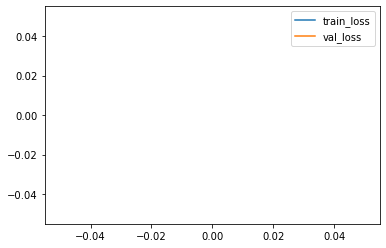

In [7]:
last_weights, best_weights = train(model, "baseline", batch_size, n_epochs, lr, trainloader, valloader, saved_model_path=current_model_path)

In [8]:
model

BaselineModel(
  (cnn): cnn(
    (pretrained_vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
  

In [13]:
model.eval()

# Turn off gradients for validation
with torch.no_grad():
    test_loss, accuracy = validation(model, valloader, criterion, device)
#                         recall = metrics.recall(confusion_matrix, num_classes)
#                         precision = metrics.precision(confusion_matrix, num_classes)
#                         f1 = metrics.f1(confusion_matrix, num_classes)

#                     filepath = saved_model_path + f"{model_name}-{start_time}-b{batch_size}-e{e}.pt"
#                     torch.save(model, filepath)

# running_loss /= validate_every

# time_elapsed = (datetime.now() - start_time)
# tqdm.write(f'===Epoch: {e+1}===')
# tqdm.write(f'== Loss: {running_loss:.3f} Time: {datetime.now()} Elapsed: {time_elapsed}')    
# tqdm.write(f'== Val Loss: {test_loss/len(val_loader):.3f} Val Accuracy: {accuracy/len(val_loader):.3f}') 


In [16]:
print(test_loss/len(valloader), accuracy/len(valloader))

5.064775086220922 tensor(0.1623)


In [42]:
running_loss = 0.0
for e in range(n_epochs):  # loop over the dataset multiple times
    
    # Training
    model.train()

    for videos, labels in trainloader:
        videos, labels = videos.to(device), labels.to(device)
        steps += 1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(videos)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if steps % print_every == 0:
            # Eval mode for predictions
#             model.eval()

            # Turn off gradients for validation
#             with torch.no_grad():
#                 test_loss, accuracy = validation(model, val_loader1, criterion, device)

            print("Epoch: {}/{} - ".format(e+1, n_epochs),
                  "Training Loss: {:.3f} - ".format(running_loss/print_every),
#                   "Validation Loss: {:.3f} - ".format(test_loss/len(val_loader1)),
#                   "Validation Accuracy: {:.3f}".format(accuracy/len(val_loader1))
                 )

            train_loss_ls.append(running_loss/print_every)
#             val_loss_ls.append(test_loss/len(val_loader1))
            running_loss = 0
#             filepath = current_model_path + f"b{batch_size}-e{n_epochs}.pt"
#             torch.save(model, filepath)

            # Make sure training is back on
#             model.train()
        

        
print("Finished training")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/5 -  Training Loss: 5.957 - 
Epoch: 1/5 -  Training Loss: 5.685 - 
Epoch: 1/5 -  Training Loss: 5.969 - 
Epoch: 1/5 -  Training Loss: 5.815 - 
Epoch: 1/5 -  Training Loss: 6.000 - 
Epoch: 1/5 -  Training Loss: 5.840 - 
Epoch: 1/5 -  Training Loss: 5.906 - 
Epoch: 1/5 -  Training Loss: 5.566 - 
Epoch: 1/5 -  Training Loss: 5.644 - 
Epoch: 1/5 -  Training Loss: 5.633 - 
Epoch: 1/5 -  Training Loss: 5.675 - 
Epoch: 1/5 -  Training Loss: 5.927 - 
Epoch: 1/5 -  Training Loss: 6.035 - 
Epoch: 1/5 -  Training Loss: 5.725 - 
Epoch: 1/5 -  Training Loss: 5.868 - 
Epoch: 1/5 -  Training Loss: 5.754 - 
Epoch: 1/5 -  Training Loss: 5.406 - 
Epoch: 1/5 -  Training Loss: 5.758 - 
Epoch: 1/5 -  Training Loss: 5.882 - 
Epoch: 1/5 -  Training Loss: 5.822 - 
Epoch: 1/5 -  Training Loss: 5.453 - 
Epoch: 1/5 -  Training Loss: 5.720 - 
Epoch: 1/5 -  Training Loss: 5.765 - 
Epoch: 1/5 -  Training Loss: 6.271 - 
Epoch: 1/5 -  Training Loss: 5.664 - 
Epoch: 1/5 -  Training Loss: 5.768 - 
Epoch: 1/5 -

KeyboardInterrupt: 

In [34]:
type(aa)

torch.Tensor

In [50]:
vgg =  models.vgg16(pretrained=True)
t = nn.Sequential(*list(vgg.features.children())[:-5])

for param in t.parameters():
    param.requires_grad = False

t.add_module("conv5_2", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
t.add_module("relu5_2", nn.ReLU(inplace=True))
t.add_module("conv5_3", nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
t.add_module("relu5_3", nn.ReLU(inplace=True))
        
summary(t, (3,256,256))
# i

'''
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
'''

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 256, 256]        (1,792)
├─ReLU: 1-2                              [-1, 64, 256, 256]        --
├─Conv2d: 1-3                            [-1, 64, 256, 256]        (36,928)
├─ReLU: 1-4                              [-1, 64, 256, 256]        --
├─MaxPool2d: 1-5                         [-1, 64, 128, 128]        --
├─Conv2d: 1-6                            [-1, 128, 128, 128]       (73,856)
├─ReLU: 1-7                              [-1, 128, 128, 128]       --
├─Conv2d: 1-8                            [-1, 128, 128, 128]       (147,584)
├─ReLU: 1-9                              [-1, 128, 128, 128]       --
├─MaxPool2d: 1-10                        [-1, 128, 64, 64]         --
├─Conv2d: 1-11                           [-1, 256, 64, 64]         (295,168)
├─ReLU: 1-12                             [-1, 256, 64, 64]         --
├─Conv2d: 1-13                           [-1, 256, 64,

'\nConv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n(27): ReLU(inplace=True)\n(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n(29): ReLU(inplace=True)\n'

In [45]:
t.c

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [29]:
models.vgg16(pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1